In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn import metrics
from scipy import interpolate
from tqdm import tqdm
from pathlib import Path
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import copy

In [2]:
# Set up plotting style

sns.set(font_scale=1.5)
sns.set_style('ticks')

colors = ['#88CCEE', '#882255', '#999933', '#332288', '#DDCC77', '#117733','#CC6677', '#44AA99', '#AA4499', '#DDDDDD', '#C70039', '#000000', '#D55E00', '#0072B2']

## Data loading and preprocessing

In [3]:
# Load data and filter for minimum number of occurences
# Returns a dict: extinction name -> pandas data frame

min_occurrence = 3

# Cleaned data - three extinctions
data_base = Path('data')

# List of characteristics
# It's important to place non-categorical characteristics at the END of this list.
characteristics = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology', 'geoplates', 'species']
categorical_chars = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology']

# Loading
events = [x for x in data_base.iterdir() if x.is_file() and x.suffix == '.csv']
datasets = {x.name[:x.name.find('_')]: pd.read_csv(x) for x in events}

# Filtering for number of occurrences, species and geoplates
datasets = {key: val[val['t_occurrences'] >= min_occurrence] for key, val in datasets.items()}
datasets = {key: val[val['species'] > 0] for key, val in datasets.items()}
datasets = {key: val[val['geoplates'] > 0] for key, val in datasets.items()}

In [4]:
# Order of the three major extinctions
ext_order = ['PTr', 'TrJ', 'KPg']
ext_name = {'PTr': 'P/Tr', 
             'TrJ': 'Tr/J',
             'KPg': 'K/Pg'}

In [5]:
# homogenize spelling (capitalization)
for dataset in datasets.values():
    dataset.loc[dataset["mineralogy"] == "High Mg calcite", "mineralogy"] = "high Mg calcite"

In [6]:
# Resamples the data sets to split entries with multiple values into multiple rows with lower weight

def traverse(row, chars, params, weight):
    # Goes over the row recursively and splits if it finds multiple values for one characteristic
    if len(chars) == 0:
        params['weight'] = weight
        return [params]
    else:
        c = chars[0]
        v = row[c]
        if isinstance(v, int) or isinstance(v, float):
            if c not in categorical_chars or v < 10:
                params[c] = v
                return traverse(row, chars[1:], params, weight)
            else:
                res = []
                params1 = copy.deepcopy(params)
                params1[c] = v // 10
                res += traverse(row, chars[1:], params1, weight / 2)
                params2 = copy.deepcopy(params)
                params2[c] = v % 10
                res += traverse(row, chars[1:], params2, weight / 2)
                return res
        else:
            res = []
            parts = v.split('/')
                
            for subv in parts:
                subv = subv.strip()
                subparams = copy.deepcopy(params)
                subparams[c] = subv
                res += traverse(row, chars[1:], subparams, weight / len(parts))
            return res

def rewrite_multi_category(dataset):
    # Iterates over the rows for the traversal
    res = []
    for _, row in dataset.iterrows():
        start_cols = [x for x in dataset.columns if x not in characteristics]
        params = {x: row[x] for x in start_cols}
        
        res += traverse(row, characteristics, params, 1)
    
    return pd.DataFrame(res)

def repeat_rows(dataset):
    # Repeat rows according to the inverse of their weights
    wmin = np.min(dataset['weight'])
    res = []
    for _, row in dataset.iterrows():
        res += int(np.round(row['weight'] / wmin)) * [row]
    return pd.DataFrame(res)

# Run the actual resampling
datasets = {k: rewrite_multi_category(v) for k, v in datasets.items()}

In [7]:
orders = {}

# Fixed orders
orders["tiering"] = ["pelagic", "erect", "epifaunal", "semi-infaunal", "shallow infaunal", "deep infaunal"]
orders["motility"] = ["fast, motile", "slow, motile", "facultative, unattached", "facultative, attached", "stationary, unattached", "stationary, attached"]
orders["feeding"] = ["suspension", "surface deposit", "miner", "grazer", "predator", "symbionts"]
orders["protein"] = ['hemerythrin', 'hemocyanin', 'hemoglobin', 'other']
orders["reproduction"] = ['non-broadcaster', 'intermediate', 'broadcaster']
orders["mineralogy"] = ['aragonite', 'high Mg calcite', 'low Mg calcite', 'bimineralic', 'phosphatic', 'chitin', 'gorgonin', 'silica', 'soft-bodied']
orders["physiology"] = ['heavy carbonate load', 'moderate carbonate load', 'little or no carbonate load']

In [8]:
extinctions = ext_order
n_ext = len(extinctions)

In [9]:
a=datasets["KPg"]
a.weight.min()

0.5

## Data exploration

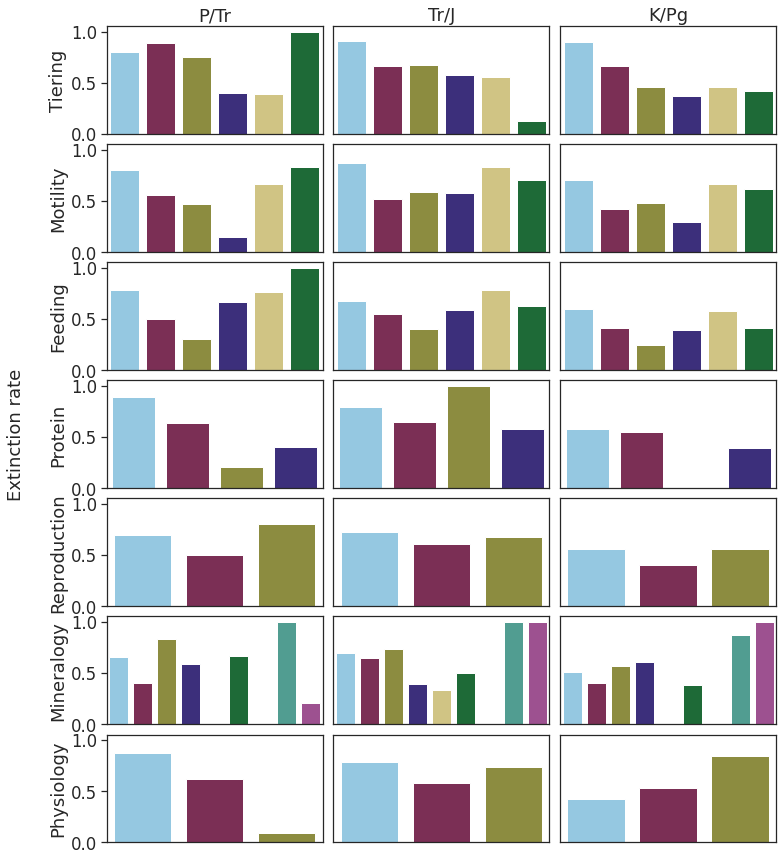

In [10]:
# Exploratory plot of the feature distribution
# For space constraints the feature names are removed

fig = plt.figure(figsize=(12, 15))
axs = fig.subplots(ncols=len(datasets), nrows=len(characteristics) - 2, gridspec_kw={'hspace': 0.1, 'wspace': 0.05}, sharex='row', sharey=True)

for j, (ext, dataset) in enumerate(datasets.items()):
    axs[0][j].set_title(ext_name[ext])

    for i, char in enumerate(characteristics[:-2]):
        sns.barplot(data=dataset, x=char, y='extinct', ci=None, palette=colors, order=orders[char], ax=axs[i][j])
        
        if j > 0:
            axs[i][j].yaxis.set_visible(False)
        axs[i][j].xaxis.set_visible(False)
        
for i, char in enumerate(characteristics[:-2]):
    axs[i][0].set_ylabel(char.capitalize())
    
axs[3][0].set_ylabel(f'Extinction rate\n\n{characteristics[3].capitalize()}')

fig.savefig("images/extinction_rates.png", dpi=300, bbox_inches="tight")

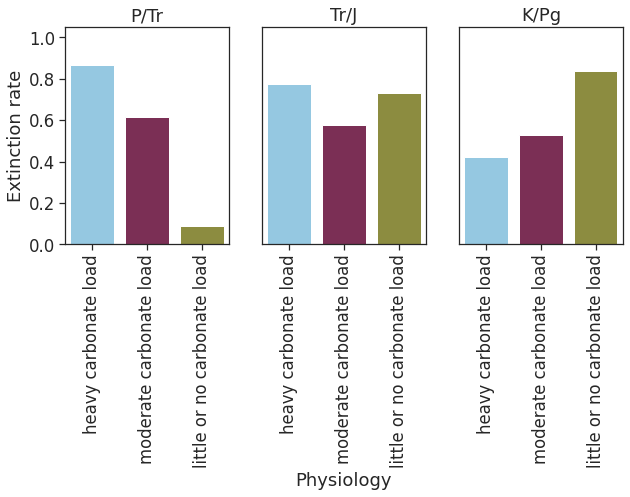

In [11]:
# Exploratory plot for a single characteristic
# char_idx is the index of the char in the list of characteristics
def exploratory_char(char_idx):
    fig = plt.figure(figsize=(10, 4))
    axs = fig.subplots(1, len(datasets), sharex=True, sharey=True)

    for j, (ext, dataset) in enumerate(datasets.items()):
        axs[j].set_title(ext_name[ext])

        char = characteristics[char_idx]

        sns.barplot(data=dataset, x=char, y='extinct', ci=None, palette=colors, order=orders[char], ax=axs[j])

        if j > 0:
            axs[j].yaxis.set_visible(False)

        axs[j].tick_params(axis='x', rotation=90)
        axs[j].set_xlabel('')

    axs[len(datasets) // 2].set_xlabel(char.capitalize())
    axs[0].set_ylabel('Extinction rate')
    axs[0].set_ylim(0, 1.05)

# Example plot
exploratory_char(6)

In [12]:
# Print dataset statistics for the resampled datasets

print('Extinction\t# Extinct\t# Total\t\tFraction extinct')
for ext in ext_order:
    dataset = datasets[ext]
    print(f'{ext}\t\t{np.sum(dataset["extinct"])}\t\t{len(dataset)}\t\t{np.sum(dataset["extinct"]) / len(dataset):.2f}')
print('Respecting weights:')
for ext in ext_order:
    dataset = datasets[ext]
    print(f'{ext}\t\t{dataset[dataset.extinct==1]["weight"].sum()}\t\t{dataset.weight.sum()}\t\t{dataset[dataset.extinct==1]["weight"].sum() / dataset.weight.sum():.2f}')

Extinction	# Extinct	# Total		Fraction extinct
PTr		466		629		0.74
TrJ		410		614		0.67
KPg		628		1183		0.53
Respecting weights:
PTr		466.0		628.0		0.74
TrJ		381.0		571.0		0.67
KPg		617.0		1154.0		0.53


## E_occurence as predictor

In roughly half of the samples (even more for TrJ) we find e_occurrences < 3. As we required t_occurrences >= 3 in our data selection, this already guarantees for these samples, that they did not went extinct, basically removing half of the data for actuall assessment.

In [13]:
print('Extinction\tNaN\t#e_occurrences < 3\t# Samples')
for name, dataset in datasets.items():
    print(f"{name}\t\t{np.sum(np.isnan(dataset['e_occurrences']))}\t{np.sum(dataset['e_occurrences'] < 3)}\t\t\t{len(dataset)}")
    
print("Respecting weights:")
for name, dataset in datasets.items():
    print(f"{name}\t\t{np.sum(np.isnan(dataset['e_occurrences']))}\t{dataset[dataset['e_occurrences'] < 3].weight.sum()}\t\t\t{dataset.weight.sum()}")

Extinction	NaN	#e_occurrences < 3	# Samples
PTr		0	176			629
TrJ		0	225			614
KPg		0	288			1183
Respecting weights:
PTr		0	175.0			628.0
TrJ		0	214.0			571.0
KPg		0	276.0			1154.0


## Model training 

In [14]:
def split_xy(data):
    # Returns numpy matrices of features and labels
    return data[characteristics].values, data['extinct'].values

def prepare_data(dataset, split=True):
    if split:
        # Splits data into training and test with a ratio of 80 : 20.
        # Ensures that all samples from the same base index are in the same split to avoid knowledge leaks.
        # Multiple occurrence of the same sample is a result from the resampling.
        base_idx = np.unique(dataset.index)
        
        splits = np.arange(5).repeat(len(base_idx) // 5 + 1)
        np.random.shuffle(splits)
        splits = splits[:len(base_idx)]
        test_idx = base_idx[splits == 0]

        train_data = dataset[~dataset.index.isin(test_idx)]
        test_data = dataset[dataset.index.isin(test_idx)]

        x_train, y_train = split_xy(train_data)
        x_test, y_test = split_xy(test_data)
    
        return x_train, y_train, x_test, y_test
        
    else:
        return split_xy(dataset)

In [15]:
# Train a catboost model
def train_model(x_train, y_train, x_test, y_test, random_seed=0, **kwargs):
    model = CatBoostClassifier(loss_function="Logloss", random_seed=random_seed)

    # Sets all features a categorical except e_occurrences
    model.fit(x_train, y_train, np.arange(len(categorical_chars)), eval_set=(x_test, y_test), **kwargs)
    
    return model

In [16]:
def run_experiments(iterations=10):
    # Trains models and evaluates feature importance and performance on the different data sets for each iteration
    # The results are stored in the variables res_full (AUC scores) and feat_imp (feature importances)

    res_full = np.zeros((iterations, n_ext, n_ext))
    res_full_train = np.zeros((iterations, n_ext))
    feat_imp = np.zeros((iterations, n_ext, len(characteristics)))

    fpr = dict()
    tpr = dict()
    
    data = None
    model = None
    
    for it in tqdm(range(iterations)):
        res = res_full[it]
        res_train = res_full_train[it]
        
        for i, base in enumerate(extinctions):
            data = prepare_data(datasets[base])
                        
            model = train_model(*data, random_seed=it, plot=False, verbose=False, use_best_model=False)

            feat_imp[it, i] = model.feature_importances_

            x_train, y_train, x_test, y_test = data

            train_auc = metrics.roc_auc_score(y_train, model.predict_log_proba(x_train)[:, 1])
            test_auc = metrics.roc_auc_score(y_test, model.predict_log_proba(x_test)[:, 1])
            res_train[i] = train_auc
            res[i, i] = test_auc
            
            fpr[it, base, base], tpr[it, base, base], _ = metrics.roc_curve(
                y_test, model.predict_log_proba(x_test)[:, 1])

            for j, ext in enumerate(extinctions):
                if ext == base:
                    continue
                dataset = datasets[ext]

                x, y = split_xy(dataset)

                res[i, j] = metrics.roc_auc_score(y, model.predict_log_proba(x)[:, 1])
                fpr[it, base, ext], tpr[it, base, ext], _ = metrics.roc_curve(
                    y, model.predict_log_proba(x)[:, 1])
    
    return res_full, feat_imp, fpr, tpr, res_full_train

In [17]:
res_full_noocc, feat_imp_noocc, fpr_noocc, tpr_noocc, res_train = run_experiments(iterations=10)

100%|███████████████████████████████████████████| 10/10 [00:44<00:00,  4.42s/it]


In [18]:
# to measure overfitting (dev_score / train_score)
print("dev_score / train_score")
print("\t".join(extinctions))
print("\t".join([f"{x:.2f}" for x in np.mean(res_full_noocc[:, [0, 1, 2], [0, 1, 2]] / res_train, axis=0)]))

dev_score / train_score
PTr	TrJ	KPg
0.93	0.84	0.91


## Result plotting

In [19]:
def plot_auc_grid(res_full, vmax=0.85):
    # Plot average AUC for the different corpora combinations

    fig = plt.figure(figsize=(8, 7))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, **{'width_ratios': [5, 0.5], 'wspace': 0.1})
    ax = fig.add_subplot(spec[0])

    res_reduced = np.mean(res_full, axis=0)

    cb = ax.imshow(res_reduced, vmin=0.5, vmax=vmax)

    ax.set_xticks(np.arange(n_ext))
    ax.set_xticklabels([ext_name[ext] for ext in extinctions])
    ax.set_yticks(np.arange(n_ext))
    ax.set_yticklabels([ext_name[ext] for ext in extinctions])

    ax.set_xlabel('Applied to')
    ax.set_ylabel('Trained on')

    ax3 = fig.add_subplot(spec[1])
    fig.colorbar(cb, cax=ax3)

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    ax3.set_ylabel('Performance')
    
    fig.savefig("images/auc_grid.png", dpi=300, bbox_inches="tight")

In [20]:
def plot_feat_imp(feat_imp):
    # Plot average and standard deviation of the feature importances

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    base_x = np.arange(n_ext)
    w = 0.07

    for i, char in enumerate(characteristics):            
        px = base_x + (i - 3) * w
        m = feat_imp[:, :, i].mean(axis=0)
        std = feat_imp[:, :, i].std(axis=0) / np.sqrt(feat_imp.shape[0])

        ax.plot(px, m, 'o', c=f'C{i}', label=char.capitalize(), ms=10)
        ax.plot(px, m, '-', c=f'C{i}', linewidth=2)
        for j in range(feat_imp.shape[1]):
            ax.plot([px[j], px[j]], [m[j] + std[j], m[j] - std[j]], c=f'k', linewidth=1.5, alpha=1)
            ax.plot([px[j] - w / 3, px[j] + w / 3], [m[j] + std[j], m[j] + std[j]], c=f'k', linewidth=1.5, alpha=1)
            ax.plot([px[j] - w / 3, px[j] + w / 3], [m[j] - std[j], m[j] - std[j]], c=f'k', linewidth=1.5, alpha=1)

    for s, e in zip(base_x[:-1], base_x[1:]):
        ax.axvline((s + e) / 2, alpha=0.3, c='k', linestyle='--', lw=1.5)

    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    ax.set_xticks(base_x)
    ax.set_xticklabels([ext_name[ext] for ext in extinctions])

    # ax.set_yticklabels([])
    # ax.set_yticks([])
    ax.set_ylim(0)
    ax.set_ylabel('Feature importance')
    ax.set_xlabel('Extinction')
    
    fig.savefig("images/feature_importance.png", dpi=300, bbox_inches="tight")

In [21]:
def plot_roc_grid(fpr, tpr, res_full):
    res_reduced = np.mean(res_full, axis=0)
    xSpace = np.linspace(0,1,300)

    fig, axs = plt.subplots(3, 3, 
                            sharex=True, sharey=True, 
                            figsize=(12, 12), 
                            gridspec_kw={'hspace': 0.2, 'wspace': 0.15})
    
    for i, ext in enumerate(extinctions):
        for j, base in enumerate(extinctions):
            axs[i, j].set_title(ext_name[base] + r" $\rightarrow$ " + ext_name[ext])
            interpROCs = []
            for it in range(res_full.shape[0]):
                axs[i, j].plot(fpr[it, base, ext], tpr[it, base, ext], 'k-', alpha=0.3, linewidth=1)
                # ROC curves have different x-values. To average them, they are first interpolated to 
                # a common linspace ("xSpace")
                interpROC = interpolate.interp1d(fpr[it, base, ext], tpr[it, base, ext], kind='linear')
                interpROCs.append(interpROC(xSpace))
                
            avgROC = np.mean(interpROCs, axis=0)
            axs[i, j].plot(xSpace, avgROC, 'k-', alpha=1, linewidth=1)
            axs[i, j].plot([0, 1], [0, 1], "k--")
            axs[i, j].set_xlim(0, 1)
            axs[i, j].set_ylim(0, 1)
            axs[i, j].set_aspect(1)
            axs[i, j].set_xticks([0, 0.5, 1])
            axs[i, j].set_yticks([0, 0.5, 1])
            axs[i, j].set_xticklabels(axs[i, j].get_xticks())
        
            axs[i,j].text(0.49, 0.13, 
                          "$\overline{\mathrm{AUC}}$" + "={:.2f}".format(res_reduced[j,i]), 
                          horizontalalignment="left", 
                          verticalalignment="top")
            
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    
    fig.savefig("images/roc_curves.png", dpi=300, bbox_inches="tight")
    
#     plt.show()

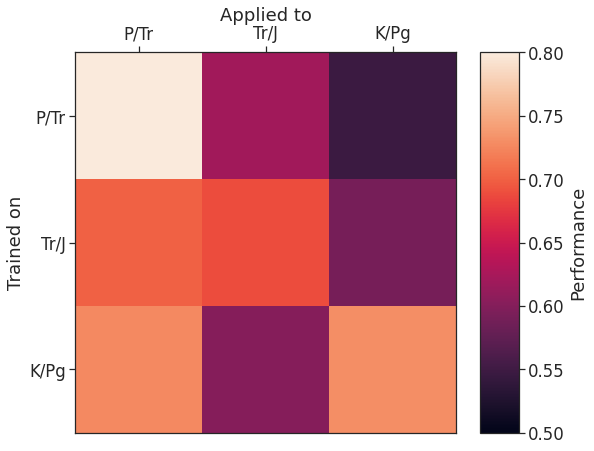

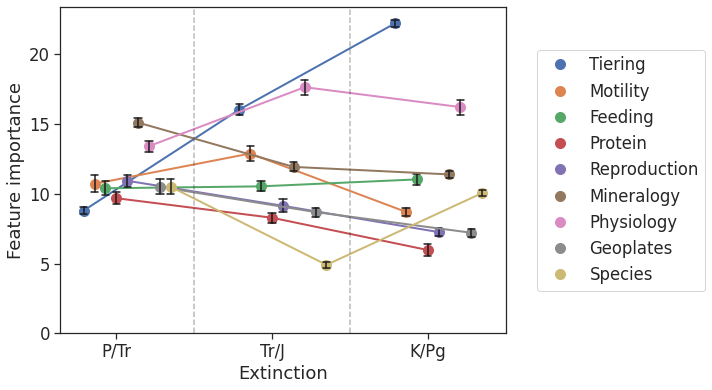

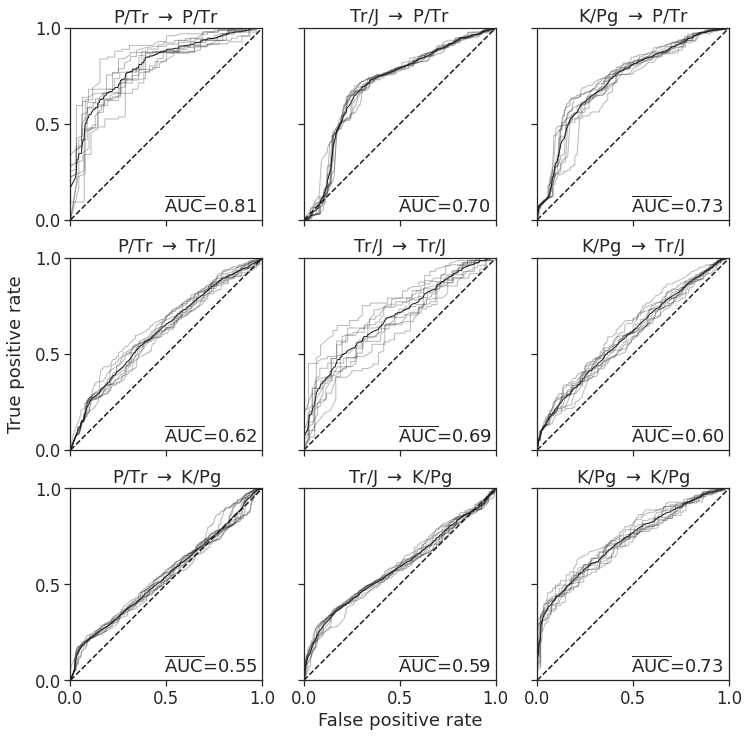

In [22]:
plot_auc_grid(res_full_noocc, vmax=0.80)
plot_feat_imp(feat_imp_noocc)
plot_roc_grid(fpr_noocc, tpr_noocc, res_full_noocc)

## Hyperparameter search

In [23]:
# Find optimal hyperparameters 
def find_best_params(training_data, **kwargs):
    model = CatBoostClassifier(iterations=1000)
    
    grid = {'learning_rate': [0.01, 0.03, 0.1, 0.5],
            'depth': [1,4, 6, 8, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]}
    
    res_dict = model.grid_search(grid, training_data, verbose=3, **kwargs)
    return res_dict["params"], res_dict["cv_results"]

In [24]:
params = {}
cv_results = {}

for i, base in enumerate(extinctions):
    data = datasets[base]
    x_train, y_train = split_xy(data)
    training_data = Pool(x_train, y_train, 
                         cat_features=np.arange(x_train.shape[1] - 2),
                         weight=data["weight"])
    params[base], cv_results[base] = find_best_params(training_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6904258	test: 0.6905775	best: 0.6905775 (0)	total: 781us	remaining: 781ms
1:	learn: 0.6868193	test: 0.6868072	best: 0.6868072 (1)	total: 1.33ms	remaining: 664ms
2:	learn: 0.6832536	test: 0.6830771	best: 0.6830771 (2)	total: 1.65ms	remaining: 549ms
3:	learn: 0.6805788	test: 0.6805510	best: 0.6805510 (3)	total: 2.03ms	remaining: 506ms
4:	learn: 0.6770585	test: 0.6768361	best: 0.6768361 (4)	total: 2.34ms	remaining: 466ms
5:	learn: 0.6744530	test: 0.6743656	best: 0.6743656 (5)	total: 2.64ms	remaining: 438ms
6:	learn: 0.6718856	test: 0.6717255	best: 0.6717255 (6)	total: 2.95ms	remaining: 419ms
7:	learn: 0.6685493	test: 0.6681995	best: 0.6681995 (7)	total: 3.33ms	remaining: 413ms
8:	learn: 0.6661006	test: 0.6659180	best: 0.6659180 (8)	total: 3.87ms	remaining: 426ms
9:	learn: 0.6629539	test: 0.6626047	best: 0.6626047 (9)	total: 4.3ms	remaining: 425ms
10:	learn: 0.6599350	test: 0.6594397	best: 0.6594397 (10)	total: 5.08ms	remaining: 457ms
11:	learn: 0.6576868	test: 0.6571689	best: 

491:	learn: 0.4781505	test: 0.4867648	best: 0.4867648 (491)	total: 186ms	remaining: 192ms
492:	learn: 0.4780191	test: 0.4867681	best: 0.4867648 (491)	total: 187ms	remaining: 192ms
493:	learn: 0.4779555	test: 0.4867656	best: 0.4867648 (491)	total: 187ms	remaining: 192ms
494:	learn: 0.4779352	test: 0.4867687	best: 0.4867648 (491)	total: 187ms	remaining: 191ms
495:	learn: 0.4779016	test: 0.4867670	best: 0.4867648 (491)	total: 188ms	remaining: 191ms
496:	learn: 0.4779015	test: 0.4867682	best: 0.4867648 (491)	total: 188ms	remaining: 190ms
497:	learn: 0.4778302	test: 0.4866730	best: 0.4866730 (497)	total: 189ms	remaining: 190ms
498:	learn: 0.4777018	test: 0.4866763	best: 0.4866730 (497)	total: 189ms	remaining: 190ms
499:	learn: 0.4777018	test: 0.4866763	best: 0.4866730 (497)	total: 189ms	remaining: 189ms
500:	learn: 0.4775790	test: 0.4864833	best: 0.4864833 (500)	total: 190ms	remaining: 189ms
501:	learn: 0.4775565	test: 0.4864754	best: 0.4864754 (501)	total: 190ms	remaining: 189ms
502:	learn

5:	learn: 0.6416131	test: 0.6419996	best: 0.6419996 (5)	total: 2.48ms	remaining: 411ms
6:	learn: 0.6337545	test: 0.6336165	best: 0.6336165 (6)	total: 2.97ms	remaining: 421ms
7:	learn: 0.6265510	test: 0.6259889	best: 0.6259889 (7)	total: 3.41ms	remaining: 423ms
8:	learn: 0.6214387	test: 0.6213520	best: 0.6213520 (8)	total: 3.82ms	remaining: 421ms
9:	learn: 0.6162880	test: 0.6166288	best: 0.6166288 (9)	total: 4.25ms	remaining: 420ms
10:	learn: 0.6099562	test: 0.6099041	best: 0.6099041 (10)	total: 4.74ms	remaining: 426ms
11:	learn: 0.6055118	test: 0.6054318	best: 0.6054318 (11)	total: 5.19ms	remaining: 428ms
12:	learn: 0.6017611	test: 0.6021784	best: 0.6021784 (12)	total: 5.56ms	remaining: 422ms
13:	learn: 0.5972282	test: 0.5985248	best: 0.5985248 (13)	total: 5.96ms	remaining: 420ms
14:	learn: 0.5935725	test: 0.5951912	best: 0.5951912 (14)	total: 6.31ms	remaining: 414ms
15:	learn: 0.5886231	test: 0.5898929	best: 0.5898929 (15)	total: 6.63ms	remaining: 408ms
16:	learn: 0.5841679	test: 0.58

438:	learn: 0.4565606	test: 0.4763233	best: 0.4756138 (368)	total: 190ms	remaining: 242ms
439:	learn: 0.4565217	test: 0.4764182	best: 0.4756138 (368)	total: 190ms	remaining: 242ms
440:	learn: 0.4564711	test: 0.4763379	best: 0.4756138 (368)	total: 191ms	remaining: 242ms
441:	learn: 0.4564691	test: 0.4763221	best: 0.4756138 (368)	total: 191ms	remaining: 242ms
442:	learn: 0.4563620	test: 0.4760663	best: 0.4756138 (368)	total: 192ms	remaining: 242ms
443:	learn: 0.4562953	test: 0.4760297	best: 0.4756138 (368)	total: 193ms	remaining: 241ms
444:	learn: 0.4561944	test: 0.4757856	best: 0.4756138 (368)	total: 193ms	remaining: 241ms
445:	learn: 0.4561468	test: 0.4757512	best: 0.4756138 (368)	total: 194ms	remaining: 241ms
446:	learn: 0.4561329	test: 0.4757462	best: 0.4756138 (368)	total: 194ms	remaining: 240ms
447:	learn: 0.4560708	test: 0.4757132	best: 0.4756138 (368)	total: 195ms	remaining: 240ms
448:	learn: 0.4560106	test: 0.4757258	best: 0.4756138 (368)	total: 195ms	remaining: 240ms
449:	learn

773:	learn: 0.4440383	test: 0.4720502	best: 0.4719837 (767)	total: 379ms	remaining: 111ms
774:	learn: 0.4440268	test: 0.4720416	best: 0.4719837 (767)	total: 381ms	remaining: 111ms
775:	learn: 0.4439649	test: 0.4720749	best: 0.4719837 (767)	total: 381ms	remaining: 110ms
776:	learn: 0.4439090	test: 0.4717830	best: 0.4717830 (776)	total: 382ms	remaining: 110ms
777:	learn: 0.4439067	test: 0.4717513	best: 0.4717513 (777)	total: 383ms	remaining: 109ms
778:	learn: 0.4438764	test: 0.4718362	best: 0.4717513 (777)	total: 383ms	remaining: 109ms
779:	learn: 0.4438137	test: 0.4716453	best: 0.4716453 (779)	total: 384ms	remaining: 108ms
780:	learn: 0.4438096	test: 0.4716532	best: 0.4716453 (779)	total: 385ms	remaining: 108ms
781:	learn: 0.4437094	test: 0.4716594	best: 0.4716453 (779)	total: 385ms	remaining: 107ms
782:	learn: 0.4436722	test: 0.4716382	best: 0.4716382 (782)	total: 386ms	remaining: 107ms
783:	learn: 0.4436601	test: 0.4716565	best: 0.4716382 (782)	total: 386ms	remaining: 106ms
784:	learn

96:	learn: 0.4626941	test: 0.4707630	best: 0.4707630 (96)	total: 56.4ms	remaining: 525ms
97:	learn: 0.4625490	test: 0.4707798	best: 0.4707630 (96)	total: 57ms	remaining: 525ms
98:	learn: 0.4623372	test: 0.4715621	best: 0.4707630 (96)	total: 57.6ms	remaining: 525ms
99:	learn: 0.4623363	test: 0.4715558	best: 0.4707630 (96)	total: 58.2ms	remaining: 524ms
100:	learn: 0.4616653	test: 0.4718031	best: 0.4707630 (96)	total: 58.9ms	remaining: 524ms
101:	learn: 0.4611025	test: 0.4717356	best: 0.4707630 (96)	total: 59.3ms	remaining: 522ms
102:	learn: 0.4606473	test: 0.4717258	best: 0.4707630 (96)	total: 59.9ms	remaining: 522ms
103:	learn: 0.4606346	test: 0.4716751	best: 0.4707630 (96)	total: 60.4ms	remaining: 520ms
104:	learn: 0.4601306	test: 0.4719384	best: 0.4707630 (96)	total: 60.9ms	remaining: 519ms
105:	learn: 0.4600327	test: 0.4717028	best: 0.4707630 (96)	total: 61.3ms	remaining: 517ms
106:	learn: 0.4595388	test: 0.4705629	best: 0.4705629 (106)	total: 61.9ms	remaining: 517ms
107:	learn: 0.4

415:	learn: 0.4301187	test: 0.4688098	best: 0.4652805 (302)	total: 244ms	remaining: 343ms
416:	learn: 0.4301156	test: 0.4687731	best: 0.4652805 (302)	total: 245ms	remaining: 343ms
417:	learn: 0.4300631	test: 0.4686650	best: 0.4652805 (302)	total: 246ms	remaining: 342ms
418:	learn: 0.4299273	test: 0.4690049	best: 0.4652805 (302)	total: 246ms	remaining: 342ms
419:	learn: 0.4298454	test: 0.4690335	best: 0.4652805 (302)	total: 247ms	remaining: 341ms
420:	learn: 0.4298428	test: 0.4690453	best: 0.4652805 (302)	total: 248ms	remaining: 340ms
421:	learn: 0.4298293	test: 0.4690024	best: 0.4652805 (302)	total: 248ms	remaining: 340ms
422:	learn: 0.4297979	test: 0.4689164	best: 0.4652805 (302)	total: 249ms	remaining: 339ms
423:	learn: 0.4297143	test: 0.4689404	best: 0.4652805 (302)	total: 249ms	remaining: 339ms
424:	learn: 0.4296860	test: 0.4689993	best: 0.4652805 (302)	total: 250ms	remaining: 338ms
425:	learn: 0.4296677	test: 0.4690066	best: 0.4652805 (302)	total: 251ms	remaining: 338ms
426:	learn

753:	learn: 0.4180227	test: 0.4717190	best: 0.4652805 (302)	total: 431ms	remaining: 141ms
754:	learn: 0.4179110	test: 0.4717549	best: 0.4652805 (302)	total: 432ms	remaining: 140ms
755:	learn: 0.4179082	test: 0.4717471	best: 0.4652805 (302)	total: 432ms	remaining: 140ms
756:	learn: 0.4179082	test: 0.4717466	best: 0.4652805 (302)	total: 433ms	remaining: 139ms
757:	learn: 0.4178972	test: 0.4715437	best: 0.4652805 (302)	total: 433ms	remaining: 138ms
758:	learn: 0.4178066	test: 0.4711064	best: 0.4652805 (302)	total: 434ms	remaining: 138ms
759:	learn: 0.4177066	test: 0.4716756	best: 0.4652805 (302)	total: 434ms	remaining: 137ms
760:	learn: 0.4177066	test: 0.4716752	best: 0.4652805 (302)	total: 435ms	remaining: 136ms
761:	learn: 0.4176705	test: 0.4718659	best: 0.4652805 (302)	total: 435ms	remaining: 136ms
762:	learn: 0.4176448	test: 0.4718260	best: 0.4652805 (302)	total: 435ms	remaining: 135ms
763:	learn: 0.4175690	test: 0.4712479	best: 0.4652805 (302)	total: 436ms	remaining: 135ms
764:	learn

76:	learn: 0.4338154	test: 0.4620665	best: 0.4590218 (73)	total: 47.5ms	remaining: 570ms
77:	learn: 0.4336974	test: 0.4620039	best: 0.4590218 (73)	total: 48.1ms	remaining: 568ms
78:	learn: 0.4323973	test: 0.4650412	best: 0.4590218 (73)	total: 48.6ms	remaining: 566ms
79:	learn: 0.4323803	test: 0.4646446	best: 0.4590218 (73)	total: 49.2ms	remaining: 566ms
80:	learn: 0.4315158	test: 0.4644548	best: 0.4590218 (73)	total: 49.9ms	remaining: 567ms
81:	learn: 0.4309748	test: 0.4667255	best: 0.4590218 (73)	total: 50.4ms	remaining: 564ms
82:	learn: 0.4299399	test: 0.4629863	best: 0.4590218 (73)	total: 51ms	remaining: 563ms
83:	learn: 0.4298706	test: 0.4632664	best: 0.4590218 (73)	total: 51.5ms	remaining: 561ms
84:	learn: 0.4298504	test: 0.4633256	best: 0.4590218 (73)	total: 51.9ms	remaining: 558ms
85:	learn: 0.4290207	test: 0.4648897	best: 0.4590218 (73)	total: 52.4ms	remaining: 557ms
86:	learn: 0.4279928	test: 0.4680532	best: 0.4590218 (73)	total: 53ms	remaining: 556ms
87:	learn: 0.4276392	test

401:	learn: 0.3843217	test: 0.4786848	best: 0.4590218 (73)	total: 235ms	remaining: 350ms
402:	learn: 0.3842144	test: 0.4783129	best: 0.4590218 (73)	total: 236ms	remaining: 349ms
403:	learn: 0.3841022	test: 0.4799281	best: 0.4590218 (73)	total: 236ms	remaining: 349ms
404:	learn: 0.3840283	test: 0.4802029	best: 0.4590218 (73)	total: 237ms	remaining: 348ms
405:	learn: 0.3839852	test: 0.4801317	best: 0.4590218 (73)	total: 238ms	remaining: 348ms
406:	learn: 0.3839579	test: 0.4800404	best: 0.4590218 (73)	total: 238ms	remaining: 347ms
407:	learn: 0.3838747	test: 0.4787396	best: 0.4590218 (73)	total: 239ms	remaining: 346ms
408:	learn: 0.3837735	test: 0.4781877	best: 0.4590218 (73)	total: 239ms	remaining: 346ms
409:	learn: 0.3833791	test: 0.4804719	best: 0.4590218 (73)	total: 240ms	remaining: 345ms
410:	learn: 0.3833246	test: 0.4805273	best: 0.4590218 (73)	total: 240ms	remaining: 344ms
411:	learn: 0.3833238	test: 0.4805412	best: 0.4590218 (73)	total: 241ms	remaining: 343ms
412:	learn: 0.3833037

776:	learn: 0.3594932	test: 0.4945876	best: 0.4590218 (73)	total: 423ms	remaining: 121ms
777:	learn: 0.3594891	test: 0.4948161	best: 0.4590218 (73)	total: 424ms	remaining: 121ms
778:	learn: 0.3594588	test: 0.4967477	best: 0.4590218 (73)	total: 424ms	remaining: 120ms
779:	learn: 0.3594194	test: 0.4963090	best: 0.4590218 (73)	total: 425ms	remaining: 120ms
780:	learn: 0.3594038	test: 0.4962650	best: 0.4590218 (73)	total: 425ms	remaining: 119ms
781:	learn: 0.3593704	test: 0.4968422	best: 0.4590218 (73)	total: 426ms	remaining: 119ms
782:	learn: 0.3592106	test: 0.4985716	best: 0.4590218 (73)	total: 426ms	remaining: 118ms
783:	learn: 0.3591962	test: 0.4985155	best: 0.4590218 (73)	total: 427ms	remaining: 118ms
784:	learn: 0.3591962	test: 0.4985146	best: 0.4590218 (73)	total: 427ms	remaining: 117ms
785:	learn: 0.3591562	test: 0.4978216	best: 0.4590218 (73)	total: 428ms	remaining: 116ms
786:	learn: 0.3591006	test: 0.4972559	best: 0.4590218 (73)	total: 428ms	remaining: 116ms
787:	learn: 0.3590871

157:	learn: 0.5160247	test: 0.5250996	best: 0.5250996 (157)	total: 78.6ms	remaining: 419ms
158:	learn: 0.5157008	test: 0.5249105	best: 0.5249105 (158)	total: 79.2ms	remaining: 419ms
159:	learn: 0.5154070	test: 0.5245626	best: 0.5245626 (159)	total: 79.7ms	remaining: 418ms
160:	learn: 0.5151086	test: 0.5242150	best: 0.5242150 (160)	total: 80.1ms	remaining: 417ms
161:	learn: 0.5147725	test: 0.5238662	best: 0.5238662 (161)	total: 80.7ms	remaining: 417ms
162:	learn: 0.5144432	test: 0.5235245	best: 0.5235245 (162)	total: 81.3ms	remaining: 417ms
163:	learn: 0.5141434	test: 0.5232826	best: 0.5232826 (163)	total: 81.7ms	remaining: 417ms
164:	learn: 0.5138761	test: 0.5229642	best: 0.5229642 (164)	total: 82.2ms	remaining: 416ms
165:	learn: 0.5136236	test: 0.5226566	best: 0.5226566 (165)	total: 82.6ms	remaining: 415ms
166:	learn: 0.5134759	test: 0.5225528	best: 0.5225528 (166)	total: 83ms	remaining: 414ms
167:	learn: 0.5132681	test: 0.5224180	best: 0.5224180 (167)	total: 83.4ms	remaining: 413ms
1

557:	learn: 0.4750823	test: 0.4876731	best: 0.4876458 (556)	total: 265ms	remaining: 210ms
558:	learn: 0.4750617	test: 0.4876759	best: 0.4876458 (556)	total: 265ms	remaining: 209ms
559:	learn: 0.4750065	test: 0.4876435	best: 0.4876435 (559)	total: 266ms	remaining: 209ms
560:	learn: 0.4749312	test: 0.4875405	best: 0.4875405 (560)	total: 267ms	remaining: 209ms
561:	learn: 0.4748345	test: 0.4873578	best: 0.4873578 (561)	total: 267ms	remaining: 208ms
562:	learn: 0.4747339	test: 0.4871935	best: 0.4871935 (562)	total: 268ms	remaining: 208ms
563:	learn: 0.4746475	test: 0.4871964	best: 0.4871935 (562)	total: 268ms	remaining: 208ms
564:	learn: 0.4746475	test: 0.4871964	best: 0.4871935 (562)	total: 269ms	remaining: 207ms
565:	learn: 0.4746275	test: 0.4871991	best: 0.4871935 (562)	total: 270ms	remaining: 207ms
566:	learn: 0.4745872	test: 0.4871515	best: 0.4871515 (566)	total: 270ms	remaining: 206ms
567:	learn: 0.4745137	test: 0.4870503	best: 0.4870503 (567)	total: 271ms	remaining: 206ms
568:	learn

890:	learn: 0.4641276	test: 0.4782459	best: 0.4782309 (887)	total: 453ms	remaining: 55.4ms
891:	learn: 0.4640728	test: 0.4782471	best: 0.4782309 (887)	total: 454ms	remaining: 54.9ms
892:	learn: 0.4640187	test: 0.4781235	best: 0.4781235 (892)	total: 454ms	remaining: 54.4ms
893:	learn: 0.4639986	test: 0.4781869	best: 0.4781235 (892)	total: 454ms	remaining: 53.9ms
894:	learn: 0.4639512	test: 0.4780189	best: 0.4780189 (894)	total: 455ms	remaining: 53.4ms
895:	learn: 0.4638986	test: 0.4778979	best: 0.4778979 (895)	total: 455ms	remaining: 52.9ms
896:	learn: 0.4638430	test: 0.4777887	best: 0.4777887 (896)	total: 456ms	remaining: 52.4ms
897:	learn: 0.4638198	test: 0.4777900	best: 0.4777887 (896)	total: 456ms	remaining: 51.8ms
898:	learn: 0.4637652	test: 0.4776825	best: 0.4776825 (898)	total: 457ms	remaining: 51.3ms
899:	learn: 0.4637508	test: 0.4776846	best: 0.4776825 (898)	total: 457ms	remaining: 50.8ms
900:	learn: 0.4637050	test: 0.4776865	best: 0.4776825 (898)	total: 458ms	remaining: 50.3ms

211:	learn: 0.4698610	test: 0.4781132	best: 0.4781132 (211)	total: 120ms	remaining: 447ms
212:	learn: 0.4698610	test: 0.4781131	best: 0.4781131 (212)	total: 121ms	remaining: 446ms
213:	learn: 0.4698610	test: 0.4781130	best: 0.4781130 (213)	total: 121ms	remaining: 446ms
214:	learn: 0.4698277	test: 0.4781059	best: 0.4781059 (214)	total: 122ms	remaining: 445ms
215:	learn: 0.4697319	test: 0.4782913	best: 0.4781059 (214)	total: 124ms	remaining: 449ms
216:	learn: 0.4697314	test: 0.4782919	best: 0.4781059 (214)	total: 124ms	remaining: 448ms
217:	learn: 0.4697314	test: 0.4782918	best: 0.4781059 (214)	total: 125ms	remaining: 448ms
218:	learn: 0.4694924	test: 0.4778686	best: 0.4778686 (218)	total: 125ms	remaining: 447ms
219:	learn: 0.4692674	test: 0.4774664	best: 0.4774664 (219)	total: 126ms	remaining: 446ms
220:	learn: 0.4691099	test: 0.4772426	best: 0.4772426 (220)	total: 126ms	remaining: 445ms
221:	learn: 0.4690231	test: 0.4772778	best: 0.4772426 (220)	total: 127ms	remaining: 444ms
222:	learn

593:	learn: 0.4496455	test: 0.4702262	best: 0.4697719 (542)	total: 306ms	remaining: 209ms
594:	learn: 0.4496449	test: 0.4702214	best: 0.4697719 (542)	total: 307ms	remaining: 209ms
595:	learn: 0.4496373	test: 0.4701493	best: 0.4697719 (542)	total: 308ms	remaining: 209ms
596:	learn: 0.4495570	test: 0.4701548	best: 0.4697719 (542)	total: 308ms	remaining: 208ms
597:	learn: 0.4494738	test: 0.4699390	best: 0.4697719 (542)	total: 309ms	remaining: 208ms
598:	learn: 0.4494737	test: 0.4699392	best: 0.4697719 (542)	total: 310ms	remaining: 207ms
599:	learn: 0.4494737	test: 0.4699392	best: 0.4697719 (542)	total: 310ms	remaining: 207ms
600:	learn: 0.4494691	test: 0.4699353	best: 0.4697719 (542)	total: 311ms	remaining: 207ms
601:	learn: 0.4493754	test: 0.4700883	best: 0.4697719 (542)	total: 312ms	remaining: 206ms
602:	learn: 0.4493565	test: 0.4700701	best: 0.4697719 (542)	total: 312ms	remaining: 206ms
603:	learn: 0.4493161	test: 0.4700425	best: 0.4697719 (542)	total: 313ms	remaining: 205ms
604:	learn

963:	learn: 0.4408028	test: 0.4666024	best: 0.4665492 (944)	total: 493ms	remaining: 18.4ms
964:	learn: 0.4407873	test: 0.4666443	best: 0.4665492 (944)	total: 494ms	remaining: 17.9ms
965:	learn: 0.4407850	test: 0.4666490	best: 0.4665492 (944)	total: 494ms	remaining: 17.4ms
966:	learn: 0.4406929	test: 0.4666335	best: 0.4665492 (944)	total: 494ms	remaining: 16.9ms
967:	learn: 0.4406384	test: 0.4667612	best: 0.4665492 (944)	total: 495ms	remaining: 16.4ms
968:	learn: 0.4406157	test: 0.4667827	best: 0.4665492 (944)	total: 495ms	remaining: 15.9ms
969:	learn: 0.4406066	test: 0.4667756	best: 0.4665492 (944)	total: 496ms	remaining: 15.3ms
970:	learn: 0.4405906	test: 0.4667639	best: 0.4665492 (944)	total: 496ms	remaining: 14.8ms
971:	learn: 0.4405899	test: 0.4667608	best: 0.4665492 (944)	total: 497ms	remaining: 14.3ms
972:	learn: 0.4405668	test: 0.4667210	best: 0.4665492 (944)	total: 497ms	remaining: 13.8ms
973:	learn: 0.4405665	test: 0.4667300	best: 0.4665492 (944)	total: 498ms	remaining: 13.3ms

349:	learn: 0.4358448	test: 0.4652057	best: 0.4651567 (346)	total: 167ms	remaining: 310ms
350:	learn: 0.4358448	test: 0.4652051	best: 0.4651567 (346)	total: 168ms	remaining: 310ms
351:	learn: 0.4358447	test: 0.4652044	best: 0.4651567 (346)	total: 168ms	remaining: 310ms
352:	learn: 0.4358217	test: 0.4651981	best: 0.4651567 (346)	total: 169ms	remaining: 310ms
353:	learn: 0.4357721	test: 0.4652240	best: 0.4651567 (346)	total: 170ms	remaining: 310ms
354:	learn: 0.4357579	test: 0.4652631	best: 0.4651567 (346)	total: 170ms	remaining: 309ms
355:	learn: 0.4355806	test: 0.4657068	best: 0.4651567 (346)	total: 170ms	remaining: 308ms
356:	learn: 0.4352665	test: 0.4660078	best: 0.4651567 (346)	total: 171ms	remaining: 308ms
357:	learn: 0.4351634	test: 0.4661312	best: 0.4651567 (346)	total: 171ms	remaining: 307ms
358:	learn: 0.4350996	test: 0.4662446	best: 0.4651567 (346)	total: 172ms	remaining: 307ms
359:	learn: 0.4350959	test: 0.4662791	best: 0.4651567 (346)	total: 172ms	remaining: 306ms
360:	learn

690:	learn: 0.4214324	test: 0.4702926	best: 0.4651567 (346)	total: 355ms	remaining: 159ms
691:	learn: 0.4213102	test: 0.4702565	best: 0.4651567 (346)	total: 356ms	remaining: 158ms
692:	learn: 0.4212837	test: 0.4699837	best: 0.4651567 (346)	total: 356ms	remaining: 158ms
693:	learn: 0.4212775	test: 0.4698869	best: 0.4651567 (346)	total: 357ms	remaining: 157ms
694:	learn: 0.4212420	test: 0.4697507	best: 0.4651567 (346)	total: 357ms	remaining: 157ms
695:	learn: 0.4212311	test: 0.4698496	best: 0.4651567 (346)	total: 358ms	remaining: 156ms
696:	learn: 0.4211785	test: 0.4700514	best: 0.4651567 (346)	total: 359ms	remaining: 156ms
697:	learn: 0.4211740	test: 0.4700914	best: 0.4651567 (346)	total: 359ms	remaining: 155ms
698:	learn: 0.4210587	test: 0.4702954	best: 0.4651567 (346)	total: 360ms	remaining: 155ms
699:	learn: 0.4210466	test: 0.4702109	best: 0.4651567 (346)	total: 360ms	remaining: 154ms
700:	learn: 0.4209992	test: 0.4705140	best: 0.4651567 (346)	total: 360ms	remaining: 154ms
701:	learn

50:	learn: 0.4389492	test: 0.4686561	best: 0.4633077 (42)	total: 28ms	remaining: 522ms
51:	learn: 0.4389489	test: 0.4686555	best: 0.4633077 (42)	total: 28.8ms	remaining: 526ms
52:	learn: 0.4389181	test: 0.4684756	best: 0.4633077 (42)	total: 29.4ms	remaining: 526ms
53:	learn: 0.4388262	test: 0.4683855	best: 0.4633077 (42)	total: 30ms	remaining: 526ms
54:	learn: 0.4387942	test: 0.4684909	best: 0.4633077 (42)	total: 30.5ms	remaining: 524ms
55:	learn: 0.4384312	test: 0.4677833	best: 0.4633077 (42)	total: 31ms	remaining: 522ms
56:	learn: 0.4376514	test: 0.4675896	best: 0.4633077 (42)	total: 31.6ms	remaining: 523ms
57:	learn: 0.4374848	test: 0.4678335	best: 0.4633077 (42)	total: 32ms	remaining: 520ms
58:	learn: 0.4367851	test: 0.4680224	best: 0.4633077 (42)	total: 32.5ms	remaining: 518ms
59:	learn: 0.4364359	test: 0.4686047	best: 0.4633077 (42)	total: 32.9ms	remaining: 516ms
60:	learn: 0.4364078	test: 0.4679948	best: 0.4633077 (42)	total: 33.4ms	remaining: 514ms
61:	learn: 0.4355940	test: 0.

370:	learn: 0.3886501	test: 0.4771092	best: 0.4633077 (42)	total: 216ms	remaining: 366ms
371:	learn: 0.3886143	test: 0.4771779	best: 0.4633077 (42)	total: 216ms	remaining: 365ms
372:	learn: 0.3884859	test: 0.4784010	best: 0.4633077 (42)	total: 217ms	remaining: 364ms
373:	learn: 0.3884859	test: 0.4784011	best: 0.4633077 (42)	total: 217ms	remaining: 363ms
374:	learn: 0.3880197	test: 0.4778379	best: 0.4633077 (42)	total: 218ms	remaining: 363ms
375:	learn: 0.3880070	test: 0.4775618	best: 0.4633077 (42)	total: 218ms	remaining: 362ms
376:	learn: 0.3879239	test: 0.4768838	best: 0.4633077 (42)	total: 219ms	remaining: 361ms
377:	learn: 0.3878761	test: 0.4773421	best: 0.4633077 (42)	total: 219ms	remaining: 361ms
378:	learn: 0.3878697	test: 0.4775589	best: 0.4633077 (42)	total: 220ms	remaining: 360ms
379:	learn: 0.3878665	test: 0.4775708	best: 0.4633077 (42)	total: 220ms	remaining: 359ms
380:	learn: 0.3877736	test: 0.4775465	best: 0.4633077 (42)	total: 221ms	remaining: 359ms
381:	learn: 0.3877391

697:	learn: 0.3651024	test: 0.4855082	best: 0.4633077 (42)	total: 403ms	remaining: 174ms
698:	learn: 0.3651020	test: 0.4854997	best: 0.4633077 (42)	total: 403ms	remaining: 174ms
699:	learn: 0.3650975	test: 0.4855009	best: 0.4633077 (42)	total: 404ms	remaining: 173ms
700:	learn: 0.3650088	test: 0.4841223	best: 0.4633077 (42)	total: 405ms	remaining: 173ms
701:	learn: 0.3649962	test: 0.4840393	best: 0.4633077 (42)	total: 405ms	remaining: 172ms
702:	learn: 0.3649451	test: 0.4838372	best: 0.4633077 (42)	total: 406ms	remaining: 171ms
703:	learn: 0.3649449	test: 0.4838321	best: 0.4633077 (42)	total: 406ms	remaining: 171ms
704:	learn: 0.3649449	test: 0.4838317	best: 0.4633077 (42)	total: 407ms	remaining: 170ms
705:	learn: 0.3648389	test: 0.4842245	best: 0.4633077 (42)	total: 407ms	remaining: 170ms
706:	learn: 0.3648219	test: 0.4839631	best: 0.4633077 (42)	total: 408ms	remaining: 169ms
707:	learn: 0.3648205	test: 0.4840786	best: 0.4633077 (42)	total: 408ms	remaining: 168ms
708:	learn: 0.3648205

983:	learn: 0.3517142	test: 0.4963816	best: 0.4633077 (42)	total: 592ms	remaining: 9.63ms
984:	learn: 0.3517037	test: 0.4960949	best: 0.4633077 (42)	total: 593ms	remaining: 9.03ms
985:	learn: 0.3515775	test: 0.4961744	best: 0.4633077 (42)	total: 594ms	remaining: 8.43ms
986:	learn: 0.3515676	test: 0.4961952	best: 0.4633077 (42)	total: 595ms	remaining: 7.83ms
987:	learn: 0.3515197	test: 0.4964496	best: 0.4633077 (42)	total: 595ms	remaining: 7.23ms
988:	learn: 0.3515078	test: 0.4964317	best: 0.4633077 (42)	total: 596ms	remaining: 6.63ms
989:	learn: 0.3514830	test: 0.4963716	best: 0.4633077 (42)	total: 597ms	remaining: 6.03ms
990:	learn: 0.3514555	test: 0.4965923	best: 0.4633077 (42)	total: 597ms	remaining: 5.43ms
991:	learn: 0.3514286	test: 0.4966393	best: 0.4633077 (42)	total: 598ms	remaining: 4.82ms
992:	learn: 0.3514278	test: 0.4966448	best: 0.4633077 (42)	total: 599ms	remaining: 4.22ms
993:	learn: 0.3514269	test: 0.4966100	best: 0.4633077 (42)	total: 600ms	remaining: 3.62ms
994:	learn

191:	learn: 0.5083395	test: 0.5122532	best: 0.5122532 (191)	total: 176ms	remaining: 741ms
192:	learn: 0.5081368	test: 0.5120145	best: 0.5120145 (192)	total: 177ms	remaining: 740ms
193:	learn: 0.5079830	test: 0.5120102	best: 0.5120102 (193)	total: 178ms	remaining: 741ms
194:	learn: 0.5077137	test: 0.5117116	best: 0.5117116 (194)	total: 182ms	remaining: 753ms
195:	learn: 0.5075962	test: 0.5116398	best: 0.5116398 (195)	total: 186ms	remaining: 764ms
196:	learn: 0.5073327	test: 0.5113471	best: 0.5113471 (196)	total: 188ms	remaining: 765ms
197:	learn: 0.5071507	test: 0.5111238	best: 0.5111238 (197)	total: 189ms	remaining: 764ms
198:	learn: 0.5069724	test: 0.5109047	best: 0.5109047 (198)	total: 190ms	remaining: 766ms
199:	learn: 0.5067620	test: 0.5105160	best: 0.5105160 (199)	total: 191ms	remaining: 765ms
200:	learn: 0.5065616	test: 0.5102631	best: 0.5102631 (200)	total: 192ms	remaining: 765ms
201:	learn: 0.5063652	test: 0.5100146	best: 0.5100146 (201)	total: 194ms	remaining: 768ms
202:	learn

433:	learn: 0.4830997	test: 0.4882755	best: 0.4882754 (432)	total: 364ms	remaining: 475ms
434:	learn: 0.4830116	test: 0.4882791	best: 0.4882754 (432)	total: 365ms	remaining: 474ms
435:	learn: 0.4829209	test: 0.4882091	best: 0.4882091 (435)	total: 366ms	remaining: 473ms
436:	learn: 0.4828092	test: 0.4880145	best: 0.4880145 (436)	total: 367ms	remaining: 472ms
437:	learn: 0.4827506	test: 0.4879847	best: 0.4879847 (437)	total: 367ms	remaining: 471ms
438:	learn: 0.4826646	test: 0.4879883	best: 0.4879847 (437)	total: 368ms	remaining: 471ms
439:	learn: 0.4825763	test: 0.4879280	best: 0.4879280 (439)	total: 369ms	remaining: 470ms
440:	learn: 0.4825243	test: 0.4878517	best: 0.4878517 (440)	total: 370ms	remaining: 469ms
441:	learn: 0.4824822	test: 0.4878838	best: 0.4878517 (440)	total: 370ms	remaining: 467ms
442:	learn: 0.4823460	test: 0.4876824	best: 0.4876824 (442)	total: 372ms	remaining: 468ms
443:	learn: 0.4822491	test: 0.4875929	best: 0.4875929 (443)	total: 373ms	remaining: 467ms
444:	learn

711:	learn: 0.4701286	test: 0.4783557	best: 0.4783557 (711)	total: 553ms	remaining: 224ms
712:	learn: 0.4700780	test: 0.4783577	best: 0.4783557 (711)	total: 554ms	remaining: 223ms
713:	learn: 0.4700265	test: 0.4782846	best: 0.4782846 (713)	total: 554ms	remaining: 222ms
714:	learn: 0.4699983	test: 0.4783448	best: 0.4782846 (713)	total: 555ms	remaining: 221ms
715:	learn: 0.4699983	test: 0.4783447	best: 0.4782846 (713)	total: 556ms	remaining: 220ms
716:	learn: 0.4699484	test: 0.4783467	best: 0.4782846 (713)	total: 557ms	remaining: 220ms
717:	learn: 0.4699181	test: 0.4783605	best: 0.4782846 (713)	total: 557ms	remaining: 219ms
718:	learn: 0.4699001	test: 0.4783626	best: 0.4782846 (713)	total: 558ms	remaining: 218ms
719:	learn: 0.4698825	test: 0.4783647	best: 0.4782846 (713)	total: 559ms	remaining: 217ms
720:	learn: 0.4698825	test: 0.4783644	best: 0.4782846 (713)	total: 560ms	remaining: 217ms
721:	learn: 0.4698705	test: 0.4783656	best: 0.4782846 (713)	total: 561ms	remaining: 216ms
722:	learn

996:	learn: 0.4633884	test: 0.4749195	best: 0.4749105 (984)	total: 740ms	remaining: 2.23ms
997:	learn: 0.4633553	test: 0.4749213	best: 0.4749105 (984)	total: 741ms	remaining: 1.49ms
998:	learn: 0.4633179	test: 0.4749347	best: 0.4749105 (984)	total: 742ms	remaining: 742us
999:	learn: 0.4632924	test: 0.4749363	best: 0.4749105 (984)	total: 743ms	remaining: 0us

bestTest = 0.4749105318
bestIteration = 984

0:	learn: 0.6850744	test: 0.6855234	best: 0.6855234 (0)	total: 990us	remaining: 990ms
1:	learn: 0.6742003	test: 0.6742240	best: 0.6742240 (1)	total: 2.09ms	remaining: 1.04s
2:	learn: 0.6661834	test: 0.6669901	best: 0.6669901 (2)	total: 2.89ms	remaining: 962ms
3:	learn: 0.6564998	test: 0.6569145	best: 0.6569145 (3)	total: 3.55ms	remaining: 883ms
4:	learn: 0.6474711	test: 0.6475251	best: 0.6475251 (4)	total: 4.18ms	remaining: 832ms
5:	learn: 0.6406829	test: 0.6414291	best: 0.6414291 (5)	total: 4.82ms	remaining: 798ms
6:	learn: 0.6326439	test: 0.6330352	best: 0.6330352 (6)	total: 5.48ms	rem

257:	learn: 0.4682202	test: 0.4801841	best: 0.4795522 (250)	total: 184ms	remaining: 529ms
258:	learn: 0.4682156	test: 0.4801728	best: 0.4795522 (250)	total: 184ms	remaining: 528ms
259:	learn: 0.4682156	test: 0.4801718	best: 0.4795522 (250)	total: 186ms	remaining: 531ms
260:	learn: 0.4681555	test: 0.4801603	best: 0.4795522 (250)	total: 188ms	remaining: 531ms
261:	learn: 0.4680137	test: 0.4801677	best: 0.4795522 (250)	total: 188ms	remaining: 530ms
262:	learn: 0.4680125	test: 0.4801686	best: 0.4795522 (250)	total: 189ms	remaining: 530ms
263:	learn: 0.4680079	test: 0.4801544	best: 0.4795522 (250)	total: 190ms	remaining: 529ms
264:	learn: 0.4679504	test: 0.4803360	best: 0.4795522 (250)	total: 190ms	remaining: 528ms
265:	learn: 0.4679504	test: 0.4803354	best: 0.4795522 (250)	total: 191ms	remaining: 527ms
266:	learn: 0.4677204	test: 0.4799235	best: 0.4795522 (250)	total: 192ms	remaining: 526ms
267:	learn: 0.4676624	test: 0.4798150	best: 0.4795522 (250)	total: 192ms	remaining: 525ms
268:	learn

481:	learn: 0.4565231	test: 0.4745284	best: 0.4744691 (465)	total: 374ms	remaining: 402ms
482:	learn: 0.4565231	test: 0.4745277	best: 0.4744691 (465)	total: 375ms	remaining: 401ms
483:	learn: 0.4565231	test: 0.4745275	best: 0.4744691 (465)	total: 375ms	remaining: 400ms
484:	learn: 0.4564619	test: 0.4745551	best: 0.4744691 (465)	total: 377ms	remaining: 401ms
485:	learn: 0.4563698	test: 0.4745652	best: 0.4744691 (465)	total: 378ms	remaining: 400ms
486:	learn: 0.4563083	test: 0.4745358	best: 0.4744691 (465)	total: 379ms	remaining: 399ms
487:	learn: 0.4562205	test: 0.4745481	best: 0.4744691 (465)	total: 379ms	remaining: 398ms
488:	learn: 0.4561965	test: 0.4747017	best: 0.4744691 (465)	total: 380ms	remaining: 397ms
489:	learn: 0.4561601	test: 0.4746737	best: 0.4744691 (465)	total: 380ms	remaining: 396ms
490:	learn: 0.4560869	test: 0.4747394	best: 0.4744691 (465)	total: 381ms	remaining: 395ms
491:	learn: 0.4560641	test: 0.4747647	best: 0.4744691 (465)	total: 382ms	remaining: 394ms
492:	learn

724:	learn: 0.4472404	test: 0.4717284	best: 0.4716422 (704)	total: 560ms	remaining: 212ms
725:	learn: 0.4472169	test: 0.4717525	best: 0.4716422 (704)	total: 560ms	remaining: 211ms
726:	learn: 0.4472140	test: 0.4717519	best: 0.4716422 (704)	total: 561ms	remaining: 211ms
727:	learn: 0.4471611	test: 0.4717585	best: 0.4716422 (704)	total: 562ms	remaining: 210ms
728:	learn: 0.4471502	test: 0.4716776	best: 0.4716422 (704)	total: 563ms	remaining: 209ms
729:	learn: 0.4471180	test: 0.4717492	best: 0.4716422 (704)	total: 563ms	remaining: 208ms
730:	learn: 0.4471026	test: 0.4717372	best: 0.4716422 (704)	total: 564ms	remaining: 208ms
731:	learn: 0.4470980	test: 0.4717454	best: 0.4716422 (704)	total: 565ms	remaining: 207ms
732:	learn: 0.4470460	test: 0.4718023	best: 0.4716422 (704)	total: 565ms	remaining: 206ms
733:	learn: 0.4470460	test: 0.4718022	best: 0.4716422 (704)	total: 566ms	remaining: 205ms
734:	learn: 0.4469989	test: 0.4718787	best: 0.4716422 (704)	total: 567ms	remaining: 204ms
735:	learn

27:	learn: 0.4959027	test: 0.5043436	best: 0.5043436 (27)	total: 14.4ms	remaining: 501ms
28:	learn: 0.4942419	test: 0.5028855	best: 0.5028855 (28)	total: 15.2ms	remaining: 508ms
29:	learn: 0.4931617	test: 0.5013352	best: 0.5013352 (29)	total: 15.9ms	remaining: 515ms
30:	learn: 0.4922314	test: 0.5006312	best: 0.5006312 (30)	total: 16.4ms	remaining: 513ms
31:	learn: 0.4911616	test: 0.5002930	best: 0.5002930 (31)	total: 17ms	remaining: 513ms
32:	learn: 0.4905845	test: 0.4997768	best: 0.4997768 (32)	total: 17.5ms	remaining: 512ms
33:	learn: 0.4899263	test: 0.4992815	best: 0.4992815 (33)	total: 18.1ms	remaining: 515ms
34:	learn: 0.4885161	test: 0.4969626	best: 0.4969626 (34)	total: 18.6ms	remaining: 514ms
35:	learn: 0.4876339	test: 0.4958039	best: 0.4958039 (35)	total: 19.1ms	remaining: 512ms
36:	learn: 0.4869099	test: 0.4948276	best: 0.4948276 (36)	total: 19.6ms	remaining: 510ms
37:	learn: 0.4854181	test: 0.4925374	best: 0.4925374 (37)	total: 20ms	remaining: 506ms
38:	learn: 0.4844698	test

335:	learn: 0.4371036	test: 0.4694223	best: 0.4685410 (269)	total: 202ms	remaining: 399ms
336:	learn: 0.4368615	test: 0.4696500	best: 0.4685410 (269)	total: 203ms	remaining: 399ms
337:	learn: 0.4367575	test: 0.4695654	best: 0.4685410 (269)	total: 203ms	remaining: 399ms
338:	learn: 0.4366937	test: 0.4695346	best: 0.4685410 (269)	total: 204ms	remaining: 398ms
339:	learn: 0.4365400	test: 0.4689389	best: 0.4685410 (269)	total: 205ms	remaining: 397ms
340:	learn: 0.4365118	test: 0.4689880	best: 0.4685410 (269)	total: 205ms	remaining: 396ms
341:	learn: 0.4364925	test: 0.4690004	best: 0.4685410 (269)	total: 206ms	remaining: 396ms
342:	learn: 0.4363189	test: 0.4689031	best: 0.4685410 (269)	total: 206ms	remaining: 395ms
343:	learn: 0.4363080	test: 0.4687529	best: 0.4685410 (269)	total: 207ms	remaining: 395ms
344:	learn: 0.4361739	test: 0.4691504	best: 0.4685410 (269)	total: 208ms	remaining: 394ms
345:	learn: 0.4361739	test: 0.4691503	best: 0.4685410 (269)	total: 208ms	remaining: 394ms
346:	learn

633:	learn: 0.4242977	test: 0.4728752	best: 0.4683733 (434)	total: 391ms	remaining: 226ms
634:	learn: 0.4242930	test: 0.4728668	best: 0.4683733 (434)	total: 392ms	remaining: 225ms
635:	learn: 0.4242659	test: 0.4728813	best: 0.4683733 (434)	total: 394ms	remaining: 225ms
636:	learn: 0.4242615	test: 0.4729052	best: 0.4683733 (434)	total: 395ms	remaining: 225ms
637:	learn: 0.4242015	test: 0.4728854	best: 0.4683733 (434)	total: 395ms	remaining: 224ms
638:	learn: 0.4242015	test: 0.4728854	best: 0.4683733 (434)	total: 396ms	remaining: 224ms
639:	learn: 0.4242013	test: 0.4728821	best: 0.4683733 (434)	total: 396ms	remaining: 223ms
640:	learn: 0.4241988	test: 0.4728461	best: 0.4683733 (434)	total: 397ms	remaining: 222ms
641:	learn: 0.4241833	test: 0.4729641	best: 0.4683733 (434)	total: 397ms	remaining: 222ms
642:	learn: 0.4241418	test: 0.4727840	best: 0.4683733 (434)	total: 398ms	remaining: 221ms
643:	learn: 0.4241289	test: 0.4728922	best: 0.4683733 (434)	total: 399ms	remaining: 220ms
644:	learn

860:	learn: 0.4182007	test: 0.4723449	best: 0.4683733 (434)	total: 590ms	remaining: 95.3ms
861:	learn: 0.4181988	test: 0.4723567	best: 0.4683733 (434)	total: 594ms	remaining: 95.2ms
862:	learn: 0.4181988	test: 0.4723567	best: 0.4683733 (434)	total: 595ms	remaining: 94.5ms
863:	learn: 0.4181945	test: 0.4723285	best: 0.4683733 (434)	total: 596ms	remaining: 93.8ms
864:	learn: 0.4181911	test: 0.4723195	best: 0.4683733 (434)	total: 598ms	remaining: 93.3ms
865:	learn: 0.4181892	test: 0.4723125	best: 0.4683733 (434)	total: 599ms	remaining: 92.7ms
866:	learn: 0.4181572	test: 0.4723187	best: 0.4683733 (434)	total: 600ms	remaining: 92.1ms
867:	learn: 0.4180232	test: 0.4727894	best: 0.4683733 (434)	total: 601ms	remaining: 91.4ms
868:	learn: 0.4180162	test: 0.4728405	best: 0.4683733 (434)	total: 603ms	remaining: 90.8ms
869:	learn: 0.4179858	test: 0.4727946	best: 0.4683733 (434)	total: 605ms	remaining: 90.4ms
870:	learn: 0.4179673	test: 0.4728075	best: 0.4683733 (434)	total: 607ms	remaining: 89.8ms

125:	learn: 0.4187187	test: 0.4723829	best: 0.4582639 (81)	total: 75.5ms	remaining: 524ms
126:	learn: 0.4186578	test: 0.4721751	best: 0.4582639 (81)	total: 76.2ms	remaining: 524ms
127:	learn: 0.4185530	test: 0.4722623	best: 0.4582639 (81)	total: 76.8ms	remaining: 523ms
128:	learn: 0.4184741	test: 0.4725645	best: 0.4582639 (81)	total: 77.7ms	remaining: 524ms
129:	learn: 0.4183951	test: 0.4716947	best: 0.4582639 (81)	total: 78.4ms	remaining: 525ms
130:	learn: 0.4183213	test: 0.4723802	best: 0.4582639 (81)	total: 79.2ms	remaining: 525ms
131:	learn: 0.4181814	test: 0.4732983	best: 0.4582639 (81)	total: 80ms	remaining: 526ms
132:	learn: 0.4181779	test: 0.4732732	best: 0.4582639 (81)	total: 80.5ms	remaining: 525ms
133:	learn: 0.4181416	test: 0.4737558	best: 0.4582639 (81)	total: 81.2ms	remaining: 525ms
134:	learn: 0.4179744	test: 0.4738777	best: 0.4582639 (81)	total: 81.8ms	remaining: 524ms
135:	learn: 0.4178823	test: 0.4738126	best: 0.4582639 (81)	total: 82.4ms	remaining: 523ms
136:	learn: 

477:	learn: 0.3814770	test: 0.4783738	best: 0.4582639 (81)	total: 263ms	remaining: 288ms
478:	learn: 0.3814171	test: 0.4781559	best: 0.4582639 (81)	total: 264ms	remaining: 287ms
479:	learn: 0.3814153	test: 0.4781835	best: 0.4582639 (81)	total: 265ms	remaining: 287ms
480:	learn: 0.3812993	test: 0.4781759	best: 0.4582639 (81)	total: 265ms	remaining: 286ms
481:	learn: 0.3812302	test: 0.4780784	best: 0.4582639 (81)	total: 266ms	remaining: 286ms
482:	learn: 0.3812102	test: 0.4774600	best: 0.4582639 (81)	total: 266ms	remaining: 285ms
483:	learn: 0.3809777	test: 0.4771222	best: 0.4582639 (81)	total: 267ms	remaining: 284ms
484:	learn: 0.3807886	test: 0.4785420	best: 0.4582639 (81)	total: 267ms	remaining: 284ms
485:	learn: 0.3805945	test: 0.4791551	best: 0.4582639 (81)	total: 268ms	remaining: 283ms
486:	learn: 0.3805664	test: 0.4790707	best: 0.4582639 (81)	total: 268ms	remaining: 283ms
487:	learn: 0.3803822	test: 0.4792161	best: 0.4582639 (81)	total: 269ms	remaining: 282ms
488:	learn: 0.3803793

850:	learn: 0.3612748	test: 0.4900193	best: 0.4582639 (81)	total: 449ms	remaining: 78.7ms
851:	learn: 0.3611540	test: 0.4898997	best: 0.4582639 (81)	total: 450ms	remaining: 78.1ms
852:	learn: 0.3611294	test: 0.4903508	best: 0.4582639 (81)	total: 450ms	remaining: 77.6ms
853:	learn: 0.3610768	test: 0.4912382	best: 0.4582639 (81)	total: 451ms	remaining: 77.1ms
854:	learn: 0.3610687	test: 0.4911805	best: 0.4582639 (81)	total: 452ms	remaining: 76.6ms
855:	learn: 0.3610673	test: 0.4912096	best: 0.4582639 (81)	total: 452ms	remaining: 76.1ms
856:	learn: 0.3609197	test: 0.4893470	best: 0.4582639 (81)	total: 453ms	remaining: 75.5ms
857:	learn: 0.3608923	test: 0.4885736	best: 0.4582639 (81)	total: 453ms	remaining: 75ms
858:	learn: 0.3608920	test: 0.4885899	best: 0.4582639 (81)	total: 454ms	remaining: 74.5ms
859:	learn: 0.3608856	test: 0.4886821	best: 0.4582639 (81)	total: 454ms	remaining: 73.9ms
860:	learn: 0.3608845	test: 0.4886649	best: 0.4582639 (81)	total: 454ms	remaining: 73.4ms
861:	learn: 

228:	learn: 0.5024907	test: 0.5110261	best: 0.5110261 (228)	total: 111ms	remaining: 373ms
229:	learn: 0.5023843	test: 0.5110481	best: 0.5110261 (228)	total: 113ms	remaining: 378ms
230:	learn: 0.5022052	test: 0.5108255	best: 0.5108255 (230)	total: 113ms	remaining: 378ms
231:	learn: 0.5020443	test: 0.5106158	best: 0.5106158 (231)	total: 114ms	remaining: 378ms
232:	learn: 0.5019195	test: 0.5105439	best: 0.5105439 (232)	total: 115ms	remaining: 378ms
233:	learn: 0.5017441	test: 0.5103255	best: 0.5103255 (233)	total: 115ms	remaining: 377ms
234:	learn: 0.5015402	test: 0.5101564	best: 0.5101564 (234)	total: 116ms	remaining: 377ms
235:	learn: 0.5013692	test: 0.5099012	best: 0.5099012 (235)	total: 116ms	remaining: 377ms
236:	learn: 0.5012043	test: 0.5096912	best: 0.5096912 (236)	total: 117ms	remaining: 376ms
237:	learn: 0.5011189	test: 0.5096369	best: 0.5096369 (237)	total: 117ms	remaining: 376ms
238:	learn: 0.5010351	test: 0.5095840	best: 0.5095840 (238)	total: 118ms	remaining: 375ms
239:	learn

566:	learn: 0.4759891	test: 0.4845158	best: 0.4845158 (566)	total: 298ms	remaining: 228ms
567:	learn: 0.4759494	test: 0.4845754	best: 0.4845158 (566)	total: 299ms	remaining: 227ms
568:	learn: 0.4758857	test: 0.4845383	best: 0.4845158 (566)	total: 300ms	remaining: 227ms
569:	learn: 0.4758113	test: 0.4845280	best: 0.4845158 (566)	total: 300ms	remaining: 227ms
570:	learn: 0.4757478	test: 0.4845310	best: 0.4845158 (566)	total: 301ms	remaining: 226ms
571:	learn: 0.4757095	test: 0.4845899	best: 0.4845158 (566)	total: 301ms	remaining: 225ms
572:	learn: 0.4756437	test: 0.4845529	best: 0.4845158 (566)	total: 302ms	remaining: 225ms
573:	learn: 0.4756407	test: 0.4845473	best: 0.4845158 (566)	total: 302ms	remaining: 224ms
574:	learn: 0.4755878	test: 0.4845149	best: 0.4845149 (574)	total: 303ms	remaining: 224ms
575:	learn: 0.4755796	test: 0.4845130	best: 0.4845130 (575)	total: 303ms	remaining: 223ms
576:	learn: 0.4755578	test: 0.4845157	best: 0.4845130 (575)	total: 304ms	remaining: 223ms
577:	learn

955:	learn: 0.4638642	test: 0.4762597	best: 0.4762597 (955)	total: 484ms	remaining: 22.3ms
956:	learn: 0.4638475	test: 0.4763132	best: 0.4762597 (955)	total: 485ms	remaining: 21.8ms
957:	learn: 0.4638327	test: 0.4763075	best: 0.4762597 (955)	total: 486ms	remaining: 21.3ms
958:	learn: 0.4638318	test: 0.4763049	best: 0.4762597 (955)	total: 486ms	remaining: 20.8ms
959:	learn: 0.4638052	test: 0.4763193	best: 0.4762597 (955)	total: 487ms	remaining: 20.3ms
960:	learn: 0.4637565	test: 0.4763169	best: 0.4762597 (955)	total: 487ms	remaining: 19.8ms
961:	learn: 0.4637334	test: 0.4763168	best: 0.4762597 (955)	total: 488ms	remaining: 19.3ms
962:	learn: 0.4636859	test: 0.4762052	best: 0.4762052 (962)	total: 488ms	remaining: 18.8ms
963:	learn: 0.4636859	test: 0.4762051	best: 0.4762051 (963)	total: 489ms	remaining: 18.3ms
964:	learn: 0.4636317	test: 0.4760979	best: 0.4760979 (964)	total: 489ms	remaining: 17.7ms
965:	learn: 0.4636100	test: 0.4760992	best: 0.4760979 (964)	total: 490ms	remaining: 17.2ms

342:	learn: 0.4629847	test: 0.4761075	best: 0.4755812 (322)	total: 162ms	remaining: 311ms
343:	learn: 0.4629339	test: 0.4760140	best: 0.4755812 (322)	total: 163ms	remaining: 310ms
344:	learn: 0.4629330	test: 0.4760099	best: 0.4755812 (322)	total: 163ms	remaining: 310ms
345:	learn: 0.4628194	test: 0.4760439	best: 0.4755812 (322)	total: 164ms	remaining: 309ms
346:	learn: 0.4627631	test: 0.4760485	best: 0.4755812 (322)	total: 164ms	remaining: 309ms
347:	learn: 0.4626559	test: 0.4760868	best: 0.4755812 (322)	total: 165ms	remaining: 308ms
348:	learn: 0.4626559	test: 0.4760865	best: 0.4755812 (322)	total: 165ms	remaining: 308ms
349:	learn: 0.4625528	test: 0.4761262	best: 0.4755812 (322)	total: 166ms	remaining: 308ms
350:	learn: 0.4625059	test: 0.4760406	best: 0.4755812 (322)	total: 167ms	remaining: 308ms
351:	learn: 0.4624618	test: 0.4759588	best: 0.4755812 (322)	total: 167ms	remaining: 308ms
352:	learn: 0.4623787	test: 0.4759635	best: 0.4755812 (322)	total: 168ms	remaining: 308ms
353:	learn

727:	learn: 0.4479012	test: 0.4701712	best: 0.4700498 (715)	total: 349ms	remaining: 130ms
728:	learn: 0.4478532	test: 0.4702431	best: 0.4700498 (715)	total: 349ms	remaining: 130ms
729:	learn: 0.4478462	test: 0.4701843	best: 0.4700498 (715)	total: 350ms	remaining: 129ms
730:	learn: 0.4477504	test: 0.4701962	best: 0.4700498 (715)	total: 350ms	remaining: 129ms
731:	learn: 0.4477122	test: 0.4702833	best: 0.4700498 (715)	total: 351ms	remaining: 129ms
732:	learn: 0.4476763	test: 0.4703694	best: 0.4700498 (715)	total: 352ms	remaining: 128ms
733:	learn: 0.4476763	test: 0.4703693	best: 0.4700498 (715)	total: 352ms	remaining: 128ms
734:	learn: 0.4476744	test: 0.4703878	best: 0.4700498 (715)	total: 356ms	remaining: 128ms
735:	learn: 0.4476345	test: 0.4703645	best: 0.4700498 (715)	total: 356ms	remaining: 128ms
736:	learn: 0.4476279	test: 0.4703071	best: 0.4700498 (715)	total: 357ms	remaining: 127ms
737:	learn: 0.4476106	test: 0.4702937	best: 0.4700498 (715)	total: 358ms	remaining: 127ms
738:	learn

89:	learn: 0.4643124	test: 0.4719642	best: 0.4713271 (88)	total: 46.2ms	remaining: 467ms
90:	learn: 0.4641924	test: 0.4718916	best: 0.4713271 (88)	total: 46.9ms	remaining: 468ms
91:	learn: 0.4641924	test: 0.4718914	best: 0.4713271 (88)	total: 47.3ms	remaining: 467ms
92:	learn: 0.4641809	test: 0.4718603	best: 0.4713271 (88)	total: 48ms	remaining: 468ms
93:	learn: 0.4640545	test: 0.4722079	best: 0.4713271 (88)	total: 48.7ms	remaining: 469ms
94:	learn: 0.4639218	test: 0.4715554	best: 0.4713271 (88)	total: 49.3ms	remaining: 470ms
95:	learn: 0.4638095	test: 0.4718875	best: 0.4713271 (88)	total: 49.8ms	remaining: 469ms
96:	learn: 0.4635437	test: 0.4719019	best: 0.4713271 (88)	total: 50.2ms	remaining: 468ms
97:	learn: 0.4634897	test: 0.4719044	best: 0.4713271 (88)	total: 50.7ms	remaining: 466ms
98:	learn: 0.4634826	test: 0.4718807	best: 0.4713271 (88)	total: 51.1ms	remaining: 465ms
99:	learn: 0.4632187	test: 0.4719229	best: 0.4713271 (88)	total: 51.7ms	remaining: 465ms
100:	learn: 0.4631552	t

441:	learn: 0.4329547	test: 0.4682238	best: 0.4678383 (388)	total: 233ms	remaining: 295ms
442:	learn: 0.4329395	test: 0.4680626	best: 0.4678383 (388)	total: 234ms	remaining: 295ms
443:	learn: 0.4329353	test: 0.4680452	best: 0.4678383 (388)	total: 235ms	remaining: 294ms
444:	learn: 0.4328581	test: 0.4683069	best: 0.4678383 (388)	total: 236ms	remaining: 294ms
445:	learn: 0.4328476	test: 0.4682690	best: 0.4678383 (388)	total: 237ms	remaining: 294ms
446:	learn: 0.4328406	test: 0.4682891	best: 0.4678383 (388)	total: 237ms	remaining: 294ms
447:	learn: 0.4327701	test: 0.4683905	best: 0.4678383 (388)	total: 238ms	remaining: 293ms
448:	learn: 0.4327306	test: 0.4682975	best: 0.4678383 (388)	total: 238ms	remaining: 293ms
449:	learn: 0.4326987	test: 0.4683856	best: 0.4678383 (388)	total: 239ms	remaining: 292ms
450:	learn: 0.4326987	test: 0.4683851	best: 0.4678383 (388)	total: 239ms	remaining: 291ms
451:	learn: 0.4326072	test: 0.4683162	best: 0.4678383 (388)	total: 240ms	remaining: 291ms
452:	learn

824:	learn: 0.4199724	test: 0.4705271	best: 0.4674142 (505)	total: 420ms	remaining: 89.1ms
825:	learn: 0.4198809	test: 0.4708236	best: 0.4674142 (505)	total: 421ms	remaining: 88.7ms
826:	learn: 0.4198415	test: 0.4707604	best: 0.4674142 (505)	total: 421ms	remaining: 88.1ms
827:	learn: 0.4198277	test: 0.4707467	best: 0.4674142 (505)	total: 422ms	remaining: 87.7ms
828:	learn: 0.4197787	test: 0.4710264	best: 0.4674142 (505)	total: 423ms	remaining: 87.2ms
829:	learn: 0.4197585	test: 0.4709248	best: 0.4674142 (505)	total: 423ms	remaining: 86.7ms
830:	learn: 0.4197583	test: 0.4709221	best: 0.4674142 (505)	total: 424ms	remaining: 86.2ms
831:	learn: 0.4197581	test: 0.4709227	best: 0.4674142 (505)	total: 424ms	remaining: 85.7ms
832:	learn: 0.4197216	test: 0.4709059	best: 0.4674142 (505)	total: 425ms	remaining: 85.2ms
833:	learn: 0.4197119	test: 0.4709072	best: 0.4674142 (505)	total: 425ms	remaining: 84.6ms
834:	learn: 0.4196944	test: 0.4710806	best: 0.4674142 (505)	total: 426ms	remaining: 84.1ms

210:	learn: 0.4095475	test: 0.4839534	best: 0.4699976 (118)	total: 102ms	remaining: 380ms
211:	learn: 0.4094233	test: 0.4835897	best: 0.4699976 (118)	total: 102ms	remaining: 380ms
212:	learn: 0.4092680	test: 0.4834884	best: 0.4699976 (118)	total: 103ms	remaining: 379ms
213:	learn: 0.4092583	test: 0.4834695	best: 0.4699976 (118)	total: 104ms	remaining: 380ms
214:	learn: 0.4092491	test: 0.4837809	best: 0.4699976 (118)	total: 104ms	remaining: 380ms
215:	learn: 0.4088719	test: 0.4821331	best: 0.4699976 (118)	total: 105ms	remaining: 380ms
216:	learn: 0.4086562	test: 0.4799410	best: 0.4699976 (118)	total: 105ms	remaining: 379ms
217:	learn: 0.4086426	test: 0.4797014	best: 0.4699976 (118)	total: 106ms	remaining: 379ms
218:	learn: 0.4086360	test: 0.4796779	best: 0.4699976 (118)	total: 106ms	remaining: 378ms
219:	learn: 0.4086349	test: 0.4796821	best: 0.4699976 (118)	total: 107ms	remaining: 378ms
220:	learn: 0.4085531	test: 0.4805686	best: 0.4699976 (118)	total: 107ms	remaining: 377ms
221:	learn

604:	learn: 0.3749867	test: 0.4882580	best: 0.4699976 (118)	total: 289ms	remaining: 189ms
605:	learn: 0.3749626	test: 0.4882288	best: 0.4699976 (118)	total: 290ms	remaining: 188ms
606:	learn: 0.3749625	test: 0.4882298	best: 0.4699976 (118)	total: 290ms	remaining: 188ms
607:	learn: 0.3749456	test: 0.4884212	best: 0.4699976 (118)	total: 291ms	remaining: 187ms
608:	learn: 0.3746202	test: 0.4906616	best: 0.4699976 (118)	total: 291ms	remaining: 187ms
609:	learn: 0.3746018	test: 0.4903632	best: 0.4699976 (118)	total: 292ms	remaining: 187ms
610:	learn: 0.3744664	test: 0.4907422	best: 0.4699976 (118)	total: 293ms	remaining: 186ms
611:	learn: 0.3743052	test: 0.4892146	best: 0.4699976 (118)	total: 293ms	remaining: 186ms
612:	learn: 0.3742391	test: 0.4894281	best: 0.4699976 (118)	total: 294ms	remaining: 186ms
613:	learn: 0.3741682	test: 0.4895005	best: 0.4699976 (118)	total: 295ms	remaining: 185ms
614:	learn: 0.3741446	test: 0.4893009	best: 0.4699976 (118)	total: 295ms	remaining: 185ms
615:	learn

976:	learn: 0.3573847	test: 0.5042105	best: 0.4699976 (118)	total: 477ms	remaining: 11.2ms
977:	learn: 0.3573847	test: 0.5042086	best: 0.4699976 (118)	total: 478ms	remaining: 10.7ms
978:	learn: 0.3573609	test: 0.5035284	best: 0.4699976 (118)	total: 478ms	remaining: 10.3ms
979:	learn: 0.3573579	test: 0.5035629	best: 0.4699976 (118)	total: 479ms	remaining: 9.77ms
980:	learn: 0.3573344	test: 0.5028773	best: 0.4699976 (118)	total: 479ms	remaining: 9.28ms
981:	learn: 0.3572775	test: 0.5020283	best: 0.4699976 (118)	total: 480ms	remaining: 8.79ms
982:	learn: 0.3572484	test: 0.5022696	best: 0.4699976 (118)	total: 480ms	remaining: 8.31ms
983:	learn: 0.3572329	test: 0.5022997	best: 0.4699976 (118)	total: 481ms	remaining: 7.82ms
984:	learn: 0.3572328	test: 0.5023014	best: 0.4699976 (118)	total: 481ms	remaining: 7.33ms
985:	learn: 0.3571363	test: 0.5031235	best: 0.4699976 (118)	total: 482ms	remaining: 6.84ms
986:	learn: 0.3571363	test: 0.5031291	best: 0.4699976 (118)	total: 483ms	remaining: 6.36ms

298:	learn: 0.4966081	test: 0.4984754	best: 0.4984667 (297)	total: 174ms	remaining: 409ms
299:	learn: 0.4965371	test: 0.4984266	best: 0.4984266 (299)	total: 175ms	remaining: 409ms
300:	learn: 0.4963995	test: 0.4982115	best: 0.4982115 (300)	total: 176ms	remaining: 408ms
301:	learn: 0.4963905	test: 0.4982155	best: 0.4982115 (300)	total: 176ms	remaining: 408ms
302:	learn: 0.4963128	test: 0.4981018	best: 0.4981018 (302)	total: 177ms	remaining: 407ms
303:	learn: 0.4962090	test: 0.4980318	best: 0.4980318 (303)	total: 178ms	remaining: 406ms
304:	learn: 0.4960557	test: 0.4979110	best: 0.4979110 (304)	total: 178ms	remaining: 406ms
305:	learn: 0.4959924	test: 0.4977594	best: 0.4977594 (305)	total: 179ms	remaining: 405ms
306:	learn: 0.4958097	test: 0.4975263	best: 0.4975263 (306)	total: 179ms	remaining: 405ms
307:	learn: 0.4957403	test: 0.4975570	best: 0.4975263 (306)	total: 180ms	remaining: 404ms
308:	learn: 0.4955844	test: 0.4974374	best: 0.4974374 (308)	total: 180ms	remaining: 403ms
309:	learn

672:	learn: 0.4748158	test: 0.4819511	best: 0.4818442 (663)	total: 360ms	remaining: 175ms
673:	learn: 0.4748137	test: 0.4819469	best: 0.4818442 (663)	total: 361ms	remaining: 174ms
674:	learn: 0.4747631	test: 0.4819497	best: 0.4818442 (663)	total: 361ms	remaining: 174ms
675:	learn: 0.4747334	test: 0.4819651	best: 0.4818442 (663)	total: 362ms	remaining: 173ms
676:	learn: 0.4746389	test: 0.4818082	best: 0.4818082 (676)	total: 362ms	remaining: 173ms
677:	learn: 0.4746225	test: 0.4818104	best: 0.4818082 (676)	total: 363ms	remaining: 172ms
678:	learn: 0.4746036	test: 0.4818035	best: 0.4818035 (678)	total: 364ms	remaining: 172ms
679:	learn: 0.4745720	test: 0.4817975	best: 0.4817975 (679)	total: 364ms	remaining: 171ms
680:	learn: 0.4745220	test: 0.4818002	best: 0.4817975 (679)	total: 364ms	remaining: 171ms
681:	learn: 0.4744983	test: 0.4818476	best: 0.4817975 (679)	total: 365ms	remaining: 170ms
682:	learn: 0.4744823	test: 0.4818498	best: 0.4817975 (679)	total: 365ms	remaining: 170ms
683:	learn

982:	learn: 0.4658507	test: 0.4756167	best: 0.4755585 (972)	total: 548ms	remaining: 9.48ms
983:	learn: 0.4658497	test: 0.4756130	best: 0.4755585 (972)	total: 549ms	remaining: 8.93ms
984:	learn: 0.4658102	test: 0.4756217	best: 0.4755585 (972)	total: 550ms	remaining: 8.38ms
985:	learn: 0.4657745	test: 0.4756093	best: 0.4755585 (972)	total: 551ms	remaining: 7.82ms
986:	learn: 0.4657497	test: 0.4756097	best: 0.4755585 (972)	total: 551ms	remaining: 7.26ms
987:	learn: 0.4657254	test: 0.4756103	best: 0.4755585 (972)	total: 552ms	remaining: 6.7ms
988:	learn: 0.4657254	test: 0.4756102	best: 0.4755585 (972)	total: 553ms	remaining: 6.15ms
989:	learn: 0.4657015	test: 0.4756111	best: 0.4755585 (972)	total: 554ms	remaining: 5.59ms
990:	learn: 0.4656680	test: 0.4755813	best: 0.4755585 (972)	total: 554ms	remaining: 5.03ms
991:	learn: 0.4656405	test: 0.4755793	best: 0.4755585 (972)	total: 555ms	remaining: 4.47ms
992:	learn: 0.4656238	test: 0.4756305	best: 0.4755585 (972)	total: 555ms	remaining: 3.92ms


257:	learn: 0.4704127	test: 0.4771028	best: 0.4771028 (257)	total: 175ms	remaining: 504ms
258:	learn: 0.4703011	test: 0.4771098	best: 0.4771028 (257)	total: 176ms	remaining: 503ms
259:	learn: 0.4702529	test: 0.4770973	best: 0.4770973 (259)	total: 176ms	remaining: 502ms
260:	learn: 0.4702448	test: 0.4770793	best: 0.4770793 (260)	total: 177ms	remaining: 501ms
261:	learn: 0.4702373	test: 0.4770621	best: 0.4770621 (261)	total: 178ms	remaining: 500ms
262:	learn: 0.4701346	test: 0.4770439	best: 0.4770439 (262)	total: 179ms	remaining: 501ms
263:	learn: 0.4700262	test: 0.4770507	best: 0.4770439 (262)	total: 180ms	remaining: 500ms
264:	learn: 0.4699843	test: 0.4770568	best: 0.4770439 (262)	total: 182ms	remaining: 504ms
265:	learn: 0.4698793	test: 0.4770635	best: 0.4770439 (262)	total: 182ms	remaining: 503ms
266:	learn: 0.4697505	test: 0.4770395	best: 0.4770395 (266)	total: 183ms	remaining: 502ms
267:	learn: 0.4696912	test: 0.4771946	best: 0.4770395 (266)	total: 183ms	remaining: 501ms
268:	learn

548:	learn: 0.4540827	test: 0.4732915	best: 0.4730312 (521)	total: 361ms	remaining: 297ms
549:	learn: 0.4540771	test: 0.4732822	best: 0.4730312 (521)	total: 362ms	remaining: 296ms
550:	learn: 0.4540760	test: 0.4732938	best: 0.4730312 (521)	total: 363ms	remaining: 295ms
551:	learn: 0.4539776	test: 0.4730532	best: 0.4730312 (521)	total: 363ms	remaining: 295ms
552:	learn: 0.4539621	test: 0.4730467	best: 0.4730312 (521)	total: 364ms	remaining: 294ms
553:	learn: 0.4538679	test: 0.4730622	best: 0.4730312 (521)	total: 364ms	remaining: 293ms
554:	learn: 0.4538036	test: 0.4730220	best: 0.4730220 (554)	total: 365ms	remaining: 293ms
555:	learn: 0.4537976	test: 0.4730125	best: 0.4730125 (555)	total: 365ms	remaining: 292ms
556:	learn: 0.4537248	test: 0.4729042	best: 0.4729042 (556)	total: 366ms	remaining: 291ms
557:	learn: 0.4536627	test: 0.4729666	best: 0.4729042 (556)	total: 366ms	remaining: 290ms
558:	learn: 0.4536116	test: 0.4729929	best: 0.4729042 (556)	total: 367ms	remaining: 289ms
559:	learn

897:	learn: 0.4439422	test: 0.4694677	best: 0.4693963 (891)	total: 553ms	remaining: 62.8ms
898:	learn: 0.4439314	test: 0.4694808	best: 0.4693963 (891)	total: 553ms	remaining: 62.2ms
899:	learn: 0.4438728	test: 0.4693030	best: 0.4693030 (899)	total: 554ms	remaining: 61.5ms
900:	learn: 0.4438583	test: 0.4693204	best: 0.4693030 (899)	total: 554ms	remaining: 60.9ms
901:	learn: 0.4438542	test: 0.4693163	best: 0.4693030 (899)	total: 555ms	remaining: 60.3ms
902:	learn: 0.4438508	test: 0.4693453	best: 0.4693030 (899)	total: 555ms	remaining: 59.7ms
903:	learn: 0.4438278	test: 0.4692987	best: 0.4692987 (903)	total: 556ms	remaining: 59.1ms
904:	learn: 0.4438248	test: 0.4693560	best: 0.4692987 (903)	total: 557ms	remaining: 58.4ms
905:	learn: 0.4438193	test: 0.4693075	best: 0.4692987 (903)	total: 557ms	remaining: 57.8ms
906:	learn: 0.4437493	test: 0.4693243	best: 0.4692987 (903)	total: 558ms	remaining: 57.2ms
907:	learn: 0.4437123	test: 0.4693021	best: 0.4692987 (903)	total: 559ms	remaining: 56.6ms

198:	learn: 0.4504597	test: 0.4712952	best: 0.4710414 (195)	total: 124ms	remaining: 500ms
199:	learn: 0.4504157	test: 0.4713082	best: 0.4710414 (195)	total: 125ms	remaining: 499ms
200:	learn: 0.4501024	test: 0.4704416	best: 0.4704416 (200)	total: 125ms	remaining: 498ms
201:	learn: 0.4499239	test: 0.4703230	best: 0.4703230 (201)	total: 126ms	remaining: 498ms
202:	learn: 0.4499239	test: 0.4703221	best: 0.4703221 (202)	total: 126ms	remaining: 496ms
203:	learn: 0.4498442	test: 0.4703959	best: 0.4703221 (202)	total: 127ms	remaining: 495ms
204:	learn: 0.4498239	test: 0.4704242	best: 0.4703221 (202)	total: 127ms	remaining: 494ms
205:	learn: 0.4497435	test: 0.4703829	best: 0.4703221 (202)	total: 128ms	remaining: 493ms
206:	learn: 0.4497185	test: 0.4702729	best: 0.4702729 (206)	total: 128ms	remaining: 491ms
207:	learn: 0.4497180	test: 0.4702670	best: 0.4702670 (207)	total: 129ms	remaining: 490ms
208:	learn: 0.4496786	test: 0.4702460	best: 0.4702460 (208)	total: 129ms	remaining: 489ms
209:	learn

536:	learn: 0.4311940	test: 0.4666980	best: 0.4660269 (438)	total: 311ms	remaining: 268ms
537:	learn: 0.4311606	test: 0.4667888	best: 0.4660269 (438)	total: 312ms	remaining: 268ms
538:	learn: 0.4311591	test: 0.4667655	best: 0.4660269 (438)	total: 313ms	remaining: 268ms
539:	learn: 0.4311029	test: 0.4667906	best: 0.4660269 (438)	total: 313ms	remaining: 267ms
540:	learn: 0.4310178	test: 0.4672987	best: 0.4660269 (438)	total: 314ms	remaining: 266ms
541:	learn: 0.4309002	test: 0.4675460	best: 0.4660269 (438)	total: 315ms	remaining: 266ms
542:	learn: 0.4308967	test: 0.4675598	best: 0.4660269 (438)	total: 315ms	remaining: 266ms
543:	learn: 0.4308346	test: 0.4676874	best: 0.4660269 (438)	total: 316ms	remaining: 265ms
544:	learn: 0.4308236	test: 0.4676838	best: 0.4660269 (438)	total: 317ms	remaining: 265ms
545:	learn: 0.4308030	test: 0.4676969	best: 0.4660269 (438)	total: 318ms	remaining: 264ms
546:	learn: 0.4307994	test: 0.4677299	best: 0.4660269 (438)	total: 319ms	remaining: 264ms
547:	learn

848:	learn: 0.4212629	test: 0.4710740	best: 0.4660269 (438)	total: 499ms	remaining: 88.8ms
849:	learn: 0.4212489	test: 0.4711134	best: 0.4660269 (438)	total: 500ms	remaining: 88.2ms
850:	learn: 0.4211227	test: 0.4712197	best: 0.4660269 (438)	total: 500ms	remaining: 87.6ms
851:	learn: 0.4211202	test: 0.4712118	best: 0.4660269 (438)	total: 501ms	remaining: 87ms
852:	learn: 0.4211180	test: 0.4712275	best: 0.4660269 (438)	total: 502ms	remaining: 86.4ms
853:	learn: 0.4210995	test: 0.4713540	best: 0.4660269 (438)	total: 502ms	remaining: 85.8ms
854:	learn: 0.4210833	test: 0.4713891	best: 0.4660269 (438)	total: 503ms	remaining: 85.2ms
855:	learn: 0.4210833	test: 0.4713891	best: 0.4660269 (438)	total: 503ms	remaining: 84.6ms
856:	learn: 0.4209384	test: 0.4713477	best: 0.4660269 (438)	total: 504ms	remaining: 84ms
857:	learn: 0.4208597	test: 0.4716925	best: 0.4660269 (438)	total: 504ms	remaining: 83.4ms
858:	learn: 0.4208575	test: 0.4716608	best: 0.4660269 (438)	total: 505ms	remaining: 82.8ms
859

210:	learn: 0.4123856	test: 0.4765925	best: 0.4699434 (78)	total: 110ms	remaining: 411ms
211:	learn: 0.4119461	test: 0.4762727	best: 0.4699434 (78)	total: 112ms	remaining: 416ms
212:	learn: 0.4119170	test: 0.4767156	best: 0.4699434 (78)	total: 113ms	remaining: 416ms
213:	learn: 0.4118885	test: 0.4765539	best: 0.4699434 (78)	total: 113ms	remaining: 416ms
214:	learn: 0.4117882	test: 0.4770799	best: 0.4699434 (78)	total: 114ms	remaining: 415ms
215:	learn: 0.4116182	test: 0.4756519	best: 0.4699434 (78)	total: 114ms	remaining: 415ms
216:	learn: 0.4113623	test: 0.4758088	best: 0.4699434 (78)	total: 115ms	remaining: 414ms
217:	learn: 0.4113622	test: 0.4758053	best: 0.4699434 (78)	total: 115ms	remaining: 414ms
218:	learn: 0.4112735	test: 0.4762296	best: 0.4699434 (78)	total: 116ms	remaining: 414ms
219:	learn: 0.4110173	test: 0.4767913	best: 0.4699434 (78)	total: 117ms	remaining: 414ms
220:	learn: 0.4107940	test: 0.4751883	best: 0.4699434 (78)	total: 117ms	remaining: 412ms
221:	learn: 0.4106878

485:	learn: 0.3846625	test: 0.4807126	best: 0.4699434 (78)	total: 298ms	remaining: 315ms
486:	learn: 0.3846494	test: 0.4803431	best: 0.4699434 (78)	total: 299ms	remaining: 315ms
487:	learn: 0.3846310	test: 0.4803910	best: 0.4699434 (78)	total: 300ms	remaining: 315ms
488:	learn: 0.3846309	test: 0.4803785	best: 0.4699434 (78)	total: 301ms	remaining: 314ms
489:	learn: 0.3846168	test: 0.4804159	best: 0.4699434 (78)	total: 301ms	remaining: 314ms
490:	learn: 0.3845562	test: 0.4811232	best: 0.4699434 (78)	total: 302ms	remaining: 313ms
491:	learn: 0.3845285	test: 0.4813303	best: 0.4699434 (78)	total: 303ms	remaining: 313ms
492:	learn: 0.3844479	test: 0.4818153	best: 0.4699434 (78)	total: 304ms	remaining: 312ms
493:	learn: 0.3844446	test: 0.4818434	best: 0.4699434 (78)	total: 305ms	remaining: 312ms
494:	learn: 0.3844443	test: 0.4818515	best: 0.4699434 (78)	total: 305ms	remaining: 311ms
495:	learn: 0.3843197	test: 0.4811417	best: 0.4699434 (78)	total: 306ms	remaining: 311ms
496:	learn: 0.3842345

796:	learn: 0.3676110	test: 0.4934940	best: 0.4699434 (78)	total: 486ms	remaining: 124ms
797:	learn: 0.3675889	test: 0.4928981	best: 0.4699434 (78)	total: 487ms	remaining: 123ms
798:	learn: 0.3674996	test: 0.4938998	best: 0.4699434 (78)	total: 487ms	remaining: 123ms
799:	learn: 0.3674728	test: 0.4941820	best: 0.4699434 (78)	total: 488ms	remaining: 122ms
800:	learn: 0.3674324	test: 0.4941089	best: 0.4699434 (78)	total: 489ms	remaining: 122ms
801:	learn: 0.3674040	test: 0.4930160	best: 0.4699434 (78)	total: 490ms	remaining: 121ms
802:	learn: 0.3673329	test: 0.4931431	best: 0.4699434 (78)	total: 491ms	remaining: 120ms
803:	learn: 0.3672654	test: 0.4932145	best: 0.4699434 (78)	total: 491ms	remaining: 120ms
804:	learn: 0.3672654	test: 0.4932106	best: 0.4699434 (78)	total: 492ms	remaining: 119ms
805:	learn: 0.3672561	test: 0.4932135	best: 0.4699434 (78)	total: 492ms	remaining: 119ms
806:	learn: 0.3672160	test: 0.4930772	best: 0.4699434 (78)	total: 493ms	remaining: 118ms
807:	learn: 0.3672155

61:	learn: 0.5367318	test: 0.5471909	best: 0.5471909 (61)	total: 73.3ms	remaining: 1.11s
62:	learn: 0.5354209	test: 0.5459970	best: 0.5459970 (62)	total: 74.6ms	remaining: 1.11s
63:	learn: 0.5348027	test: 0.5455463	best: 0.5455463 (63)	total: 75.4ms	remaining: 1.1s
64:	learn: 0.5332174	test: 0.5443795	best: 0.5443795 (64)	total: 77.1ms	remaining: 1.11s
65:	learn: 0.5323713	test: 0.5436531	best: 0.5436531 (65)	total: 79ms	remaining: 1.12s
66:	learn: 0.5314435	test: 0.5427800	best: 0.5427800 (66)	total: 80.1ms	remaining: 1.11s
67:	learn: 0.5307046	test: 0.5423087	best: 0.5423087 (67)	total: 81.2ms	remaining: 1.11s
68:	learn: 0.5289252	test: 0.5406510	best: 0.5406510 (68)	total: 82.6ms	remaining: 1.11s
69:	learn: 0.5279405	test: 0.5397882	best: 0.5397882 (69)	total: 83.8ms	remaining: 1.11s
70:	learn: 0.5261432	test: 0.5378809	best: 0.5378809 (70)	total: 85.4ms	remaining: 1.12s
71:	learn: 0.5245890	test: 0.5368421	best: 0.5368421 (71)	total: 87.2ms	remaining: 1.12s
72:	learn: 0.5231308	tes

185:	learn: 0.4489798	test: 0.4875848	best: 0.4875848 (185)	total: 270ms	remaining: 1.18s
186:	learn: 0.4484847	test: 0.4871920	best: 0.4871920 (186)	total: 272ms	remaining: 1.18s
187:	learn: 0.4480148	test: 0.4866806	best: 0.4866806 (187)	total: 273ms	remaining: 1.18s
188:	learn: 0.4476286	test: 0.4864340	best: 0.4864340 (188)	total: 276ms	remaining: 1.18s
189:	learn: 0.4473165	test: 0.4864402	best: 0.4864340 (188)	total: 277ms	remaining: 1.18s
190:	learn: 0.4467469	test: 0.4861817	best: 0.4861817 (190)	total: 279ms	remaining: 1.18s
191:	learn: 0.4463846	test: 0.4861576	best: 0.4861576 (191)	total: 282ms	remaining: 1.19s
192:	learn: 0.4460651	test: 0.4861841	best: 0.4861576 (191)	total: 284ms	remaining: 1.19s
193:	learn: 0.4453781	test: 0.4857074	best: 0.4857074 (193)	total: 286ms	remaining: 1.19s
194:	learn: 0.4451028	test: 0.4857069	best: 0.4857069 (194)	total: 288ms	remaining: 1.19s
195:	learn: 0.4447511	test: 0.4855741	best: 0.4855741 (195)	total: 290ms	remaining: 1.19s
196:	learn

281:	learn: 0.4221701	test: 0.4780692	best: 0.4778327 (268)	total: 465ms	remaining: 1.18s
282:	learn: 0.4219987	test: 0.4781385	best: 0.4778327 (268)	total: 468ms	remaining: 1.19s
283:	learn: 0.4218861	test: 0.4780984	best: 0.4778327 (268)	total: 470ms	remaining: 1.19s
284:	learn: 0.4215771	test: 0.4782805	best: 0.4778327 (268)	total: 472ms	remaining: 1.18s
285:	learn: 0.4213454	test: 0.4780540	best: 0.4778327 (268)	total: 475ms	remaining: 1.19s
286:	learn: 0.4211491	test: 0.4779644	best: 0.4778327 (268)	total: 477ms	remaining: 1.18s
287:	learn: 0.4209299	test: 0.4777462	best: 0.4777462 (287)	total: 479ms	remaining: 1.18s
288:	learn: 0.4205933	test: 0.4776092	best: 0.4776092 (288)	total: 481ms	remaining: 1.18s
289:	learn: 0.4202819	test: 0.4778092	best: 0.4776092 (288)	total: 482ms	remaining: 1.18s
290:	learn: 0.4201617	test: 0.4778433	best: 0.4776092 (288)	total: 485ms	remaining: 1.18s
291:	learn: 0.4201602	test: 0.4778474	best: 0.4776092 (288)	total: 486ms	remaining: 1.18s
292:	learn

417:	learn: 0.4007816	test: 0.4758422	best: 0.4755155 (398)	total: 658ms	remaining: 916ms
418:	learn: 0.4006355	test: 0.4759538	best: 0.4755155 (398)	total: 660ms	remaining: 915ms
419:	learn: 0.4006086	test: 0.4759980	best: 0.4755155 (398)	total: 661ms	remaining: 913ms
420:	learn: 0.4004953	test: 0.4761061	best: 0.4755155 (398)	total: 663ms	remaining: 911ms
421:	learn: 0.4003284	test: 0.4760706	best: 0.4755155 (398)	total: 664ms	remaining: 910ms
422:	learn: 0.4001647	test: 0.4758816	best: 0.4755155 (398)	total: 666ms	remaining: 909ms
423:	learn: 0.4001142	test: 0.4758774	best: 0.4755155 (398)	total: 668ms	remaining: 908ms
424:	learn: 0.3999983	test: 0.4757730	best: 0.4755155 (398)	total: 670ms	remaining: 907ms
425:	learn: 0.3999900	test: 0.4757649	best: 0.4755155 (398)	total: 672ms	remaining: 905ms
426:	learn: 0.3998123	test: 0.4759295	best: 0.4755155 (398)	total: 673ms	remaining: 903ms
427:	learn: 0.3997856	test: 0.4759272	best: 0.4755155 (398)	total: 674ms	remaining: 901ms
428:	learn

559:	learn: 0.3838117	test: 0.4747623	best: 0.4742480 (522)	total: 849ms	remaining: 667ms
560:	learn: 0.3836395	test: 0.4746398	best: 0.4742480 (522)	total: 851ms	remaining: 666ms
561:	learn: 0.3833855	test: 0.4748150	best: 0.4742480 (522)	total: 853ms	remaining: 665ms
562:	learn: 0.3832685	test: 0.4748940	best: 0.4742480 (522)	total: 855ms	remaining: 664ms
563:	learn: 0.3832449	test: 0.4748902	best: 0.4742480 (522)	total: 857ms	remaining: 663ms
564:	learn: 0.3830567	test: 0.4748551	best: 0.4742480 (522)	total: 859ms	remaining: 662ms
565:	learn: 0.3828902	test: 0.4747210	best: 0.4742480 (522)	total: 862ms	remaining: 661ms
566:	learn: 0.3827678	test: 0.4746242	best: 0.4742480 (522)	total: 864ms	remaining: 660ms
567:	learn: 0.3826283	test: 0.4745600	best: 0.4742480 (522)	total: 867ms	remaining: 659ms
568:	learn: 0.3825412	test: 0.4746017	best: 0.4742480 (522)	total: 869ms	remaining: 658ms
569:	learn: 0.3823814	test: 0.4745286	best: 0.4742480 (522)	total: 871ms	remaining: 657ms
570:	learn

659:	learn: 0.3722029	test: 0.4744345	best: 0.4734586 (585)	total: 1.04s	remaining: 538ms
660:	learn: 0.3720641	test: 0.4743294	best: 0.4734586 (585)	total: 1.05s	remaining: 537ms
661:	learn: 0.3720538	test: 0.4743527	best: 0.4734586 (585)	total: 1.05s	remaining: 535ms
662:	learn: 0.3718617	test: 0.4743948	best: 0.4734586 (585)	total: 1.05s	remaining: 533ms
663:	learn: 0.3718096	test: 0.4743754	best: 0.4734586 (585)	total: 1.05s	remaining: 532ms
664:	learn: 0.3718006	test: 0.4744108	best: 0.4734586 (585)	total: 1.05s	remaining: 530ms
665:	learn: 0.3718006	test: 0.4744106	best: 0.4734586 (585)	total: 1.05s	remaining: 529ms
666:	learn: 0.3717004	test: 0.4743346	best: 0.4734586 (585)	total: 1.06s	remaining: 528ms
667:	learn: 0.3714794	test: 0.4742749	best: 0.4734586 (585)	total: 1.06s	remaining: 526ms
668:	learn: 0.3713515	test: 0.4741209	best: 0.4734586 (585)	total: 1.06s	remaining: 525ms
669:	learn: 0.3711671	test: 0.4739436	best: 0.4734586 (585)	total: 1.06s	remaining: 523ms
670:	learn

791:	learn: 0.3587020	test: 0.4771098	best: 0.4734586 (585)	total: 1.24s	remaining: 326ms
792:	learn: 0.3586745	test: 0.4772580	best: 0.4734586 (585)	total: 1.24s	remaining: 325ms
793:	learn: 0.3586555	test: 0.4772921	best: 0.4734586 (585)	total: 1.25s	remaining: 323ms
794:	learn: 0.3585807	test: 0.4772598	best: 0.4734586 (585)	total: 1.25s	remaining: 322ms
795:	learn: 0.3585229	test: 0.4772598	best: 0.4734586 (585)	total: 1.25s	remaining: 320ms
796:	learn: 0.3583987	test: 0.4773435	best: 0.4734586 (585)	total: 1.25s	remaining: 318ms
797:	learn: 0.3583198	test: 0.4774015	best: 0.4734586 (585)	total: 1.25s	remaining: 317ms
798:	learn: 0.3582412	test: 0.4774361	best: 0.4734586 (585)	total: 1.25s	remaining: 315ms
799:	learn: 0.3581062	test: 0.4773458	best: 0.4734586 (585)	total: 1.25s	remaining: 313ms
800:	learn: 0.3580470	test: 0.4772314	best: 0.4734586 (585)	total: 1.25s	remaining: 312ms
801:	learn: 0.3579884	test: 0.4771261	best: 0.4734586 (585)	total: 1.25s	remaining: 310ms
802:	learn

913:	learn: 0.3474496	test: 0.4788720	best: 0.4734586 (585)	total: 1.43s	remaining: 135ms
914:	learn: 0.3472056	test: 0.4787532	best: 0.4734586 (585)	total: 1.44s	remaining: 134ms
915:	learn: 0.3471473	test: 0.4786863	best: 0.4734586 (585)	total: 1.44s	remaining: 132ms
916:	learn: 0.3470069	test: 0.4788518	best: 0.4734586 (585)	total: 1.44s	remaining: 130ms
917:	learn: 0.3468650	test: 0.4789718	best: 0.4734586 (585)	total: 1.44s	remaining: 129ms
918:	learn: 0.3468149	test: 0.4789365	best: 0.4734586 (585)	total: 1.44s	remaining: 127ms
919:	learn: 0.3467508	test: 0.4789855	best: 0.4734586 (585)	total: 1.44s	remaining: 126ms
920:	learn: 0.3466591	test: 0.4793714	best: 0.4734586 (585)	total: 1.45s	remaining: 124ms
921:	learn: 0.3466394	test: 0.4794063	best: 0.4734586 (585)	total: 1.45s	remaining: 122ms
922:	learn: 0.3465812	test: 0.4793686	best: 0.4734586 (585)	total: 1.45s	remaining: 121ms
923:	learn: 0.3464455	test: 0.4793737	best: 0.4734586 (585)	total: 1.45s	remaining: 119ms
924:	learn

54:	learn: 0.4521512	test: 0.4837040	best: 0.4837040 (54)	total: 72.9ms	remaining: 1.25s
55:	learn: 0.4511580	test: 0.4832758	best: 0.4832758 (55)	total: 74.8ms	remaining: 1.26s
56:	learn: 0.4487400	test: 0.4815525	best: 0.4815525 (56)	total: 76.4ms	remaining: 1.26s
57:	learn: 0.4476565	test: 0.4815661	best: 0.4815525 (56)	total: 77.7ms	remaining: 1.26s
58:	learn: 0.4461796	test: 0.4811489	best: 0.4811489 (58)	total: 78.8ms	remaining: 1.26s
59:	learn: 0.4453758	test: 0.4808734	best: 0.4808734 (59)	total: 80.1ms	remaining: 1.25s
60:	learn: 0.4438342	test: 0.4806207	best: 0.4806207 (60)	total: 81.3ms	remaining: 1.25s
61:	learn: 0.4432217	test: 0.4808047	best: 0.4806207 (60)	total: 82.6ms	remaining: 1.25s
62:	learn: 0.4427024	test: 0.4806844	best: 0.4806207 (60)	total: 83.4ms	remaining: 1.24s
63:	learn: 0.4412031	test: 0.4805585	best: 0.4805585 (63)	total: 84.4ms	remaining: 1.23s
64:	learn: 0.4408530	test: 0.4801279	best: 0.4801279 (64)	total: 85.1ms	remaining: 1.22s
65:	learn: 0.4399867	

211:	learn: 0.3729495	test: 0.4732403	best: 0.4698633 (181)	total: 267ms	remaining: 991ms
212:	learn: 0.3726575	test: 0.4728773	best: 0.4698633 (181)	total: 268ms	remaining: 992ms
213:	learn: 0.3722428	test: 0.4723468	best: 0.4698633 (181)	total: 270ms	remaining: 991ms
214:	learn: 0.3720729	test: 0.4729025	best: 0.4698633 (181)	total: 271ms	remaining: 988ms
215:	learn: 0.3716360	test: 0.4733065	best: 0.4698633 (181)	total: 272ms	remaining: 987ms
216:	learn: 0.3712887	test: 0.4734295	best: 0.4698633 (181)	total: 273ms	remaining: 985ms
217:	learn: 0.3709728	test: 0.4734024	best: 0.4698633 (181)	total: 274ms	remaining: 984ms
218:	learn: 0.3706229	test: 0.4734636	best: 0.4698633 (181)	total: 275ms	remaining: 982ms
219:	learn: 0.3703035	test: 0.4736120	best: 0.4698633 (181)	total: 276ms	remaining: 980ms
220:	learn: 0.3701440	test: 0.4737303	best: 0.4698633 (181)	total: 278ms	remaining: 979ms
221:	learn: 0.3694813	test: 0.4735341	best: 0.4698633 (181)	total: 279ms	remaining: 978ms
222:	learn

359:	learn: 0.3305762	test: 0.4840998	best: 0.4698633 (181)	total: 458ms	remaining: 814ms
360:	learn: 0.3304949	test: 0.4841004	best: 0.4698633 (181)	total: 459ms	remaining: 813ms
361:	learn: 0.3303152	test: 0.4839783	best: 0.4698633 (181)	total: 460ms	remaining: 811ms
362:	learn: 0.3299978	test: 0.4837868	best: 0.4698633 (181)	total: 461ms	remaining: 810ms
363:	learn: 0.3296266	test: 0.4837142	best: 0.4698633 (181)	total: 463ms	remaining: 808ms
364:	learn: 0.3295297	test: 0.4837170	best: 0.4698633 (181)	total: 464ms	remaining: 807ms
365:	learn: 0.3286305	test: 0.4837405	best: 0.4698633 (181)	total: 465ms	remaining: 806ms
366:	learn: 0.3284753	test: 0.4840395	best: 0.4698633 (181)	total: 466ms	remaining: 804ms
367:	learn: 0.3276938	test: 0.4839921	best: 0.4698633 (181)	total: 468ms	remaining: 803ms
368:	learn: 0.3275765	test: 0.4841568	best: 0.4698633 (181)	total: 469ms	remaining: 802ms
369:	learn: 0.3272079	test: 0.4843735	best: 0.4698633 (181)	total: 470ms	remaining: 801ms
370:	learn

503:	learn: 0.2948963	test: 0.4908388	best: 0.4698633 (181)	total: 650ms	remaining: 640ms
504:	learn: 0.2948498	test: 0.4907335	best: 0.4698633 (181)	total: 653ms	remaining: 640ms
505:	learn: 0.2945549	test: 0.4904693	best: 0.4698633 (181)	total: 654ms	remaining: 639ms
506:	learn: 0.2943566	test: 0.4905811	best: 0.4698633 (181)	total: 656ms	remaining: 637ms
507:	learn: 0.2943039	test: 0.4905615	best: 0.4698633 (181)	total: 657ms	remaining: 636ms
508:	learn: 0.2942428	test: 0.4906137	best: 0.4698633 (181)	total: 658ms	remaining: 635ms
509:	learn: 0.2941226	test: 0.4907480	best: 0.4698633 (181)	total: 660ms	remaining: 634ms
510:	learn: 0.2938272	test: 0.4910928	best: 0.4698633 (181)	total: 662ms	remaining: 633ms
511:	learn: 0.2936133	test: 0.4910256	best: 0.4698633 (181)	total: 664ms	remaining: 633ms
512:	learn: 0.2934405	test: 0.4909421	best: 0.4698633 (181)	total: 666ms	remaining: 632ms
513:	learn: 0.2931396	test: 0.4910933	best: 0.4698633 (181)	total: 667ms	remaining: 631ms
514:	learn

639:	learn: 0.2691818	test: 0.5090012	best: 0.4698633 (181)	total: 844ms	remaining: 475ms
640:	learn: 0.2691801	test: 0.5090112	best: 0.4698633 (181)	total: 846ms	remaining: 474ms
641:	learn: 0.2690792	test: 0.5088769	best: 0.4698633 (181)	total: 848ms	remaining: 473ms
642:	learn: 0.2689321	test: 0.5093369	best: 0.4698633 (181)	total: 849ms	remaining: 471ms
643:	learn: 0.2689027	test: 0.5093358	best: 0.4698633 (181)	total: 850ms	remaining: 470ms
644:	learn: 0.2681972	test: 0.5104721	best: 0.4698633 (181)	total: 851ms	remaining: 469ms
645:	learn: 0.2681489	test: 0.5104680	best: 0.4698633 (181)	total: 853ms	remaining: 467ms
646:	learn: 0.2678733	test: 0.5105774	best: 0.4698633 (181)	total: 854ms	remaining: 466ms
647:	learn: 0.2677907	test: 0.5104056	best: 0.4698633 (181)	total: 855ms	remaining: 464ms
648:	learn: 0.2677420	test: 0.5104437	best: 0.4698633 (181)	total: 856ms	remaining: 463ms
649:	learn: 0.2676346	test: 0.5103661	best: 0.4698633 (181)	total: 857ms	remaining: 462ms
650:	learn

756:	learn: 0.2532850	test: 0.5142573	best: 0.4698633 (181)	total: 1.04s	remaining: 333ms
757:	learn: 0.2532708	test: 0.5145200	best: 0.4698633 (181)	total: 1.04s	remaining: 332ms
758:	learn: 0.2531485	test: 0.5146769	best: 0.4698633 (181)	total: 1.04s	remaining: 331ms
759:	learn: 0.2530953	test: 0.5145700	best: 0.4698633 (181)	total: 1.05s	remaining: 330ms
760:	learn: 0.2529387	test: 0.5146515	best: 0.4698633 (181)	total: 1.05s	remaining: 329ms
761:	learn: 0.2527922	test: 0.5146476	best: 0.4698633 (181)	total: 1.05s	remaining: 328ms
762:	learn: 0.2526926	test: 0.5147568	best: 0.4698633 (181)	total: 1.05s	remaining: 327ms
763:	learn: 0.2526111	test: 0.5146917	best: 0.4698633 (181)	total: 1.05s	remaining: 325ms
764:	learn: 0.2524424	test: 0.5147843	best: 0.4698633 (181)	total: 1.05s	remaining: 324ms
765:	learn: 0.2523418	test: 0.5148081	best: 0.4698633 (181)	total: 1.05s	remaining: 322ms
766:	learn: 0.2523243	test: 0.5147190	best: 0.4698633 (181)	total: 1.06s	remaining: 321ms
767:	learn

854:	learn: 0.2397189	test: 0.5179775	best: 0.4698633 (181)	total: 1.23s	remaining: 209ms
855:	learn: 0.2395623	test: 0.5180870	best: 0.4698633 (181)	total: 1.23s	remaining: 208ms
856:	learn: 0.2394527	test: 0.5179941	best: 0.4698633 (181)	total: 1.24s	remaining: 206ms
857:	learn: 0.2393007	test: 0.5179269	best: 0.4698633 (181)	total: 1.24s	remaining: 205ms
858:	learn: 0.2392303	test: 0.5178522	best: 0.4698633 (181)	total: 1.24s	remaining: 204ms
859:	learn: 0.2390347	test: 0.5173948	best: 0.4698633 (181)	total: 1.24s	remaining: 202ms
860:	learn: 0.2389502	test: 0.5174827	best: 0.4698633 (181)	total: 1.24s	remaining: 201ms
861:	learn: 0.2388947	test: 0.5175144	best: 0.4698633 (181)	total: 1.24s	remaining: 199ms
862:	learn: 0.2387175	test: 0.5177745	best: 0.4698633 (181)	total: 1.25s	remaining: 198ms
863:	learn: 0.2383235	test: 0.5180147	best: 0.4698633 (181)	total: 1.25s	remaining: 197ms
864:	learn: 0.2382220	test: 0.5183903	best: 0.4698633 (181)	total: 1.25s	remaining: 195ms
865:	learn

965:	learn: 0.2261903	test: 0.5204246	best: 0.4698633 (181)	total: 1.43s	remaining: 50.2ms
966:	learn: 0.2260941	test: 0.5205215	best: 0.4698633 (181)	total: 1.43s	remaining: 48.8ms
967:	learn: 0.2260859	test: 0.5207626	best: 0.4698633 (181)	total: 1.43s	remaining: 47.3ms
968:	learn: 0.2259467	test: 0.5211175	best: 0.4698633 (181)	total: 1.43s	remaining: 45.8ms
969:	learn: 0.2258303	test: 0.5212099	best: 0.4698633 (181)	total: 1.43s	remaining: 44.3ms
970:	learn: 0.2257696	test: 0.5210151	best: 0.4698633 (181)	total: 1.44s	remaining: 42.9ms
971:	learn: 0.2257410	test: 0.5208468	best: 0.4698633 (181)	total: 1.44s	remaining: 41.4ms
972:	learn: 0.2257185	test: 0.5208999	best: 0.4698633 (181)	total: 1.44s	remaining: 39.9ms
973:	learn: 0.2256617	test: 0.5209559	best: 0.4698633 (181)	total: 1.44s	remaining: 38.4ms
974:	learn: 0.2255377	test: 0.5209272	best: 0.4698633 (181)	total: 1.44s	remaining: 36.9ms
975:	learn: 0.2254063	test: 0.5208797	best: 0.4698633 (181)	total: 1.44s	remaining: 35.4ms

79:	learn: 0.3456060	test: 0.4790531	best: 0.4692178 (34)	total: 139ms	remaining: 1.6s
80:	learn: 0.3442869	test: 0.4794499	best: 0.4692178 (34)	total: 142ms	remaining: 1.61s
81:	learn: 0.3437797	test: 0.4803578	best: 0.4692178 (34)	total: 143ms	remaining: 1.6s
82:	learn: 0.3434543	test: 0.4805192	best: 0.4692178 (34)	total: 145ms	remaining: 1.6s
83:	learn: 0.3426045	test: 0.4802868	best: 0.4692178 (34)	total: 146ms	remaining: 1.59s
84:	learn: 0.3420470	test: 0.4810711	best: 0.4692178 (34)	total: 148ms	remaining: 1.59s
85:	learn: 0.3412183	test: 0.4824464	best: 0.4692178 (34)	total: 149ms	remaining: 1.58s
86:	learn: 0.3409147	test: 0.4830129	best: 0.4692178 (34)	total: 151ms	remaining: 1.58s
87:	learn: 0.3407625	test: 0.4829979	best: 0.4692178 (34)	total: 152ms	remaining: 1.58s
88:	learn: 0.3399694	test: 0.4831689	best: 0.4692178 (34)	total: 154ms	remaining: 1.58s
89:	learn: 0.3391812	test: 0.4838600	best: 0.4692178 (34)	total: 157ms	remaining: 1.59s
90:	learn: 0.3382495	test: 0.484376

181:	learn: 0.2774377	test: 0.5062042	best: 0.4692178 (34)	total: 337ms	remaining: 1.52s
182:	learn: 0.2770311	test: 0.5065336	best: 0.4692178 (34)	total: 339ms	remaining: 1.51s
183:	learn: 0.2760194	test: 0.5055510	best: 0.4692178 (34)	total: 341ms	remaining: 1.51s
184:	learn: 0.2742643	test: 0.5056116	best: 0.4692178 (34)	total: 342ms	remaining: 1.51s
185:	learn: 0.2735813	test: 0.5064362	best: 0.4692178 (34)	total: 343ms	remaining: 1.5s
186:	learn: 0.2725360	test: 0.5053824	best: 0.4692178 (34)	total: 344ms	remaining: 1.5s
187:	learn: 0.2723170	test: 0.5046006	best: 0.4692178 (34)	total: 345ms	remaining: 1.49s
188:	learn: 0.2721471	test: 0.5049510	best: 0.4692178 (34)	total: 347ms	remaining: 1.49s
189:	learn: 0.2708615	test: 0.5032346	best: 0.4692178 (34)	total: 348ms	remaining: 1.48s
190:	learn: 0.2706011	test: 0.5036050	best: 0.4692178 (34)	total: 349ms	remaining: 1.48s
191:	learn: 0.2699746	test: 0.5039778	best: 0.4692178 (34)	total: 351ms	remaining: 1.48s
192:	learn: 0.2683771	t

293:	learn: 0.2233492	test: 0.5271120	best: 0.4692178 (34)	total: 532ms	remaining: 1.28s
294:	learn: 0.2232669	test: 0.5269780	best: 0.4692178 (34)	total: 534ms	remaining: 1.28s
295:	learn: 0.2227172	test: 0.5276810	best: 0.4692178 (34)	total: 536ms	remaining: 1.27s
296:	learn: 0.2225860	test: 0.5278114	best: 0.4692178 (34)	total: 538ms	remaining: 1.27s
297:	learn: 0.2222581	test: 0.5283976	best: 0.4692178 (34)	total: 540ms	remaining: 1.27s
298:	learn: 0.2220448	test: 0.5283185	best: 0.4692178 (34)	total: 543ms	remaining: 1.27s
299:	learn: 0.2217882	test: 0.5287391	best: 0.4692178 (34)	total: 545ms	remaining: 1.27s
300:	learn: 0.2215846	test: 0.5287092	best: 0.4692178 (34)	total: 548ms	remaining: 1.27s
301:	learn: 0.2208990	test: 0.5279942	best: 0.4692178 (34)	total: 549ms	remaining: 1.27s
302:	learn: 0.2201127	test: 0.5282435	best: 0.4692178 (34)	total: 552ms	remaining: 1.27s
303:	learn: 0.2195919	test: 0.5303600	best: 0.4692178 (34)	total: 554ms	remaining: 1.27s
304:	learn: 0.2195557

397:	learn: 0.1928687	test: 0.5385384	best: 0.4692178 (34)	total: 726ms	remaining: 1.1s
398:	learn: 0.1921081	test: 0.5385521	best: 0.4692178 (34)	total: 728ms	remaining: 1.1s
399:	learn: 0.1918883	test: 0.5379956	best: 0.4692178 (34)	total: 730ms	remaining: 1.09s
400:	learn: 0.1917048	test: 0.5378997	best: 0.4692178 (34)	total: 731ms	remaining: 1.09s
401:	learn: 0.1911213	test: 0.5375514	best: 0.4692178 (34)	total: 733ms	remaining: 1.09s
402:	learn: 0.1909926	test: 0.5377879	best: 0.4692178 (34)	total: 734ms	remaining: 1.09s
403:	learn: 0.1908029	test: 0.5376994	best: 0.4692178 (34)	total: 736ms	remaining: 1.08s
404:	learn: 0.1904730	test: 0.5379216	best: 0.4692178 (34)	total: 742ms	remaining: 1.09s
405:	learn: 0.1903734	test: 0.5374429	best: 0.4692178 (34)	total: 744ms	remaining: 1.09s
406:	learn: 0.1902270	test: 0.5378274	best: 0.4692178 (34)	total: 746ms	remaining: 1.09s
407:	learn: 0.1900036	test: 0.5380866	best: 0.4692178 (34)	total: 748ms	remaining: 1.08s
408:	learn: 0.1899335	t

512:	learn: 0.1657926	test: 0.5589153	best: 0.4692178 (34)	total: 922ms	remaining: 875ms
513:	learn: 0.1656837	test: 0.5593314	best: 0.4692178 (34)	total: 924ms	remaining: 874ms
514:	learn: 0.1654008	test: 0.5591287	best: 0.4692178 (34)	total: 925ms	remaining: 871ms
515:	learn: 0.1652898	test: 0.5588044	best: 0.4692178 (34)	total: 927ms	remaining: 869ms
516:	learn: 0.1651470	test: 0.5596722	best: 0.4692178 (34)	total: 928ms	remaining: 867ms
517:	learn: 0.1647381	test: 0.5599459	best: 0.4692178 (34)	total: 929ms	remaining: 865ms
518:	learn: 0.1646518	test: 0.5601946	best: 0.4692178 (34)	total: 931ms	remaining: 862ms
519:	learn: 0.1639879	test: 0.5602767	best: 0.4692178 (34)	total: 932ms	remaining: 860ms
520:	learn: 0.1637647	test: 0.5601179	best: 0.4692178 (34)	total: 933ms	remaining: 858ms
521:	learn: 0.1637407	test: 0.5598128	best: 0.4692178 (34)	total: 934ms	remaining: 856ms
522:	learn: 0.1636050	test: 0.5601298	best: 0.4692178 (34)	total: 936ms	remaining: 853ms
523:	learn: 0.1633086

634:	learn: 0.1419085	test: 0.5715223	best: 0.4692178 (34)	total: 1.12s	remaining: 643ms
635:	learn: 0.1417148	test: 0.5703843	best: 0.4692178 (34)	total: 1.12s	remaining: 641ms
636:	learn: 0.1416664	test: 0.5700231	best: 0.4692178 (34)	total: 1.12s	remaining: 639ms
637:	learn: 0.1412826	test: 0.5696526	best: 0.4692178 (34)	total: 1.12s	remaining: 637ms
638:	learn: 0.1412075	test: 0.5694162	best: 0.4692178 (34)	total: 1.12s	remaining: 636ms
639:	learn: 0.1411866	test: 0.5697133	best: 0.4692178 (34)	total: 1.13s	remaining: 634ms
640:	learn: 0.1411571	test: 0.5696636	best: 0.4692178 (34)	total: 1.13s	remaining: 632ms
641:	learn: 0.1410848	test: 0.5694857	best: 0.4692178 (34)	total: 1.13s	remaining: 631ms
642:	learn: 0.1409564	test: 0.5730126	best: 0.4692178 (34)	total: 1.13s	remaining: 629ms
643:	learn: 0.1405998	test: 0.5738222	best: 0.4692178 (34)	total: 1.14s	remaining: 628ms
644:	learn: 0.1404770	test: 0.5753859	best: 0.4692178 (34)	total: 1.14s	remaining: 626ms
645:	learn: 0.1400298

732:	learn: 0.1267501	test: 0.6026644	best: 0.4692178 (34)	total: 1.31s	remaining: 479ms
733:	learn: 0.1266641	test: 0.6039405	best: 0.4692178 (34)	total: 1.31s	remaining: 477ms
734:	learn: 0.1266472	test: 0.6047392	best: 0.4692178 (34)	total: 1.32s	remaining: 475ms
735:	learn: 0.1265488	test: 0.6054119	best: 0.4692178 (34)	total: 1.32s	remaining: 473ms
736:	learn: 0.1264979	test: 0.6052393	best: 0.4692178 (34)	total: 1.32s	remaining: 472ms
737:	learn: 0.1263779	test: 0.6055091	best: 0.4692178 (34)	total: 1.32s	remaining: 470ms
738:	learn: 0.1261549	test: 0.6055537	best: 0.4692178 (34)	total: 1.32s	remaining: 468ms
739:	learn: 0.1259985	test: 0.6057208	best: 0.4692178 (34)	total: 1.33s	remaining: 466ms
740:	learn: 0.1259529	test: 0.6058730	best: 0.4692178 (34)	total: 1.33s	remaining: 464ms
741:	learn: 0.1257842	test: 0.6071389	best: 0.4692178 (34)	total: 1.33s	remaining: 462ms
742:	learn: 0.1255999	test: 0.6066255	best: 0.4692178 (34)	total: 1.33s	remaining: 460ms
743:	learn: 0.1255142

859:	learn: 0.1109084	test: 0.6345194	best: 0.4692178 (34)	total: 1.51s	remaining: 246ms
860:	learn: 0.1107672	test: 0.6353058	best: 0.4692178 (34)	total: 1.51s	remaining: 244ms
861:	learn: 0.1105963	test: 0.6349710	best: 0.4692178 (34)	total: 1.51s	remaining: 242ms
862:	learn: 0.1104682	test: 0.6352247	best: 0.4692178 (34)	total: 1.51s	remaining: 240ms
863:	learn: 0.1102755	test: 0.6354556	best: 0.4692178 (34)	total: 1.51s	remaining: 239ms
864:	learn: 0.1100992	test: 0.6370163	best: 0.4692178 (34)	total: 1.52s	remaining: 237ms
865:	learn: 0.1100763	test: 0.6368166	best: 0.4692178 (34)	total: 1.52s	remaining: 235ms
866:	learn: 0.1099682	test: 0.6364549	best: 0.4692178 (34)	total: 1.52s	remaining: 233ms
867:	learn: 0.1099282	test: 0.6363833	best: 0.4692178 (34)	total: 1.52s	remaining: 232ms
868:	learn: 0.1098539	test: 0.6354443	best: 0.4692178 (34)	total: 1.53s	remaining: 230ms
869:	learn: 0.1098285	test: 0.6352536	best: 0.4692178 (34)	total: 1.53s	remaining: 228ms
870:	learn: 0.1093792

965:	learn: 0.0992911	test: 0.6465570	best: 0.4692178 (34)	total: 1.7s	remaining: 59.9ms
966:	learn: 0.0991340	test: 0.6457285	best: 0.4692178 (34)	total: 1.71s	remaining: 58.2ms
967:	learn: 0.0987970	test: 0.6464661	best: 0.4692178 (34)	total: 1.71s	remaining: 56.4ms
968:	learn: 0.0987313	test: 0.6461651	best: 0.4692178 (34)	total: 1.71s	remaining: 54.6ms
969:	learn: 0.0986377	test: 0.6461087	best: 0.4692178 (34)	total: 1.71s	remaining: 52.9ms
970:	learn: 0.0985372	test: 0.6456155	best: 0.4692178 (34)	total: 1.71s	remaining: 51.1ms
971:	learn: 0.0984892	test: 0.6458394	best: 0.4692178 (34)	total: 1.71s	remaining: 49.3ms
972:	learn: 0.0984523	test: 0.6459652	best: 0.4692178 (34)	total: 1.71s	remaining: 47.5ms
973:	learn: 0.0984459	test: 0.6460445	best: 0.4692178 (34)	total: 1.71s	remaining: 45.8ms
974:	learn: 0.0983603	test: 0.6471908	best: 0.4692178 (34)	total: 1.72s	remaining: 44ms
975:	learn: 0.0982529	test: 0.6475579	best: 0.4692178 (34)	total: 1.72s	remaining: 42.2ms
976:	learn: 0

104:	learn: 0.1727807	test: 0.5092896	best: 0.4776112 (8)	total: 142ms	remaining: 1.21s
105:	learn: 0.1696778	test: 0.5163119	best: 0.4776112 (8)	total: 144ms	remaining: 1.21s
106:	learn: 0.1667293	test: 0.5219298	best: 0.4776112 (8)	total: 145ms	remaining: 1.21s
107:	learn: 0.1658657	test: 0.5235343	best: 0.4776112 (8)	total: 146ms	remaining: 1.21s
108:	learn: 0.1642951	test: 0.5326094	best: 0.4776112 (8)	total: 148ms	remaining: 1.21s
109:	learn: 0.1620645	test: 0.5285114	best: 0.4776112 (8)	total: 151ms	remaining: 1.22s
110:	learn: 0.1606610	test: 0.5315236	best: 0.4776112 (8)	total: 152ms	remaining: 1.22s
111:	learn: 0.1595921	test: 0.5323408	best: 0.4776112 (8)	total: 154ms	remaining: 1.22s
112:	learn: 0.1592512	test: 0.5351276	best: 0.4776112 (8)	total: 156ms	remaining: 1.23s
113:	learn: 0.1572797	test: 0.5401618	best: 0.4776112 (8)	total: 158ms	remaining: 1.23s
114:	learn: 0.1565909	test: 0.5392360	best: 0.4776112 (8)	total: 162ms	remaining: 1.24s
115:	learn: 0.1543048	test: 0.54

225:	learn: 0.0882616	test: 0.6894026	best: 0.4776112 (8)	total: 326ms	remaining: 1.12s
226:	learn: 0.0881513	test: 0.6891661	best: 0.4776112 (8)	total: 330ms	remaining: 1.12s
227:	learn: 0.0876587	test: 0.6983490	best: 0.4776112 (8)	total: 332ms	remaining: 1.12s
228:	learn: 0.0871290	test: 0.6983632	best: 0.4776112 (8)	total: 333ms	remaining: 1.12s
229:	learn: 0.0864501	test: 0.6964096	best: 0.4776112 (8)	total: 334ms	remaining: 1.12s
230:	learn: 0.0845999	test: 0.7034243	best: 0.4776112 (8)	total: 336ms	remaining: 1.12s
231:	learn: 0.0843036	test: 0.7045618	best: 0.4776112 (8)	total: 338ms	remaining: 1.12s
232:	learn: 0.0840665	test: 0.7063627	best: 0.4776112 (8)	total: 340ms	remaining: 1.12s
233:	learn: 0.0830213	test: 0.7047597	best: 0.4776112 (8)	total: 342ms	remaining: 1.12s
234:	learn: 0.0824660	test: 0.7113126	best: 0.4776112 (8)	total: 343ms	remaining: 1.12s
235:	learn: 0.0823597	test: 0.7115855	best: 0.4776112 (8)	total: 344ms	remaining: 1.11s
236:	learn: 0.0820865	test: 0.71

363:	learn: 0.0495242	test: 0.8267967	best: 0.4776112 (8)	total: 520ms	remaining: 908ms
364:	learn: 0.0494745	test: 0.8278015	best: 0.4776112 (8)	total: 522ms	remaining: 908ms
365:	learn: 0.0492496	test: 0.8209950	best: 0.4776112 (8)	total: 523ms	remaining: 907ms
366:	learn: 0.0490308	test: 0.8296257	best: 0.4776112 (8)	total: 525ms	remaining: 905ms
367:	learn: 0.0488878	test: 0.8327292	best: 0.4776112 (8)	total: 526ms	remaining: 904ms
368:	learn: 0.0488355	test: 0.8330016	best: 0.4776112 (8)	total: 528ms	remaining: 902ms
369:	learn: 0.0487753	test: 0.8335831	best: 0.4776112 (8)	total: 530ms	remaining: 902ms
370:	learn: 0.0487224	test: 0.8298800	best: 0.4776112 (8)	total: 532ms	remaining: 902ms
371:	learn: 0.0477598	test: 0.8452642	best: 0.4776112 (8)	total: 534ms	remaining: 902ms
372:	learn: 0.0477597	test: 0.8452439	best: 0.4776112 (8)	total: 536ms	remaining: 901ms
373:	learn: 0.0477592	test: 0.8452771	best: 0.4776112 (8)	total: 538ms	remaining: 900ms
374:	learn: 0.0477589	test: 0.84

459:	learn: 0.0371624	test: 0.8586473	best: 0.4776112 (8)	total: 716ms	remaining: 840ms
460:	learn: 0.0371396	test: 0.8585517	best: 0.4776112 (8)	total: 718ms	remaining: 839ms
461:	learn: 0.0371240	test: 0.8588269	best: 0.4776112 (8)	total: 719ms	remaining: 838ms
462:	learn: 0.0371145	test: 0.8589541	best: 0.4776112 (8)	total: 722ms	remaining: 837ms
463:	learn: 0.0371145	test: 0.8589559	best: 0.4776112 (8)	total: 724ms	remaining: 837ms
464:	learn: 0.0371024	test: 0.8588416	best: 0.4776112 (8)	total: 726ms	remaining: 836ms
465:	learn: 0.0370018	test: 0.8603759	best: 0.4776112 (8)	total: 729ms	remaining: 835ms
466:	learn: 0.0367974	test: 0.8647718	best: 0.4776112 (8)	total: 731ms	remaining: 834ms
467:	learn: 0.0366759	test: 0.8668121	best: 0.4776112 (8)	total: 733ms	remaining: 833ms
468:	learn: 0.0366470	test: 0.8670657	best: 0.4776112 (8)	total: 734ms	remaining: 831ms
469:	learn: 0.0365921	test: 0.8659182	best: 0.4776112 (8)	total: 735ms	remaining: 829ms
470:	learn: 0.0364887	test: 0.86

589:	learn: 0.0287730	test: 0.9447610	best: 0.4776112 (8)	total: 909ms	remaining: 632ms
590:	learn: 0.0287729	test: 0.9447627	best: 0.4776112 (8)	total: 910ms	remaining: 630ms
591:	learn: 0.0287727	test: 0.9447474	best: 0.4776112 (8)	total: 912ms	remaining: 629ms
592:	learn: 0.0287726	test: 0.9447445	best: 0.4776112 (8)	total: 914ms	remaining: 627ms
593:	learn: 0.0287715	test: 0.9447332	best: 0.4776112 (8)	total: 917ms	remaining: 627ms
594:	learn: 0.0287710	test: 0.9447283	best: 0.4776112 (8)	total: 918ms	remaining: 625ms
595:	learn: 0.0287710	test: 0.9447159	best: 0.4776112 (8)	total: 920ms	remaining: 623ms
596:	learn: 0.0284598	test: 0.9508074	best: 0.4776112 (8)	total: 921ms	remaining: 622ms
597:	learn: 0.0284593	test: 0.9508189	best: 0.4776112 (8)	total: 924ms	remaining: 621ms
598:	learn: 0.0284593	test: 0.9508168	best: 0.4776112 (8)	total: 925ms	remaining: 619ms
599:	learn: 0.0284593	test: 0.9507844	best: 0.4776112 (8)	total: 926ms	remaining: 617ms
600:	learn: 0.0284592	test: 0.95

706:	learn: 0.0255867	test: 0.9459157	best: 0.4776112 (8)	total: 1.1s	remaining: 457ms
707:	learn: 0.0255866	test: 0.9459023	best: 0.4776112 (8)	total: 1.1s	remaining: 455ms
708:	learn: 0.0255866	test: 0.9458901	best: 0.4776112 (8)	total: 1.1s	remaining: 454ms
709:	learn: 0.0255861	test: 0.9458884	best: 0.4776112 (8)	total: 1.11s	remaining: 452ms
710:	learn: 0.0255860	test: 0.9459382	best: 0.4776112 (8)	total: 1.11s	remaining: 451ms
711:	learn: 0.0255859	test: 0.9459186	best: 0.4776112 (8)	total: 1.11s	remaining: 450ms
712:	learn: 0.0255858	test: 0.9459163	best: 0.4776112 (8)	total: 1.11s	remaining: 448ms
713:	learn: 0.0255069	test: 0.9436443	best: 0.4776112 (8)	total: 1.12s	remaining: 447ms
714:	learn: 0.0255069	test: 0.9436510	best: 0.4776112 (8)	total: 1.12s	remaining: 446ms
715:	learn: 0.0254817	test: 0.9440829	best: 0.4776112 (8)	total: 1.12s	remaining: 444ms
716:	learn: 0.0254815	test: 0.9440858	best: 0.4776112 (8)	total: 1.12s	remaining: 443ms
717:	learn: 0.0254642	test: 0.94344

809:	learn: 0.0235745	test: 0.9427295	best: 0.4776112 (8)	total: 1.3s	remaining: 304ms
810:	learn: 0.0235726	test: 0.9428816	best: 0.4776112 (8)	total: 1.3s	remaining: 303ms
811:	learn: 0.0235725	test: 0.9429434	best: 0.4776112 (8)	total: 1.3s	remaining: 302ms
812:	learn: 0.0235724	test: 0.9429377	best: 0.4776112 (8)	total: 1.3s	remaining: 300ms
813:	learn: 0.0235724	test: 0.9429399	best: 0.4776112 (8)	total: 1.31s	remaining: 299ms
814:	learn: 0.0235724	test: 0.9429400	best: 0.4776112 (8)	total: 1.31s	remaining: 297ms
815:	learn: 0.0235723	test: 0.9429524	best: 0.4776112 (8)	total: 1.31s	remaining: 295ms
816:	learn: 0.0235702	test: 0.9429671	best: 0.4776112 (8)	total: 1.31s	remaining: 294ms
817:	learn: 0.0235348	test: 0.9448928	best: 0.4776112 (8)	total: 1.31s	remaining: 292ms
818:	learn: 0.0235348	test: 0.9448902	best: 0.4776112 (8)	total: 1.31s	remaining: 290ms
819:	learn: 0.0235344	test: 0.9448946	best: 0.4776112 (8)	total: 1.32s	remaining: 289ms
820:	learn: 0.0235344	test: 0.944894

932:	learn: 0.0223851	test: 0.9563079	best: 0.4776112 (8)	total: 1.49s	remaining: 107ms
933:	learn: 0.0223851	test: 0.9563081	best: 0.4776112 (8)	total: 1.49s	remaining: 106ms
934:	learn: 0.0223848	test: 0.9563171	best: 0.4776112 (8)	total: 1.5s	remaining: 104ms
935:	learn: 0.0223848	test: 0.9563178	best: 0.4776112 (8)	total: 1.5s	remaining: 102ms
936:	learn: 0.0223730	test: 0.9561606	best: 0.4776112 (8)	total: 1.5s	remaining: 101ms
937:	learn: 0.0223622	test: 0.9553713	best: 0.4776112 (8)	total: 1.5s	remaining: 99.2ms
938:	learn: 0.0223621	test: 0.9553634	best: 0.4776112 (8)	total: 1.5s	remaining: 97.6ms
939:	learn: 0.0223621	test: 0.9553611	best: 0.4776112 (8)	total: 1.5s	remaining: 95.9ms
940:	learn: 0.0223620	test: 0.9553454	best: 0.4776112 (8)	total: 1.5s	remaining: 94.3ms
941:	learn: 0.0223619	test: 0.9553483	best: 0.4776112 (8)	total: 1.51s	remaining: 92.8ms
942:	learn: 0.0223619	test: 0.9553679	best: 0.4776112 (8)	total: 1.51s	remaining: 91.2ms
943:	learn: 0.0223619	test: 0.955

31:	learn: 0.5920785	test: 0.5954971	best: 0.5954971 (31)	total: 61.4ms	remaining: 1.86s
32:	learn: 0.5898526	test: 0.5934565	best: 0.5934565 (32)	total: 62.9ms	remaining: 1.84s
33:	learn: 0.5872159	test: 0.5909809	best: 0.5909809 (33)	total: 64.5ms	remaining: 1.83s
34:	learn: 0.5852607	test: 0.5891778	best: 0.5891778 (34)	total: 66.2ms	remaining: 1.83s
35:	learn: 0.5829983	test: 0.5869527	best: 0.5869527 (35)	total: 67.6ms	remaining: 1.81s
36:	learn: 0.5812735	test: 0.5853986	best: 0.5853986 (36)	total: 69.1ms	remaining: 1.8s
37:	learn: 0.5788889	test: 0.5837799	best: 0.5837799 (37)	total: 71.2ms	remaining: 1.8s
38:	learn: 0.5772935	test: 0.5823171	best: 0.5823171 (38)	total: 73.2ms	remaining: 1.8s
39:	learn: 0.5753467	test: 0.5803937	best: 0.5803937 (39)	total: 75.2ms	remaining: 1.8s
40:	learn: 0.5723002	test: 0.5785374	best: 0.5785374 (40)	total: 76.7ms	remaining: 1.79s
41:	learn: 0.5706721	test: 0.5769758	best: 0.5769758 (41)	total: 78.4ms	remaining: 1.79s
42:	learn: 0.5691543	test

139:	learn: 0.4714304	test: 0.4987524	best: 0.4987524 (139)	total: 257ms	remaining: 1.58s
140:	learn: 0.4712005	test: 0.4986967	best: 0.4986967 (140)	total: 259ms	remaining: 1.58s
141:	learn: 0.4706332	test: 0.4984234	best: 0.4984234 (141)	total: 261ms	remaining: 1.57s
142:	learn: 0.4700175	test: 0.4978880	best: 0.4978880 (142)	total: 265ms	remaining: 1.59s
143:	learn: 0.4694021	test: 0.4976435	best: 0.4976435 (143)	total: 267ms	remaining: 1.59s
144:	learn: 0.4688813	test: 0.4972616	best: 0.4972616 (144)	total: 269ms	remaining: 1.59s
145:	learn: 0.4683980	test: 0.4968178	best: 0.4968178 (145)	total: 272ms	remaining: 1.59s
146:	learn: 0.4677522	test: 0.4967180	best: 0.4967180 (146)	total: 278ms	remaining: 1.61s
147:	learn: 0.4676877	test: 0.4966919	best: 0.4966919 (147)	total: 279ms	remaining: 1.6s
148:	learn: 0.4671116	test: 0.4963021	best: 0.4963021 (148)	total: 281ms	remaining: 1.6s
149:	learn: 0.4664849	test: 0.4960120	best: 0.4960120 (149)	total: 283ms	remaining: 1.6s
150:	learn: 0

242:	learn: 0.4348671	test: 0.4795889	best: 0.4795889 (242)	total: 452ms	remaining: 1.41s
243:	learn: 0.4344683	test: 0.4797950	best: 0.4795889 (242)	total: 454ms	remaining: 1.41s
244:	learn: 0.4341209	test: 0.4795953	best: 0.4795889 (242)	total: 456ms	remaining: 1.4s
245:	learn: 0.4339088	test: 0.4795578	best: 0.4795578 (245)	total: 457ms	remaining: 1.4s
246:	learn: 0.4335974	test: 0.4795365	best: 0.4795365 (246)	total: 458ms	remaining: 1.4s
247:	learn: 0.4334122	test: 0.4796971	best: 0.4795365 (246)	total: 460ms	remaining: 1.39s
248:	learn: 0.4330801	test: 0.4795988	best: 0.4795365 (246)	total: 461ms	remaining: 1.39s
249:	learn: 0.4327415	test: 0.4793440	best: 0.4793440 (249)	total: 462ms	remaining: 1.39s
250:	learn: 0.4324767	test: 0.4792725	best: 0.4792725 (250)	total: 464ms	remaining: 1.38s
251:	learn: 0.4323805	test: 0.4790933	best: 0.4790933 (251)	total: 465ms	remaining: 1.38s
252:	learn: 0.4321297	test: 0.4790596	best: 0.4790596 (252)	total: 466ms	remaining: 1.38s
253:	learn: 0

371:	learn: 0.4133846	test: 0.4747999	best: 0.4746048 (365)	total: 647ms	remaining: 1.09s
372:	learn: 0.4132278	test: 0.4746672	best: 0.4746048 (365)	total: 650ms	remaining: 1.09s
373:	learn: 0.4130904	test: 0.4744613	best: 0.4744613 (373)	total: 652ms	remaining: 1.09s
374:	learn: 0.4130459	test: 0.4745848	best: 0.4744613 (373)	total: 654ms	remaining: 1.09s
375:	learn: 0.4130138	test: 0.4746362	best: 0.4744613 (373)	total: 656ms	remaining: 1.09s
376:	learn: 0.4128978	test: 0.4747020	best: 0.4744613 (373)	total: 657ms	remaining: 1.08s
377:	learn: 0.4128215	test: 0.4747835	best: 0.4744613 (373)	total: 658ms	remaining: 1.08s
378:	learn: 0.4127293	test: 0.4748358	best: 0.4744613 (373)	total: 660ms	remaining: 1.08s
379:	learn: 0.4126363	test: 0.4748799	best: 0.4744613 (373)	total: 661ms	remaining: 1.08s
380:	learn: 0.4125409	test: 0.4748677	best: 0.4744613 (373)	total: 664ms	remaining: 1.08s
381:	learn: 0.4124151	test: 0.4749009	best: 0.4744613 (373)	total: 666ms	remaining: 1.08s
382:	learn

475:	learn: 0.4022903	test: 0.4752300	best: 0.4744613 (373)	total: 841ms	remaining: 925ms
476:	learn: 0.4022701	test: 0.4752582	best: 0.4744613 (373)	total: 843ms	remaining: 925ms
477:	learn: 0.4021384	test: 0.4751580	best: 0.4744613 (373)	total: 846ms	remaining: 923ms
478:	learn: 0.4020866	test: 0.4751152	best: 0.4744613 (373)	total: 847ms	remaining: 922ms
479:	learn: 0.4019962	test: 0.4752268	best: 0.4744613 (373)	total: 850ms	remaining: 920ms
480:	learn: 0.4017600	test: 0.4750839	best: 0.4744613 (373)	total: 851ms	remaining: 918ms
481:	learn: 0.4016166	test: 0.4751283	best: 0.4744613 (373)	total: 852ms	remaining: 916ms
482:	learn: 0.4013968	test: 0.4751211	best: 0.4744613 (373)	total: 854ms	remaining: 914ms
483:	learn: 0.4012992	test: 0.4751285	best: 0.4744613 (373)	total: 855ms	remaining: 911ms
484:	learn: 0.4011147	test: 0.4748610	best: 0.4744613 (373)	total: 856ms	remaining: 909ms
485:	learn: 0.4010431	test: 0.4749716	best: 0.4744613 (373)	total: 857ms	remaining: 907ms
486:	learn

609:	learn: 0.3881716	test: 0.4752725	best: 0.4742832 (535)	total: 1.03s	remaining: 661ms
610:	learn: 0.3880828	test: 0.4752938	best: 0.4742832 (535)	total: 1.03s	remaining: 659ms
611:	learn: 0.3880189	test: 0.4753145	best: 0.4742832 (535)	total: 1.04s	remaining: 658ms
612:	learn: 0.3879539	test: 0.4753264	best: 0.4742832 (535)	total: 1.04s	remaining: 656ms
613:	learn: 0.3879156	test: 0.4752351	best: 0.4742832 (535)	total: 1.04s	remaining: 653ms
614:	learn: 0.3878268	test: 0.4752706	best: 0.4742832 (535)	total: 1.04s	remaining: 651ms
615:	learn: 0.3875818	test: 0.4752291	best: 0.4742832 (535)	total: 1.04s	remaining: 649ms
616:	learn: 0.3875211	test: 0.4752289	best: 0.4742832 (535)	total: 1.04s	remaining: 647ms
617:	learn: 0.3875007	test: 0.4753356	best: 0.4742832 (535)	total: 1.04s	remaining: 645ms
618:	learn: 0.3874291	test: 0.4753744	best: 0.4742832 (535)	total: 1.04s	remaining: 643ms
619:	learn: 0.3873828	test: 0.4753362	best: 0.4742832 (535)	total: 1.05s	remaining: 641ms
620:	learn

762:	learn: 0.3749760	test: 0.4767403	best: 0.4742832 (535)	total: 1.23s	remaining: 381ms
763:	learn: 0.3748573	test: 0.4766131	best: 0.4742832 (535)	total: 1.23s	remaining: 379ms
764:	learn: 0.3748132	test: 0.4765992	best: 0.4742832 (535)	total: 1.23s	remaining: 378ms
765:	learn: 0.3747501	test: 0.4766571	best: 0.4742832 (535)	total: 1.23s	remaining: 376ms
766:	learn: 0.3746344	test: 0.4766741	best: 0.4742832 (535)	total: 1.23s	remaining: 374ms
767:	learn: 0.3744686	test: 0.4767660	best: 0.4742832 (535)	total: 1.23s	remaining: 373ms
768:	learn: 0.3744382	test: 0.4768262	best: 0.4742832 (535)	total: 1.23s	remaining: 371ms
769:	learn: 0.3741792	test: 0.4770134	best: 0.4742832 (535)	total: 1.24s	remaining: 369ms
770:	learn: 0.3740904	test: 0.4769775	best: 0.4742832 (535)	total: 1.24s	remaining: 367ms
771:	learn: 0.3740086	test: 0.4769703	best: 0.4742832 (535)	total: 1.24s	remaining: 366ms
772:	learn: 0.3738196	test: 0.4768976	best: 0.4742832 (535)	total: 1.24s	remaining: 364ms
773:	learn

916:	learn: 0.3624211	test: 0.4795210	best: 0.4742832 (535)	total: 1.42s	remaining: 128ms
917:	learn: 0.3623738	test: 0.4795313	best: 0.4742832 (535)	total: 1.42s	remaining: 127ms
918:	learn: 0.3622707	test: 0.4798109	best: 0.4742832 (535)	total: 1.42s	remaining: 125ms
919:	learn: 0.3621552	test: 0.4798795	best: 0.4742832 (535)	total: 1.42s	remaining: 124ms
920:	learn: 0.3621037	test: 0.4799067	best: 0.4742832 (535)	total: 1.43s	remaining: 122ms
921:	learn: 0.3619926	test: 0.4798157	best: 0.4742832 (535)	total: 1.43s	remaining: 121ms
922:	learn: 0.3619718	test: 0.4798163	best: 0.4742832 (535)	total: 1.43s	remaining: 119ms
923:	learn: 0.3618799	test: 0.4797386	best: 0.4742832 (535)	total: 1.43s	remaining: 118ms
924:	learn: 0.3617335	test: 0.4796764	best: 0.4742832 (535)	total: 1.43s	remaining: 116ms
925:	learn: 0.3615903	test: 0.4797741	best: 0.4742832 (535)	total: 1.43s	remaining: 115ms
926:	learn: 0.3615101	test: 0.4798078	best: 0.4742832 (535)	total: 1.44s	remaining: 113ms
927:	learn

59:	learn: 0.4672508	test: 0.4904070	best: 0.4904070 (59)	total: 74.4ms	remaining: 1.17s
60:	learn: 0.4650947	test: 0.4901552	best: 0.4901552 (60)	total: 76.3ms	remaining: 1.17s
61:	learn: 0.4643585	test: 0.4893998	best: 0.4893998 (61)	total: 78.3ms	remaining: 1.19s
62:	learn: 0.4634945	test: 0.4890799	best: 0.4890799 (62)	total: 80.4ms	remaining: 1.2s
63:	learn: 0.4620538	test: 0.4881308	best: 0.4881308 (63)	total: 82.1ms	remaining: 1.2s
64:	learn: 0.4616954	test: 0.4880818	best: 0.4880818 (64)	total: 83.5ms	remaining: 1.2s
65:	learn: 0.4603625	test: 0.4874793	best: 0.4874793 (65)	total: 85.7ms	remaining: 1.21s
66:	learn: 0.4596118	test: 0.4868337	best: 0.4868337 (66)	total: 87ms	remaining: 1.21s
67:	learn: 0.4595245	test: 0.4868395	best: 0.4868337 (66)	total: 87.9ms	remaining: 1.2s
68:	learn: 0.4586891	test: 0.4868007	best: 0.4868007 (68)	total: 89.8ms	remaining: 1.21s
69:	learn: 0.4577491	test: 0.4862929	best: 0.4862929 (69)	total: 91.7ms	remaining: 1.22s
70:	learn: 0.4555574	test: 

182:	learn: 0.3971905	test: 0.4714891	best: 0.4708861 (167)	total: 273ms	remaining: 1.22s
183:	learn: 0.3970345	test: 0.4717361	best: 0.4708861 (167)	total: 275ms	remaining: 1.22s
184:	learn: 0.3966347	test: 0.4714013	best: 0.4708861 (167)	total: 277ms	remaining: 1.22s
185:	learn: 0.3963536	test: 0.4712983	best: 0.4708861 (167)	total: 278ms	remaining: 1.22s
186:	learn: 0.3959917	test: 0.4714890	best: 0.4708861 (167)	total: 280ms	remaining: 1.22s
187:	learn: 0.3959917	test: 0.4714885	best: 0.4708861 (167)	total: 282ms	remaining: 1.22s
188:	learn: 0.3959311	test: 0.4715794	best: 0.4708861 (167)	total: 284ms	remaining: 1.22s
189:	learn: 0.3954785	test: 0.4719715	best: 0.4708861 (167)	total: 287ms	remaining: 1.22s
190:	learn: 0.3954763	test: 0.4719640	best: 0.4708861 (167)	total: 288ms	remaining: 1.22s
191:	learn: 0.3954113	test: 0.4722074	best: 0.4708861 (167)	total: 290ms	remaining: 1.22s
192:	learn: 0.3953137	test: 0.4721653	best: 0.4708861 (167)	total: 292ms	remaining: 1.22s
193:	learn

286:	learn: 0.3702845	test: 0.4762566	best: 0.4708861 (167)	total: 468ms	remaining: 1.16s
287:	learn: 0.3702246	test: 0.4762274	best: 0.4708861 (167)	total: 469ms	remaining: 1.16s
288:	learn: 0.3698574	test: 0.4756453	best: 0.4708861 (167)	total: 471ms	remaining: 1.16s
289:	learn: 0.3696917	test: 0.4756236	best: 0.4708861 (167)	total: 473ms	remaining: 1.16s
290:	learn: 0.3696231	test: 0.4757632	best: 0.4708861 (167)	total: 475ms	remaining: 1.16s
291:	learn: 0.3693146	test: 0.4757493	best: 0.4708861 (167)	total: 477ms	remaining: 1.16s
292:	learn: 0.3692997	test: 0.4757589	best: 0.4708861 (167)	total: 478ms	remaining: 1.15s
293:	learn: 0.3682258	test: 0.4769103	best: 0.4708861 (167)	total: 480ms	remaining: 1.15s
294:	learn: 0.3680132	test: 0.4767977	best: 0.4708861 (167)	total: 481ms	remaining: 1.15s
295:	learn: 0.3679083	test: 0.4767912	best: 0.4708861 (167)	total: 482ms	remaining: 1.15s
296:	learn: 0.3673844	test: 0.4765217	best: 0.4708861 (167)	total: 483ms	remaining: 1.14s
297:	learn

425:	learn: 0.3365552	test: 0.4831011	best: 0.4708861 (167)	total: 661ms	remaining: 890ms
426:	learn: 0.3364405	test: 0.4831208	best: 0.4708861 (167)	total: 662ms	remaining: 888ms
427:	learn: 0.3360429	test: 0.4831711	best: 0.4708861 (167)	total: 664ms	remaining: 887ms
428:	learn: 0.3358360	test: 0.4829490	best: 0.4708861 (167)	total: 665ms	remaining: 885ms
429:	learn: 0.3357268	test: 0.4829679	best: 0.4708861 (167)	total: 666ms	remaining: 883ms
430:	learn: 0.3356494	test: 0.4826844	best: 0.4708861 (167)	total: 668ms	remaining: 882ms
431:	learn: 0.3353446	test: 0.4826009	best: 0.4708861 (167)	total: 670ms	remaining: 880ms
432:	learn: 0.3352097	test: 0.4826335	best: 0.4708861 (167)	total: 671ms	remaining: 878ms
433:	learn: 0.3349043	test: 0.4826747	best: 0.4708861 (167)	total: 672ms	remaining: 877ms
434:	learn: 0.3348312	test: 0.4823945	best: 0.4708861 (167)	total: 673ms	remaining: 875ms
435:	learn: 0.3346722	test: 0.4824138	best: 0.4708861 (167)	total: 675ms	remaining: 873ms
436:	learn

569:	learn: 0.3061615	test: 0.4900259	best: 0.4708861 (167)	total: 854ms	remaining: 645ms
570:	learn: 0.3060753	test: 0.4901472	best: 0.4708861 (167)	total: 856ms	remaining: 643ms
571:	learn: 0.3059412	test: 0.4901142	best: 0.4708861 (167)	total: 857ms	remaining: 642ms
572:	learn: 0.3055829	test: 0.4900709	best: 0.4708861 (167)	total: 859ms	remaining: 640ms
573:	learn: 0.3050502	test: 0.4910783	best: 0.4708861 (167)	total: 861ms	remaining: 639ms
574:	learn: 0.3049764	test: 0.4911979	best: 0.4708861 (167)	total: 862ms	remaining: 637ms
575:	learn: 0.3047756	test: 0.4909731	best: 0.4708861 (167)	total: 864ms	remaining: 636ms
576:	learn: 0.3045265	test: 0.4910873	best: 0.4708861 (167)	total: 865ms	remaining: 634ms
577:	learn: 0.3043519	test: 0.4910523	best: 0.4708861 (167)	total: 867ms	remaining: 633ms
578:	learn: 0.3041972	test: 0.4909200	best: 0.4708861 (167)	total: 868ms	remaining: 631ms
579:	learn: 0.3039715	test: 0.4907848	best: 0.4708861 (167)	total: 869ms	remaining: 629ms
580:	learn

710:	learn: 0.2861507	test: 0.4964699	best: 0.4708861 (167)	total: 1.05s	remaining: 427ms
711:	learn: 0.2860089	test: 0.4964518	best: 0.4708861 (167)	total: 1.05s	remaining: 425ms
712:	learn: 0.2856741	test: 0.4966354	best: 0.4708861 (167)	total: 1.05s	remaining: 424ms
713:	learn: 0.2855133	test: 0.4969411	best: 0.4708861 (167)	total: 1.05s	remaining: 422ms
714:	learn: 0.2851967	test: 0.4963377	best: 0.4708861 (167)	total: 1.05s	remaining: 421ms
715:	learn: 0.2851816	test: 0.4963299	best: 0.4708861 (167)	total: 1.06s	remaining: 419ms
716:	learn: 0.2849062	test: 0.4960314	best: 0.4708861 (167)	total: 1.06s	remaining: 417ms
717:	learn: 0.2848006	test: 0.4959095	best: 0.4708861 (167)	total: 1.06s	remaining: 416ms
718:	learn: 0.2846469	test: 0.4961466	best: 0.4708861 (167)	total: 1.06s	remaining: 414ms
719:	learn: 0.2845565	test: 0.4964528	best: 0.4708861 (167)	total: 1.06s	remaining: 413ms
720:	learn: 0.2844907	test: 0.4964516	best: 0.4708861 (167)	total: 1.06s	remaining: 411ms
721:	learn

852:	learn: 0.2670972	test: 0.4984323	best: 0.4708861 (167)	total: 1.24s	remaining: 214ms
853:	learn: 0.2667998	test: 0.4983986	best: 0.4708861 (167)	total: 1.25s	remaining: 213ms
854:	learn: 0.2667368	test: 0.4985330	best: 0.4708861 (167)	total: 1.25s	remaining: 211ms
855:	learn: 0.2666582	test: 0.4987182	best: 0.4708861 (167)	total: 1.25s	remaining: 210ms
856:	learn: 0.2666111	test: 0.4988600	best: 0.4708861 (167)	total: 1.25s	remaining: 208ms
857:	learn: 0.2665920	test: 0.4988581	best: 0.4708861 (167)	total: 1.25s	remaining: 207ms
858:	learn: 0.2665601	test: 0.4988993	best: 0.4708861 (167)	total: 1.25s	remaining: 205ms
859:	learn: 0.2664309	test: 0.4991639	best: 0.4708861 (167)	total: 1.25s	remaining: 204ms
860:	learn: 0.2663691	test: 0.4992031	best: 0.4708861 (167)	total: 1.25s	remaining: 202ms
861:	learn: 0.2663011	test: 0.4991721	best: 0.4708861 (167)	total: 1.25s	remaining: 201ms
862:	learn: 0.2661832	test: 0.4992200	best: 0.4708861 (167)	total: 1.26s	remaining: 200ms
863:	learn

991:	learn: 0.2521454	test: 0.5031610	best: 0.4708861 (167)	total: 1.44s	remaining: 11.6ms
992:	learn: 0.2520907	test: 0.5031707	best: 0.4708861 (167)	total: 1.44s	remaining: 10.1ms
993:	learn: 0.2518511	test: 0.5030658	best: 0.4708861 (167)	total: 1.44s	remaining: 8.69ms
994:	learn: 0.2518090	test: 0.5033435	best: 0.4708861 (167)	total: 1.44s	remaining: 7.24ms
995:	learn: 0.2515832	test: 0.5032455	best: 0.4708861 (167)	total: 1.44s	remaining: 5.79ms
996:	learn: 0.2513841	test: 0.5038071	best: 0.4708861 (167)	total: 1.44s	remaining: 4.34ms
997:	learn: 0.2512938	test: 0.5038135	best: 0.4708861 (167)	total: 1.44s	remaining: 2.89ms
998:	learn: 0.2511728	test: 0.5039287	best: 0.4708861 (167)	total: 1.45s	remaining: 1.45ms
999:	learn: 0.2511292	test: 0.5039914	best: 0.4708861 (167)	total: 1.45s	remaining: 0us

bestTest = 0.4708860525
bestIteration = 167

0:	learn: 0.6547539	test: 0.6543593	best: 0.6543593 (0)	total: 1.07ms	remaining: 1.07s
1:	learn: 0.6205698	test: 0.6214967	best: 0.6214967

124:	learn: 0.3358537	test: 0.4924635	best: 0.4709319 (49)	total: 184ms	remaining: 1.29s
125:	learn: 0.3352071	test: 0.4925737	best: 0.4709319 (49)	total: 187ms	remaining: 1.29s
126:	learn: 0.3349607	test: 0.4925634	best: 0.4709319 (49)	total: 188ms	remaining: 1.29s
127:	learn: 0.3340587	test: 0.4913873	best: 0.4709319 (49)	total: 190ms	remaining: 1.29s
128:	learn: 0.3336206	test: 0.4916854	best: 0.4709319 (49)	total: 192ms	remaining: 1.3s
129:	learn: 0.3333232	test: 0.4919850	best: 0.4709319 (49)	total: 194ms	remaining: 1.3s
130:	learn: 0.3329393	test: 0.4920945	best: 0.4709319 (49)	total: 197ms	remaining: 1.31s
131:	learn: 0.3327927	test: 0.4922879	best: 0.4709319 (49)	total: 200ms	remaining: 1.31s
132:	learn: 0.3324802	test: 0.4919601	best: 0.4709319 (49)	total: 206ms	remaining: 1.34s
133:	learn: 0.3317166	test: 0.4919163	best: 0.4709319 (49)	total: 208ms	remaining: 1.34s
134:	learn: 0.3316534	test: 0.4919206	best: 0.4709319 (49)	total: 209ms	remaining: 1.34s
135:	learn: 0.3307558	t

223:	learn: 0.2828824	test: 0.5106724	best: 0.4709319 (49)	total: 380ms	remaining: 1.32s
224:	learn: 0.2821771	test: 0.5111033	best: 0.4709319 (49)	total: 382ms	remaining: 1.32s
225:	learn: 0.2817010	test: 0.5124803	best: 0.4709319 (49)	total: 384ms	remaining: 1.31s
226:	learn: 0.2815456	test: 0.5126613	best: 0.4709319 (49)	total: 385ms	remaining: 1.31s
227:	learn: 0.2811786	test: 0.5125352	best: 0.4709319 (49)	total: 386ms	remaining: 1.31s
228:	learn: 0.2809834	test: 0.5123682	best: 0.4709319 (49)	total: 388ms	remaining: 1.3s
229:	learn: 0.2804480	test: 0.5112695	best: 0.4709319 (49)	total: 390ms	remaining: 1.31s
230:	learn: 0.2803095	test: 0.5117416	best: 0.4709319 (49)	total: 391ms	remaining: 1.3s
231:	learn: 0.2801975	test: 0.5117199	best: 0.4709319 (49)	total: 393ms	remaining: 1.3s
232:	learn: 0.2795827	test: 0.5111398	best: 0.4709319 (49)	total: 394ms	remaining: 1.3s
233:	learn: 0.2792765	test: 0.5105360	best: 0.4709319 (49)	total: 396ms	remaining: 1.29s
234:	learn: 0.2788663	tes

332:	learn: 0.2425706	test: 0.5300772	best: 0.4709319 (49)	total: 575ms	remaining: 1.15s
333:	learn: 0.2425146	test: 0.5297249	best: 0.4709319 (49)	total: 577ms	remaining: 1.15s
334:	learn: 0.2423430	test: 0.5292953	best: 0.4709319 (49)	total: 579ms	remaining: 1.15s
335:	learn: 0.2421801	test: 0.5298075	best: 0.4709319 (49)	total: 580ms	remaining: 1.15s
336:	learn: 0.2419420	test: 0.5300910	best: 0.4709319 (49)	total: 581ms	remaining: 1.14s
337:	learn: 0.2418136	test: 0.5300805	best: 0.4709319 (49)	total: 584ms	remaining: 1.14s
338:	learn: 0.2410638	test: 0.5301130	best: 0.4709319 (49)	total: 585ms	remaining: 1.14s
339:	learn: 0.2406060	test: 0.5300696	best: 0.4709319 (49)	total: 587ms	remaining: 1.14s
340:	learn: 0.2404399	test: 0.5302326	best: 0.4709319 (49)	total: 589ms	remaining: 1.14s
341:	learn: 0.2401575	test: 0.5297305	best: 0.4709319 (49)	total: 591ms	remaining: 1.14s
342:	learn: 0.2398943	test: 0.5293583	best: 0.4709319 (49)	total: 592ms	remaining: 1.13s
343:	learn: 0.2398765

433:	learn: 0.2110286	test: 0.5358521	best: 0.4709319 (49)	total: 770ms	remaining: 1s
434:	learn: 0.2109156	test: 0.5355626	best: 0.4709319 (49)	total: 772ms	remaining: 1s
435:	learn: 0.2106981	test: 0.5355194	best: 0.4709319 (49)	total: 774ms	remaining: 1s
436:	learn: 0.2103605	test: 0.5355606	best: 0.4709319 (49)	total: 778ms	remaining: 1s
437:	learn: 0.2099971	test: 0.5356564	best: 0.4709319 (49)	total: 780ms	remaining: 1s
438:	learn: 0.2098384	test: 0.5356318	best: 0.4709319 (49)	total: 783ms	remaining: 1s
439:	learn: 0.2095244	test: 0.5357408	best: 0.4709319 (49)	total: 785ms	remaining: 998ms
440:	learn: 0.2093850	test: 0.5366670	best: 0.4709319 (49)	total: 786ms	remaining: 997ms
441:	learn: 0.2090130	test: 0.5365110	best: 0.4709319 (49)	total: 788ms	remaining: 995ms
442:	learn: 0.2088125	test: 0.5364916	best: 0.4709319 (49)	total: 789ms	remaining: 993ms
443:	learn: 0.2086711	test: 0.5369377	best: 0.4709319 (49)	total: 791ms	remaining: 991ms
444:	learn: 0.2083381	test: 0.5366814	b

532:	learn: 0.1883184	test: 0.5537012	best: 0.4709319 (49)	total: 967ms	remaining: 847ms
533:	learn: 0.1879765	test: 0.5526713	best: 0.4709319 (49)	total: 970ms	remaining: 846ms
534:	learn: 0.1876687	test: 0.5527071	best: 0.4709319 (49)	total: 972ms	remaining: 845ms
535:	learn: 0.1876434	test: 0.5526927	best: 0.4709319 (49)	total: 973ms	remaining: 842ms
536:	learn: 0.1875409	test: 0.5527815	best: 0.4709319 (49)	total: 975ms	remaining: 840ms
537:	learn: 0.1873002	test: 0.5532673	best: 0.4709319 (49)	total: 976ms	remaining: 838ms
538:	learn: 0.1872677	test: 0.5532632	best: 0.4709319 (49)	total: 978ms	remaining: 836ms
539:	learn: 0.1872295	test: 0.5530829	best: 0.4709319 (49)	total: 979ms	remaining: 834ms
540:	learn: 0.1870260	test: 0.5528481	best: 0.4709319 (49)	total: 981ms	remaining: 832ms
541:	learn: 0.1868535	test: 0.5526726	best: 0.4709319 (49)	total: 982ms	remaining: 830ms
542:	learn: 0.1865955	test: 0.5526929	best: 0.4709319 (49)	total: 983ms	remaining: 828ms
543:	learn: 0.1865523

651:	learn: 0.1689936	test: 0.5746597	best: 0.4709319 (49)	total: 1.16s	remaining: 619ms
652:	learn: 0.1688792	test: 0.5753589	best: 0.4709319 (49)	total: 1.16s	remaining: 618ms
653:	learn: 0.1688564	test: 0.5755237	best: 0.4709319 (49)	total: 1.16s	remaining: 616ms
654:	learn: 0.1685334	test: 0.5753054	best: 0.4709319 (49)	total: 1.17s	remaining: 614ms
655:	learn: 0.1684237	test: 0.5756519	best: 0.4709319 (49)	total: 1.17s	remaining: 613ms
656:	learn: 0.1682195	test: 0.5755294	best: 0.4709319 (49)	total: 1.17s	remaining: 611ms
657:	learn: 0.1681722	test: 0.5754879	best: 0.4709319 (49)	total: 1.17s	remaining: 609ms
658:	learn: 0.1681152	test: 0.5761950	best: 0.4709319 (49)	total: 1.17s	remaining: 607ms
659:	learn: 0.1678296	test: 0.5761644	best: 0.4709319 (49)	total: 1.18s	remaining: 606ms
660:	learn: 0.1677710	test: 0.5761294	best: 0.4709319 (49)	total: 1.18s	remaining: 605ms
661:	learn: 0.1677205	test: 0.5768411	best: 0.4709319 (49)	total: 1.18s	remaining: 603ms
662:	learn: 0.1676643

834:	learn: 0.1455243	test: 0.6021032	best: 0.4709319 (49)	total: 1.55s	remaining: 307ms
835:	learn: 0.1452395	test: 0.6016994	best: 0.4709319 (49)	total: 1.55s	remaining: 305ms
836:	learn: 0.1452115	test: 0.6015408	best: 0.4709319 (49)	total: 1.56s	remaining: 303ms
837:	learn: 0.1451115	test: 0.6020399	best: 0.4709319 (49)	total: 1.56s	remaining: 301ms
838:	learn: 0.1450721	test: 0.6015333	best: 0.4709319 (49)	total: 1.56s	remaining: 299ms
839:	learn: 0.1450267	test: 0.6015282	best: 0.4709319 (49)	total: 1.56s	remaining: 298ms
840:	learn: 0.1449217	test: 0.6017801	best: 0.4709319 (49)	total: 1.57s	remaining: 296ms
841:	learn: 0.1447262	test: 0.6025523	best: 0.4709319 (49)	total: 1.57s	remaining: 294ms
842:	learn: 0.1446416	test: 0.6029401	best: 0.4709319 (49)	total: 1.57s	remaining: 292ms
843:	learn: 0.1444430	test: 0.6035986	best: 0.4709319 (49)	total: 1.57s	remaining: 291ms
844:	learn: 0.1442482	test: 0.6038725	best: 0.4709319 (49)	total: 1.57s	remaining: 289ms
845:	learn: 0.1441194

935:	learn: 0.1334569	test: 0.6203583	best: 0.4709319 (49)	total: 1.75s	remaining: 119ms
936:	learn: 0.1327330	test: 0.6215834	best: 0.4709319 (49)	total: 1.75s	remaining: 118ms
937:	learn: 0.1327213	test: 0.6222609	best: 0.4709319 (49)	total: 1.75s	remaining: 116ms
938:	learn: 0.1327190	test: 0.6222552	best: 0.4709319 (49)	total: 1.75s	remaining: 114ms
939:	learn: 0.1326376	test: 0.6216582	best: 0.4709319 (49)	total: 1.75s	remaining: 112ms
940:	learn: 0.1324655	test: 0.6222950	best: 0.4709319 (49)	total: 1.75s	remaining: 110ms
941:	learn: 0.1324203	test: 0.6224889	best: 0.4709319 (49)	total: 1.76s	remaining: 108ms
942:	learn: 0.1323981	test: 0.6227653	best: 0.4709319 (49)	total: 1.76s	remaining: 106ms
943:	learn: 0.1318043	test: 0.6239213	best: 0.4709319 (49)	total: 1.76s	remaining: 105ms
944:	learn: 0.1316877	test: 0.6238086	best: 0.4709319 (49)	total: 1.76s	remaining: 103ms
945:	learn: 0.1316195	test: 0.6244388	best: 0.4709319 (49)	total: 1.76s	remaining: 101ms
946:	learn: 0.1316195

44:	learn: 0.2916296	test: 0.5377337	best: 0.4722620 (17)	total: 93.3ms	remaining: 1.98s
45:	learn: 0.2895229	test: 0.5464069	best: 0.4722620 (17)	total: 95.2ms	remaining: 1.97s
46:	learn: 0.2880867	test: 0.5432287	best: 0.4722620 (17)	total: 97.1ms	remaining: 1.97s
47:	learn: 0.2867617	test: 0.5405205	best: 0.4722620 (17)	total: 98.9ms	remaining: 1.96s
48:	learn: 0.2838381	test: 0.5421255	best: 0.4722620 (17)	total: 102ms	remaining: 1.97s
49:	learn: 0.2797761	test: 0.5456554	best: 0.4722620 (17)	total: 103ms	remaining: 1.96s
50:	learn: 0.2794453	test: 0.5455437	best: 0.4722620 (17)	total: 105ms	remaining: 1.96s
51:	learn: 0.2764301	test: 0.5473001	best: 0.4722620 (17)	total: 108ms	remaining: 1.96s
52:	learn: 0.2733598	test: 0.5479831	best: 0.4722620 (17)	total: 109ms	remaining: 1.95s
53:	learn: 0.2719449	test: 0.5491015	best: 0.4722620 (17)	total: 111ms	remaining: 1.94s
54:	learn: 0.2672734	test: 0.5573918	best: 0.4722620 (17)	total: 113ms	remaining: 1.93s
55:	learn: 0.2650066	test: 0

149:	learn: 0.1595864	test: 0.5627032	best: 0.4722620 (17)	total: 291ms	remaining: 1.65s
150:	learn: 0.1578755	test: 0.5594053	best: 0.4722620 (17)	total: 296ms	remaining: 1.66s
151:	learn: 0.1578053	test: 0.5589112	best: 0.4722620 (17)	total: 297ms	remaining: 1.66s
152:	learn: 0.1575501	test: 0.5581158	best: 0.4722620 (17)	total: 300ms	remaining: 1.66s
153:	learn: 0.1572539	test: 0.5573379	best: 0.4722620 (17)	total: 302ms	remaining: 1.66s
154:	learn: 0.1558441	test: 0.5544559	best: 0.4722620 (17)	total: 303ms	remaining: 1.65s
155:	learn: 0.1548599	test: 0.5517793	best: 0.4722620 (17)	total: 305ms	remaining: 1.65s
156:	learn: 0.1540798	test: 0.5588328	best: 0.4722620 (17)	total: 306ms	remaining: 1.64s
157:	learn: 0.1538991	test: 0.5636343	best: 0.4722620 (17)	total: 308ms	remaining: 1.64s
158:	learn: 0.1534853	test: 0.5639619	best: 0.4722620 (17)	total: 309ms	remaining: 1.63s
159:	learn: 0.1529525	test: 0.5683730	best: 0.4722620 (17)	total: 311ms	remaining: 1.63s
160:	learn: 0.1509586

252:	learn: 0.1038241	test: 0.6360412	best: 0.4722620 (17)	total: 487ms	remaining: 1.44s
253:	learn: 0.1029928	test: 0.6393022	best: 0.4722620 (17)	total: 490ms	remaining: 1.44s
254:	learn: 0.1028388	test: 0.6388465	best: 0.4722620 (17)	total: 492ms	remaining: 1.44s
255:	learn: 0.1027495	test: 0.6389034	best: 0.4722620 (17)	total: 494ms	remaining: 1.44s
256:	learn: 0.1019885	test: 0.6349598	best: 0.4722620 (17)	total: 497ms	remaining: 1.44s
257:	learn: 0.1007674	test: 0.6485656	best: 0.4722620 (17)	total: 501ms	remaining: 1.44s
258:	learn: 0.1001035	test: 0.6459160	best: 0.4722620 (17)	total: 502ms	remaining: 1.44s
259:	learn: 0.0998545	test: 0.6482781	best: 0.4722620 (17)	total: 505ms	remaining: 1.44s
260:	learn: 0.0993610	test: 0.6468018	best: 0.4722620 (17)	total: 507ms	remaining: 1.44s
261:	learn: 0.0991154	test: 0.6473442	best: 0.4722620 (17)	total: 509ms	remaining: 1.43s
262:	learn: 0.0982649	test: 0.6493612	best: 0.4722620 (17)	total: 511ms	remaining: 1.43s
263:	learn: 0.0982385

367:	learn: 0.0711236	test: 0.7305446	best: 0.4722620 (17)	total: 680ms	remaining: 1.17s
368:	learn: 0.0707923	test: 0.7338365	best: 0.4722620 (17)	total: 682ms	remaining: 1.17s
369:	learn: 0.0707922	test: 0.7338334	best: 0.4722620 (17)	total: 684ms	remaining: 1.16s
370:	learn: 0.0707607	test: 0.7327292	best: 0.4722620 (17)	total: 685ms	remaining: 1.16s
371:	learn: 0.0707008	test: 0.7337324	best: 0.4722620 (17)	total: 687ms	remaining: 1.16s
372:	learn: 0.0704517	test: 0.7330019	best: 0.4722620 (17)	total: 688ms	remaining: 1.16s
373:	learn: 0.0703569	test: 0.7333459	best: 0.4722620 (17)	total: 690ms	remaining: 1.15s
374:	learn: 0.0699642	test: 0.7342831	best: 0.4722620 (17)	total: 691ms	remaining: 1.15s
375:	learn: 0.0699384	test: 0.7338930	best: 0.4722620 (17)	total: 692ms	remaining: 1.15s
376:	learn: 0.0698547	test: 0.7346055	best: 0.4722620 (17)	total: 693ms	remaining: 1.15s
377:	learn: 0.0698546	test: 0.7345937	best: 0.4722620 (17)	total: 696ms	remaining: 1.15s
378:	learn: 0.0688486

525:	learn: 0.0521798	test: 0.7970181	best: 0.4722620 (17)	total: 1.08s	remaining: 970ms
526:	learn: 0.0520804	test: 0.7996656	best: 0.4722620 (17)	total: 1.08s	remaining: 968ms
527:	learn: 0.0520022	test: 0.8001557	best: 0.4722620 (17)	total: 1.08s	remaining: 965ms
528:	learn: 0.0517919	test: 0.8012763	best: 0.4722620 (17)	total: 1.08s	remaining: 963ms
529:	learn: 0.0516968	test: 0.7992484	best: 0.4722620 (17)	total: 1.08s	remaining: 961ms
530:	learn: 0.0516192	test: 0.7995739	best: 0.4722620 (17)	total: 1.09s	remaining: 960ms
531:	learn: 0.0515692	test: 0.8009084	best: 0.4722620 (17)	total: 1.09s	remaining: 958ms
532:	learn: 0.0512132	test: 0.8038322	best: 0.4722620 (17)	total: 1.09s	remaining: 956ms
533:	learn: 0.0511766	test: 0.8036523	best: 0.4722620 (17)	total: 1.09s	remaining: 954ms
534:	learn: 0.0509000	test: 0.8049358	best: 0.4722620 (17)	total: 1.09s	remaining: 952ms
535:	learn: 0.0508753	test: 0.8035385	best: 0.4722620 (17)	total: 1.1s	remaining: 949ms
536:	learn: 0.0507884	

635:	learn: 0.0426523	test: 0.8637692	best: 0.4722620 (17)	total: 1.27s	remaining: 728ms
636:	learn: 0.0426523	test: 0.8637685	best: 0.4722620 (17)	total: 1.27s	remaining: 725ms
637:	learn: 0.0426443	test: 0.8634883	best: 0.4722620 (17)	total: 1.27s	remaining: 723ms
638:	learn: 0.0426321	test: 0.8637524	best: 0.4722620 (17)	total: 1.28s	remaining: 721ms
639:	learn: 0.0424904	test: 0.8661246	best: 0.4722620 (17)	total: 1.28s	remaining: 720ms
640:	learn: 0.0423923	test: 0.8644480	best: 0.4722620 (17)	total: 1.28s	remaining: 718ms
641:	learn: 0.0423920	test: 0.8644118	best: 0.4722620 (17)	total: 1.28s	remaining: 715ms
642:	learn: 0.0423819	test: 0.8643857	best: 0.4722620 (17)	total: 1.28s	remaining: 713ms
643:	learn: 0.0423289	test: 0.8645809	best: 0.4722620 (17)	total: 1.28s	remaining: 710ms
644:	learn: 0.0420953	test: 0.8642878	best: 0.4722620 (17)	total: 1.29s	remaining: 708ms
645:	learn: 0.0417981	test: 0.8652820	best: 0.4722620 (17)	total: 1.29s	remaining: 706ms
646:	learn: 0.0416615

748:	learn: 0.0374552	test: 0.8642385	best: 0.4722620 (17)	total: 1.47s	remaining: 491ms
749:	learn: 0.0374549	test: 0.8642306	best: 0.4722620 (17)	total: 1.47s	remaining: 490ms
750:	learn: 0.0374545	test: 0.8642611	best: 0.4722620 (17)	total: 1.47s	remaining: 488ms
751:	learn: 0.0374544	test: 0.8642756	best: 0.4722620 (17)	total: 1.47s	remaining: 486ms
752:	learn: 0.0374543	test: 0.8642733	best: 0.4722620 (17)	total: 1.48s	remaining: 484ms
753:	learn: 0.0374542	test: 0.8642689	best: 0.4722620 (17)	total: 1.48s	remaining: 482ms
754:	learn: 0.0374494	test: 0.8641957	best: 0.4722620 (17)	total: 1.48s	remaining: 480ms
755:	learn: 0.0370568	test: 0.8692048	best: 0.4722620 (17)	total: 1.48s	remaining: 478ms
756:	learn: 0.0370057	test: 0.8718257	best: 0.4722620 (17)	total: 1.48s	remaining: 476ms
757:	learn: 0.0370057	test: 0.8718275	best: 0.4722620 (17)	total: 1.48s	remaining: 474ms
758:	learn: 0.0370056	test: 0.8718110	best: 0.4722620 (17)	total: 1.49s	remaining: 473ms
759:	learn: 0.0370047

853:	learn: 0.0353567	test: 0.8797095	best: 0.4722620 (17)	total: 1.66s	remaining: 284ms
854:	learn: 0.0353241	test: 0.8796099	best: 0.4722620 (17)	total: 1.66s	remaining: 282ms
855:	learn: 0.0353241	test: 0.8796104	best: 0.4722620 (17)	total: 1.67s	remaining: 280ms
856:	learn: 0.0353240	test: 0.8796156	best: 0.4722620 (17)	total: 1.67s	remaining: 278ms
857:	learn: 0.0353238	test: 0.8796422	best: 0.4722620 (17)	total: 1.67s	remaining: 276ms
858:	learn: 0.0353237	test: 0.8796489	best: 0.4722620 (17)	total: 1.67s	remaining: 274ms
859:	learn: 0.0353224	test: 0.8795686	best: 0.4722620 (17)	total: 1.67s	remaining: 272ms
860:	learn: 0.0353222	test: 0.8795998	best: 0.4722620 (17)	total: 1.67s	remaining: 270ms
861:	learn: 0.0353219	test: 0.8796310	best: 0.4722620 (17)	total: 1.67s	remaining: 268ms
862:	learn: 0.0353215	test: 0.8796345	best: 0.4722620 (17)	total: 1.67s	remaining: 266ms
863:	learn: 0.0353215	test: 0.8796359	best: 0.4722620 (17)	total: 1.67s	remaining: 264ms
864:	learn: 0.0353214

997:	learn: 0.0322962	test: 0.8944016	best: 0.4722620 (17)	total: 1.86s	remaining: 3.72ms
998:	learn: 0.0322961	test: 0.8943932	best: 0.4722620 (17)	total: 1.86s	remaining: 1.86ms
999:	learn: 0.0322961	test: 0.8943996	best: 0.4722620 (17)	total: 1.86s	remaining: 0us

bestTest = 0.4722620441
bestIteration = 17

27:	loss: 0.4722620	best: 0.4582639 (11)	total: 25.7s	remaining: 1m 5s
0:	learn: 0.6890632	test: 0.6890271	best: 0.6890271 (0)	total: 1.08ms	remaining: 1.08s
1:	learn: 0.6844723	test: 0.6845881	best: 0.6845881 (1)	total: 2.41ms	remaining: 1.2s
2:	learn: 0.6802679	test: 0.6805641	best: 0.6805641 (2)	total: 3.87ms	remaining: 1.29s
3:	learn: 0.6761015	test: 0.6760268	best: 0.6760268 (3)	total: 5.16ms	remaining: 1.28s
4:	learn: 0.6720550	test: 0.6721647	best: 0.6721647 (4)	total: 9.98ms	remaining: 1.99s
5:	learn: 0.6683667	test: 0.6684933	best: 0.6684933 (5)	total: 11.1ms	remaining: 1.84s
6:	learn: 0.6647622	test: 0.6649074	best: 0.6649074 (6)	total: 11.9ms	remaining: 1.69s
7:	learn:

148:	learn: 0.4669361	test: 0.4913140	best: 0.4913140 (148)	total: 188ms	remaining: 1.07s
149:	learn: 0.4664909	test: 0.4910701	best: 0.4910701 (149)	total: 190ms	remaining: 1.08s
150:	learn: 0.4661586	test: 0.4910118	best: 0.4910118 (150)	total: 191ms	remaining: 1.08s
151:	learn: 0.4654822	test: 0.4902850	best: 0.4902850 (151)	total: 193ms	remaining: 1.07s
152:	learn: 0.4649820	test: 0.4900498	best: 0.4900498 (152)	total: 194ms	remaining: 1.07s
153:	learn: 0.4649299	test: 0.4900322	best: 0.4900322 (153)	total: 194ms	remaining: 1.07s
154:	learn: 0.4643644	test: 0.4897254	best: 0.4897254 (154)	total: 196ms	remaining: 1.07s
155:	learn: 0.4640554	test: 0.4894506	best: 0.4894506 (155)	total: 198ms	remaining: 1.07s
156:	learn: 0.4635539	test: 0.4891723	best: 0.4891723 (156)	total: 199ms	remaining: 1.07s
157:	learn: 0.4631185	test: 0.4890499	best: 0.4890499 (157)	total: 200ms	remaining: 1.07s
158:	learn: 0.4627199	test: 0.4886862	best: 0.4886862 (158)	total: 202ms	remaining: 1.07s
159:	learn

286:	learn: 0.4299344	test: 0.4752442	best: 0.4752036 (285)	total: 379ms	remaining: 943ms
287:	learn: 0.4298218	test: 0.4752727	best: 0.4752036 (285)	total: 381ms	remaining: 941ms
288:	learn: 0.4296430	test: 0.4752333	best: 0.4752036 (285)	total: 382ms	remaining: 940ms
289:	learn: 0.4293998	test: 0.4753121	best: 0.4752036 (285)	total: 383ms	remaining: 939ms
290:	learn: 0.4292791	test: 0.4751308	best: 0.4751308 (290)	total: 385ms	remaining: 938ms
291:	learn: 0.4290186	test: 0.4750786	best: 0.4750786 (291)	total: 386ms	remaining: 936ms
292:	learn: 0.4287209	test: 0.4748267	best: 0.4748267 (292)	total: 389ms	remaining: 939ms
293:	learn: 0.4285611	test: 0.4747612	best: 0.4747612 (293)	total: 391ms	remaining: 939ms
294:	learn: 0.4285273	test: 0.4747964	best: 0.4747612 (293)	total: 393ms	remaining: 938ms
295:	learn: 0.4284253	test: 0.4747227	best: 0.4747227 (295)	total: 394ms	remaining: 937ms
296:	learn: 0.4281554	test: 0.4744982	best: 0.4744982 (296)	total: 395ms	remaining: 936ms
297:	learn

431:	learn: 0.4121565	test: 0.4710949	best: 0.4710763 (428)	total: 585ms	remaining: 769ms
432:	learn: 0.4120706	test: 0.4709916	best: 0.4709916 (432)	total: 589ms	remaining: 771ms
433:	learn: 0.4118280	test: 0.4707796	best: 0.4707796 (433)	total: 593ms	remaining: 774ms
434:	learn: 0.4116154	test: 0.4709595	best: 0.4707796 (433)	total: 606ms	remaining: 787ms
435:	learn: 0.4116040	test: 0.4709623	best: 0.4707796 (433)	total: 607ms	remaining: 786ms
436:	learn: 0.4115141	test: 0.4709109	best: 0.4707796 (433)	total: 609ms	remaining: 784ms
437:	learn: 0.4114236	test: 0.4708872	best: 0.4707796 (433)	total: 610ms	remaining: 783ms
438:	learn: 0.4113611	test: 0.4709305	best: 0.4707796 (433)	total: 613ms	remaining: 783ms
439:	learn: 0.4112179	test: 0.4708912	best: 0.4707796 (433)	total: 620ms	remaining: 789ms
440:	learn: 0.4112136	test: 0.4709262	best: 0.4707796 (433)	total: 621ms	remaining: 787ms
441:	learn: 0.4110697	test: 0.4708942	best: 0.4707796 (433)	total: 623ms	remaining: 787ms
442:	learn

552:	learn: 0.3992281	test: 0.4723454	best: 0.4707775 (446)	total: 779ms	remaining: 630ms
553:	learn: 0.3991499	test: 0.4724549	best: 0.4707775 (446)	total: 781ms	remaining: 629ms
554:	learn: 0.3991212	test: 0.4724422	best: 0.4707775 (446)	total: 783ms	remaining: 627ms
555:	learn: 0.3989949	test: 0.4725045	best: 0.4707775 (446)	total: 784ms	remaining: 626ms
556:	learn: 0.3989710	test: 0.4725035	best: 0.4707775 (446)	total: 785ms	remaining: 625ms
557:	learn: 0.3989401	test: 0.4725053	best: 0.4707775 (446)	total: 786ms	remaining: 623ms
558:	learn: 0.3988464	test: 0.4725665	best: 0.4707775 (446)	total: 787ms	remaining: 621ms
559:	learn: 0.3986358	test: 0.4725805	best: 0.4707775 (446)	total: 790ms	remaining: 620ms
560:	learn: 0.3985733	test: 0.4726084	best: 0.4707775 (446)	total: 792ms	remaining: 620ms
561:	learn: 0.3983538	test: 0.4725324	best: 0.4707775 (446)	total: 794ms	remaining: 619ms
562:	learn: 0.3983476	test: 0.4725328	best: 0.4707775 (446)	total: 794ms	remaining: 617ms
563:	learn

697:	learn: 0.3872325	test: 0.4732141	best: 0.4707775 (446)	total: 972ms	remaining: 421ms
698:	learn: 0.3871305	test: 0.4732819	best: 0.4707775 (446)	total: 973ms	remaining: 419ms
699:	learn: 0.3871215	test: 0.4732544	best: 0.4707775 (446)	total: 975ms	remaining: 418ms
700:	learn: 0.3868899	test: 0.4733724	best: 0.4707775 (446)	total: 976ms	remaining: 416ms
701:	learn: 0.3868853	test: 0.4733758	best: 0.4707775 (446)	total: 977ms	remaining: 415ms
702:	learn: 0.3868527	test: 0.4734253	best: 0.4707775 (446)	total: 979ms	remaining: 413ms
703:	learn: 0.3866634	test: 0.4734732	best: 0.4707775 (446)	total: 981ms	remaining: 412ms
704:	learn: 0.3866322	test: 0.4735333	best: 0.4707775 (446)	total: 982ms	remaining: 411ms
705:	learn: 0.3864896	test: 0.4736277	best: 0.4707775 (446)	total: 983ms	remaining: 409ms
706:	learn: 0.3864547	test: 0.4736881	best: 0.4707775 (446)	total: 984ms	remaining: 408ms
707:	learn: 0.3864500	test: 0.4736883	best: 0.4707775 (446)	total: 985ms	remaining: 406ms
708:	learn

842:	learn: 0.3766159	test: 0.4759304	best: 0.4707775 (446)	total: 1.17s	remaining: 217ms
843:	learn: 0.3765884	test: 0.4759577	best: 0.4707775 (446)	total: 1.17s	remaining: 216ms
844:	learn: 0.3765185	test: 0.4760159	best: 0.4707775 (446)	total: 1.17s	remaining: 215ms
845:	learn: 0.3764540	test: 0.4760500	best: 0.4707775 (446)	total: 1.17s	remaining: 213ms
846:	learn: 0.3764279	test: 0.4760534	best: 0.4707775 (446)	total: 1.17s	remaining: 212ms
847:	learn: 0.3763304	test: 0.4759822	best: 0.4707775 (446)	total: 1.17s	remaining: 211ms
848:	learn: 0.3761664	test: 0.4759106	best: 0.4707775 (446)	total: 1.18s	remaining: 209ms
849:	learn: 0.3761345	test: 0.4759071	best: 0.4707775 (446)	total: 1.18s	remaining: 208ms
850:	learn: 0.3760494	test: 0.4759400	best: 0.4707775 (446)	total: 1.18s	remaining: 206ms
851:	learn: 0.3759946	test: 0.4759704	best: 0.4707775 (446)	total: 1.18s	remaining: 205ms
852:	learn: 0.3759523	test: 0.4759709	best: 0.4707775 (446)	total: 1.18s	remaining: 204ms
853:	learn

991:	learn: 0.3649699	test: 0.4753644	best: 0.4707775 (446)	total: 1.36s	remaining: 11ms
992:	learn: 0.3649335	test: 0.4753450	best: 0.4707775 (446)	total: 1.36s	remaining: 9.6ms
993:	learn: 0.3648808	test: 0.4754017	best: 0.4707775 (446)	total: 1.36s	remaining: 8.23ms
994:	learn: 0.3648122	test: 0.4753143	best: 0.4707775 (446)	total: 1.36s	remaining: 6.86ms
995:	learn: 0.3647625	test: 0.4754021	best: 0.4707775 (446)	total: 1.37s	remaining: 5.49ms
996:	learn: 0.3647504	test: 0.4754013	best: 0.4707775 (446)	total: 1.37s	remaining: 4.12ms
997:	learn: 0.3647036	test: 0.4753695	best: 0.4707775 (446)	total: 1.37s	remaining: 2.74ms
998:	learn: 0.3646392	test: 0.4753411	best: 0.4707775 (446)	total: 1.37s	remaining: 1.37ms
999:	learn: 0.3645058	test: 0.4752519	best: 0.4707775 (446)	total: 1.37s	remaining: 0us

bestTest = 0.4707774855
bestIteration = 446

0:	learn: 0.6810587	test: 0.6809482	best: 0.6809482 (0)	total: 1.18ms	remaining: 1.17s
1:	learn: 0.6680310	test: 0.6683534	best: 0.6683534 (1

142:	learn: 0.4112176	test: 0.4716575	best: 0.4710289 (134)	total: 179ms	remaining: 1.07s
143:	learn: 0.4108834	test: 0.4715369	best: 0.4710289 (134)	total: 181ms	remaining: 1.08s
144:	learn: 0.4103889	test: 0.4714757	best: 0.4710289 (134)	total: 183ms	remaining: 1.08s
145:	learn: 0.4098666	test: 0.4714700	best: 0.4710289 (134)	total: 184ms	remaining: 1.07s
146:	learn: 0.4093305	test: 0.4717253	best: 0.4710289 (134)	total: 185ms	remaining: 1.07s
147:	learn: 0.4088300	test: 0.4720242	best: 0.4710289 (134)	total: 186ms	remaining: 1.07s
148:	learn: 0.4088075	test: 0.4719214	best: 0.4710289 (134)	total: 188ms	remaining: 1.07s
149:	learn: 0.4087176	test: 0.4721340	best: 0.4710289 (134)	total: 189ms	remaining: 1.07s
150:	learn: 0.4084161	test: 0.4724625	best: 0.4710289 (134)	total: 190ms	remaining: 1.07s
151:	learn: 0.4083488	test: 0.4724171	best: 0.4710289 (134)	total: 191ms	remaining: 1.07s
152:	learn: 0.4082981	test: 0.4725403	best: 0.4710289 (134)	total: 192ms	remaining: 1.06s
153:	learn

298:	learn: 0.3744242	test: 0.4739722	best: 0.4710289 (134)	total: 372ms	remaining: 873ms
299:	learn: 0.3742913	test: 0.4738579	best: 0.4710289 (134)	total: 374ms	remaining: 872ms
300:	learn: 0.3742093	test: 0.4737594	best: 0.4710289 (134)	total: 375ms	remaining: 870ms
301:	learn: 0.3741113	test: 0.4737453	best: 0.4710289 (134)	total: 376ms	remaining: 870ms
302:	learn: 0.3738466	test: 0.4737369	best: 0.4710289 (134)	total: 378ms	remaining: 869ms
303:	learn: 0.3737375	test: 0.4738500	best: 0.4710289 (134)	total: 379ms	remaining: 867ms
304:	learn: 0.3733159	test: 0.4738675	best: 0.4710289 (134)	total: 380ms	remaining: 866ms
305:	learn: 0.3732373	test: 0.4737718	best: 0.4710289 (134)	total: 381ms	remaining: 865ms
306:	learn: 0.3731582	test: 0.4737695	best: 0.4710289 (134)	total: 382ms	remaining: 863ms
307:	learn: 0.3731193	test: 0.4737676	best: 0.4710289 (134)	total: 383ms	remaining: 861ms
308:	learn: 0.3730536	test: 0.4738507	best: 0.4710289 (134)	total: 385ms	remaining: 860ms
309:	learn

450:	learn: 0.3468016	test: 0.4822554	best: 0.4710289 (134)	total: 567ms	remaining: 691ms
451:	learn: 0.3467365	test: 0.4822781	best: 0.4710289 (134)	total: 569ms	remaining: 689ms
452:	learn: 0.3465648	test: 0.4823446	best: 0.4710289 (134)	total: 570ms	remaining: 688ms
453:	learn: 0.3463841	test: 0.4825273	best: 0.4710289 (134)	total: 571ms	remaining: 686ms
454:	learn: 0.3462144	test: 0.4825763	best: 0.4710289 (134)	total: 572ms	remaining: 685ms
455:	learn: 0.3461368	test: 0.4827523	best: 0.4710289 (134)	total: 573ms	remaining: 683ms
456:	learn: 0.3458175	test: 0.4825178	best: 0.4710289 (134)	total: 574ms	remaining: 682ms
457:	learn: 0.3457272	test: 0.4824469	best: 0.4710289 (134)	total: 575ms	remaining: 681ms
458:	learn: 0.3454615	test: 0.4821696	best: 0.4710289 (134)	total: 576ms	remaining: 679ms
459:	learn: 0.3454290	test: 0.4821896	best: 0.4710289 (134)	total: 577ms	remaining: 678ms
460:	learn: 0.3451507	test: 0.4828584	best: 0.4710289 (134)	total: 578ms	remaining: 676ms
461:	learn

599:	learn: 0.3218865	test: 0.4845148	best: 0.4710289 (134)	total: 760ms	remaining: 507ms
600:	learn: 0.3217483	test: 0.4845070	best: 0.4710289 (134)	total: 762ms	remaining: 506ms
601:	learn: 0.3216778	test: 0.4845003	best: 0.4710289 (134)	total: 764ms	remaining: 505ms
602:	learn: 0.3213926	test: 0.4841836	best: 0.4710289 (134)	total: 765ms	remaining: 504ms
603:	learn: 0.3212619	test: 0.4840019	best: 0.4710289 (134)	total: 766ms	remaining: 502ms
604:	learn: 0.3211291	test: 0.4840161	best: 0.4710289 (134)	total: 768ms	remaining: 501ms
605:	learn: 0.3209611	test: 0.4840189	best: 0.4710289 (134)	total: 769ms	remaining: 500ms
606:	learn: 0.3208325	test: 0.4840136	best: 0.4710289 (134)	total: 770ms	remaining: 499ms
607:	learn: 0.3205758	test: 0.4838235	best: 0.4710289 (134)	total: 773ms	remaining: 498ms
608:	learn: 0.3203407	test: 0.4845049	best: 0.4710289 (134)	total: 774ms	remaining: 497ms
609:	learn: 0.3202314	test: 0.4848826	best: 0.4710289 (134)	total: 776ms	remaining: 496ms
610:	learn

738:	learn: 0.3034780	test: 0.4867375	best: 0.4710289 (134)	total: 953ms	remaining: 337ms
739:	learn: 0.3033693	test: 0.4868062	best: 0.4710289 (134)	total: 956ms	remaining: 336ms
740:	learn: 0.3030438	test: 0.4866699	best: 0.4710289 (134)	total: 958ms	remaining: 335ms
741:	learn: 0.3030003	test: 0.4867355	best: 0.4710289 (134)	total: 960ms	remaining: 334ms
742:	learn: 0.3029992	test: 0.4867770	best: 0.4710289 (134)	total: 961ms	remaining: 333ms
743:	learn: 0.3029331	test: 0.4868571	best: 0.4710289 (134)	total: 963ms	remaining: 331ms
744:	learn: 0.3028915	test: 0.4869225	best: 0.4710289 (134)	total: 964ms	remaining: 330ms
745:	learn: 0.3026642	test: 0.4865058	best: 0.4710289 (134)	total: 966ms	remaining: 329ms
746:	learn: 0.3025384	test: 0.4865543	best: 0.4710289 (134)	total: 968ms	remaining: 328ms
747:	learn: 0.3025372	test: 0.4865953	best: 0.4710289 (134)	total: 969ms	remaining: 327ms
748:	learn: 0.3024224	test: 0.4865904	best: 0.4710289 (134)	total: 970ms	remaining: 325ms
749:	learn

874:	learn: 0.2866915	test: 0.4898835	best: 0.4710289 (134)	total: 1.15s	remaining: 164ms
875:	learn: 0.2866761	test: 0.4898937	best: 0.4710289 (134)	total: 1.15s	remaining: 163ms
876:	learn: 0.2863816	test: 0.4898910	best: 0.4710289 (134)	total: 1.15s	remaining: 161ms
877:	learn: 0.2863426	test: 0.4899402	best: 0.4710289 (134)	total: 1.15s	remaining: 160ms
878:	learn: 0.2862668	test: 0.4899283	best: 0.4710289 (134)	total: 1.15s	remaining: 159ms
879:	learn: 0.2861685	test: 0.4897947	best: 0.4710289 (134)	total: 1.15s	remaining: 157ms
880:	learn: 0.2860135	test: 0.4902937	best: 0.4710289 (134)	total: 1.16s	remaining: 156ms
881:	learn: 0.2859005	test: 0.4903542	best: 0.4710289 (134)	total: 1.16s	remaining: 155ms
882:	learn: 0.2856905	test: 0.4901623	best: 0.4710289 (134)	total: 1.16s	remaining: 153ms
883:	learn: 0.2855791	test: 0.4902584	best: 0.4710289 (134)	total: 1.16s	remaining: 152ms
884:	learn: 0.2855144	test: 0.4901356	best: 0.4710289 (134)	total: 1.16s	remaining: 151ms
885:	learn

19:	learn: 0.4579179	test: 0.4896418	best: 0.4896418 (19)	total: 24.7ms	remaining: 1.21s
20:	learn: 0.4565933	test: 0.4893343	best: 0.4893343 (20)	total: 26.1ms	remaining: 1.22s
21:	learn: 0.4541044	test: 0.4863056	best: 0.4863056 (21)	total: 28.4ms	remaining: 1.26s
22:	learn: 0.4520373	test: 0.4846032	best: 0.4846032 (22)	total: 29.8ms	remaining: 1.26s
23:	learn: 0.4507496	test: 0.4846805	best: 0.4846032 (22)	total: 30.9ms	remaining: 1.25s
24:	learn: 0.4492788	test: 0.4839743	best: 0.4839743 (24)	total: 33.2ms	remaining: 1.29s
25:	learn: 0.4468644	test: 0.4845841	best: 0.4839743 (24)	total: 35.6ms	remaining: 1.33s
26:	learn: 0.4459985	test: 0.4862938	best: 0.4839743 (24)	total: 37.6ms	remaining: 1.35s
27:	learn: 0.4449341	test: 0.4855763	best: 0.4839743 (24)	total: 38.9ms	remaining: 1.35s
28:	learn: 0.4420117	test: 0.4829729	best: 0.4829729 (28)	total: 40ms	remaining: 1.34s
29:	learn: 0.4392145	test: 0.4820814	best: 0.4820814 (29)	total: 42.1ms	remaining: 1.36s
30:	learn: 0.4385672	te

171:	learn: 0.3162318	test: 0.5023921	best: 0.4702736 (56)	total: 217ms	remaining: 1.04s
172:	learn: 0.3157651	test: 0.5024627	best: 0.4702736 (56)	total: 219ms	remaining: 1.05s
173:	learn: 0.3154971	test: 0.5028993	best: 0.4702736 (56)	total: 221ms	remaining: 1.05s
174:	learn: 0.3144898	test: 0.5023934	best: 0.4702736 (56)	total: 222ms	remaining: 1.05s
175:	learn: 0.3140425	test: 0.5022645	best: 0.4702736 (56)	total: 224ms	remaining: 1.05s
176:	learn: 0.3133046	test: 0.5028338	best: 0.4702736 (56)	total: 226ms	remaining: 1.05s
177:	learn: 0.3131400	test: 0.5028315	best: 0.4702736 (56)	total: 228ms	remaining: 1.05s
178:	learn: 0.3129938	test: 0.5031850	best: 0.4702736 (56)	total: 230ms	remaining: 1.05s
179:	learn: 0.3127732	test: 0.5033491	best: 0.4702736 (56)	total: 232ms	remaining: 1.05s
180:	learn: 0.3125002	test: 0.5033316	best: 0.4702736 (56)	total: 233ms	remaining: 1.05s
181:	learn: 0.3112947	test: 0.5058340	best: 0.4702736 (56)	total: 234ms	remaining: 1.05s
182:	learn: 0.3106350

309:	learn: 0.2612342	test: 0.5357260	best: 0.4702736 (56)	total: 411ms	remaining: 914ms
310:	learn: 0.2607496	test: 0.5342734	best: 0.4702736 (56)	total: 413ms	remaining: 915ms
311:	learn: 0.2603199	test: 0.5331776	best: 0.4702736 (56)	total: 415ms	remaining: 914ms
312:	learn: 0.2601344	test: 0.5331098	best: 0.4702736 (56)	total: 416ms	remaining: 913ms
313:	learn: 0.2598874	test: 0.5329922	best: 0.4702736 (56)	total: 418ms	remaining: 912ms
314:	learn: 0.2596876	test: 0.5329853	best: 0.4702736 (56)	total: 419ms	remaining: 911ms
315:	learn: 0.2595110	test: 0.5329783	best: 0.4702736 (56)	total: 420ms	remaining: 910ms
316:	learn: 0.2593108	test: 0.5328042	best: 0.4702736 (56)	total: 421ms	remaining: 908ms
317:	learn: 0.2592389	test: 0.5328858	best: 0.4702736 (56)	total: 423ms	remaining: 907ms
318:	learn: 0.2591569	test: 0.5330438	best: 0.4702736 (56)	total: 425ms	remaining: 906ms
319:	learn: 0.2590892	test: 0.5330286	best: 0.4702736 (56)	total: 426ms	remaining: 906ms
320:	learn: 0.2588379

445:	learn: 0.2266292	test: 0.5518334	best: 0.4702736 (56)	total: 606ms	remaining: 753ms
446:	learn: 0.2265198	test: 0.5516236	best: 0.4702736 (56)	total: 608ms	remaining: 752ms
447:	learn: 0.2261494	test: 0.5515595	best: 0.4702736 (56)	total: 610ms	remaining: 751ms
448:	learn: 0.2257388	test: 0.5509595	best: 0.4702736 (56)	total: 611ms	remaining: 750ms
449:	learn: 0.2255881	test: 0.5509868	best: 0.4702736 (56)	total: 613ms	remaining: 749ms
450:	learn: 0.2254481	test: 0.5508461	best: 0.4702736 (56)	total: 614ms	remaining: 748ms
451:	learn: 0.2251242	test: 0.5508012	best: 0.4702736 (56)	total: 615ms	remaining: 746ms
452:	learn: 0.2248164	test: 0.5500373	best: 0.4702736 (56)	total: 617ms	remaining: 744ms
453:	learn: 0.2246490	test: 0.5502172	best: 0.4702736 (56)	total: 618ms	remaining: 743ms
454:	learn: 0.2245764	test: 0.5502309	best: 0.4702736 (56)	total: 620ms	remaining: 743ms
455:	learn: 0.2240794	test: 0.5510338	best: 0.4702736 (56)	total: 621ms	remaining: 741ms
456:	learn: 0.2239169

583:	learn: 0.2001329	test: 0.5620515	best: 0.4702736 (56)	total: 799ms	remaining: 569ms
584:	learn: 0.1999086	test: 0.5617325	best: 0.4702736 (56)	total: 801ms	remaining: 568ms
585:	learn: 0.1995957	test: 0.5622677	best: 0.4702736 (56)	total: 803ms	remaining: 567ms
586:	learn: 0.1995500	test: 0.5619408	best: 0.4702736 (56)	total: 804ms	remaining: 566ms
587:	learn: 0.1994374	test: 0.5610152	best: 0.4702736 (56)	total: 806ms	remaining: 565ms
588:	learn: 0.1992657	test: 0.5606332	best: 0.4702736 (56)	total: 807ms	remaining: 563ms
589:	learn: 0.1989265	test: 0.5607311	best: 0.4702736 (56)	total: 808ms	remaining: 562ms
590:	learn: 0.1989149	test: 0.5610517	best: 0.4702736 (56)	total: 809ms	remaining: 560ms
591:	learn: 0.1985665	test: 0.5607723	best: 0.4702736 (56)	total: 811ms	remaining: 559ms
592:	learn: 0.1983244	test: 0.5614757	best: 0.4702736 (56)	total: 812ms	remaining: 557ms
593:	learn: 0.1983239	test: 0.5615092	best: 0.4702736 (56)	total: 813ms	remaining: 555ms
594:	learn: 0.1981438

722:	learn: 0.1800612	test: 0.5715293	best: 0.4702736 (56)	total: 992ms	remaining: 380ms
723:	learn: 0.1799457	test: 0.5717261	best: 0.4702736 (56)	total: 993ms	remaining: 379ms
724:	learn: 0.1798421	test: 0.5714304	best: 0.4702736 (56)	total: 995ms	remaining: 377ms
725:	learn: 0.1796659	test: 0.5708676	best: 0.4702736 (56)	total: 997ms	remaining: 376ms
726:	learn: 0.1794489	test: 0.5698346	best: 0.4702736 (56)	total: 998ms	remaining: 375ms
727:	learn: 0.1793512	test: 0.5715501	best: 0.4702736 (56)	total: 999ms	remaining: 373ms
728:	learn: 0.1791101	test: 0.5717214	best: 0.4702736 (56)	total: 1s	remaining: 372ms
729:	learn: 0.1788582	test: 0.5710561	best: 0.4702736 (56)	total: 1s	remaining: 371ms
730:	learn: 0.1785410	test: 0.5713105	best: 0.4702736 (56)	total: 1s	remaining: 370ms
731:	learn: 0.1783712	test: 0.5713138	best: 0.4702736 (56)	total: 1s	remaining: 368ms
732:	learn: 0.1781283	test: 0.5712368	best: 0.4702736 (56)	total: 1.01s	remaining: 367ms
733:	learn: 0.1780462	test: 0.571

851:	learn: 0.1632481	test: 0.5817467	best: 0.4702736 (56)	total: 1.19s	remaining: 206ms
852:	learn: 0.1631355	test: 0.5826200	best: 0.4702736 (56)	total: 1.19s	remaining: 205ms
853:	learn: 0.1630668	test: 0.5822523	best: 0.4702736 (56)	total: 1.19s	remaining: 203ms
854:	learn: 0.1629162	test: 0.5825746	best: 0.4702736 (56)	total: 1.19s	remaining: 202ms
855:	learn: 0.1628877	test: 0.5825169	best: 0.4702736 (56)	total: 1.19s	remaining: 201ms
856:	learn: 0.1628314	test: 0.5824787	best: 0.4702736 (56)	total: 1.19s	remaining: 199ms
857:	learn: 0.1628230	test: 0.5824838	best: 0.4702736 (56)	total: 1.2s	remaining: 198ms
858:	learn: 0.1628031	test: 0.5827175	best: 0.4702736 (56)	total: 1.2s	remaining: 197ms
859:	learn: 0.1627531	test: 0.5829603	best: 0.4702736 (56)	total: 1.2s	remaining: 195ms
860:	learn: 0.1627063	test: 0.5829208	best: 0.4702736 (56)	total: 1.2s	remaining: 194ms
861:	learn: 0.1626983	test: 0.5828994	best: 0.4702736 (56)	total: 1.2s	remaining: 192ms
862:	learn: 0.1625824	test

983:	learn: 0.1508431	test: 0.5916789	best: 0.4702736 (56)	total: 1.38s	remaining: 22.5ms
984:	learn: 0.1503738	test: 0.5917267	best: 0.4702736 (56)	total: 1.38s	remaining: 21.1ms
985:	learn: 0.1503680	test: 0.5919611	best: 0.4702736 (56)	total: 1.38s	remaining: 19.7ms
986:	learn: 0.1503120	test: 0.5924306	best: 0.4702736 (56)	total: 1.39s	remaining: 18.3ms
987:	learn: 0.1502356	test: 0.5925150	best: 0.4702736 (56)	total: 1.39s	remaining: 16.9ms
988:	learn: 0.1502103	test: 0.5924765	best: 0.4702736 (56)	total: 1.39s	remaining: 15.5ms
989:	learn: 0.1501031	test: 0.5929783	best: 0.4702736 (56)	total: 1.39s	remaining: 14ms
990:	learn: 0.1500447	test: 0.5938978	best: 0.4702736 (56)	total: 1.39s	remaining: 12.6ms
991:	learn: 0.1500048	test: 0.5936186	best: 0.4702736 (56)	total: 1.39s	remaining: 11.2ms
992:	learn: 0.1499151	test: 0.5938711	best: 0.4702736 (56)	total: 1.39s	remaining: 9.83ms
993:	learn: 0.1497347	test: 0.5940881	best: 0.4702736 (56)	total: 1.4s	remaining: 8.42ms
994:	learn: 0

125:	learn: 0.1933140	test: 0.5737478	best: 0.4690805 (20)	total: 169ms	remaining: 1.17s
126:	learn: 0.1931744	test: 0.5726374	best: 0.4690805 (20)	total: 171ms	remaining: 1.18s
127:	learn: 0.1922918	test: 0.5737600	best: 0.4690805 (20)	total: 173ms	remaining: 1.18s
128:	learn: 0.1912858	test: 0.5745285	best: 0.4690805 (20)	total: 174ms	remaining: 1.18s
129:	learn: 0.1908906	test: 0.5743905	best: 0.4690805 (20)	total: 175ms	remaining: 1.17s
130:	learn: 0.1885726	test: 0.5808075	best: 0.4690805 (20)	total: 177ms	remaining: 1.17s
131:	learn: 0.1882762	test: 0.5808288	best: 0.4690805 (20)	total: 178ms	remaining: 1.17s
132:	learn: 0.1868252	test: 0.5844279	best: 0.4690805 (20)	total: 180ms	remaining: 1.17s
133:	learn: 0.1867578	test: 0.5853168	best: 0.4690805 (20)	total: 182ms	remaining: 1.18s
134:	learn: 0.1866010	test: 0.5855591	best: 0.4690805 (20)	total: 183ms	remaining: 1.17s
135:	learn: 0.1858414	test: 0.5870166	best: 0.4690805 (20)	total: 184ms	remaining: 1.17s
136:	learn: 0.1856663

260:	learn: 0.1173454	test: 0.6705725	best: 0.4690805 (20)	total: 363ms	remaining: 1.03s
261:	learn: 0.1172433	test: 0.6703655	best: 0.4690805 (20)	total: 364ms	remaining: 1.02s
262:	learn: 0.1170966	test: 0.6694428	best: 0.4690805 (20)	total: 365ms	remaining: 1.02s
263:	learn: 0.1167079	test: 0.6719653	best: 0.4690805 (20)	total: 367ms	remaining: 1.02s
264:	learn: 0.1166810	test: 0.6718014	best: 0.4690805 (20)	total: 368ms	remaining: 1.02s
265:	learn: 0.1161977	test: 0.6739898	best: 0.4690805 (20)	total: 370ms	remaining: 1.02s
266:	learn: 0.1153792	test: 0.6725318	best: 0.4690805 (20)	total: 372ms	remaining: 1.02s
267:	learn: 0.1152988	test: 0.6731154	best: 0.4690805 (20)	total: 374ms	remaining: 1.02s
268:	learn: 0.1152370	test: 0.6725081	best: 0.4690805 (20)	total: 375ms	remaining: 1.02s
269:	learn: 0.1151346	test: 0.6709391	best: 0.4690805 (20)	total: 376ms	remaining: 1.02s
270:	learn: 0.1145296	test: 0.6709009	best: 0.4690805 (20)	total: 378ms	remaining: 1.01s
271:	learn: 0.1144342

397:	learn: 0.0791486	test: 0.7555285	best: 0.4690805 (20)	total: 556ms	remaining: 841ms
398:	learn: 0.0788496	test: 0.7543997	best: 0.4690805 (20)	total: 558ms	remaining: 841ms
399:	learn: 0.0788453	test: 0.7544765	best: 0.4690805 (20)	total: 560ms	remaining: 840ms
400:	learn: 0.0788199	test: 0.7543536	best: 0.4690805 (20)	total: 562ms	remaining: 839ms
401:	learn: 0.0787134	test: 0.7536461	best: 0.4690805 (20)	total: 563ms	remaining: 837ms
402:	learn: 0.0784153	test: 0.7514812	best: 0.4690805 (20)	total: 564ms	remaining: 836ms
403:	learn: 0.0783574	test: 0.7523323	best: 0.4690805 (20)	total: 566ms	remaining: 835ms
404:	learn: 0.0780762	test: 0.7526686	best: 0.4690805 (20)	total: 567ms	remaining: 833ms
405:	learn: 0.0780760	test: 0.7526520	best: 0.4690805 (20)	total: 568ms	remaining: 831ms
406:	learn: 0.0780535	test: 0.7526658	best: 0.4690805 (20)	total: 569ms	remaining: 830ms
407:	learn: 0.0779434	test: 0.7528259	best: 0.4690805 (20)	total: 571ms	remaining: 828ms
408:	learn: 0.0778782

539:	learn: 0.0622265	test: 0.7778289	best: 0.4690805 (20)	total: 749ms	remaining: 638ms
540:	learn: 0.0621666	test: 0.7779015	best: 0.4690805 (20)	total: 751ms	remaining: 637ms
541:	learn: 0.0620621	test: 0.7804081	best: 0.4690805 (20)	total: 753ms	remaining: 636ms
542:	learn: 0.0620560	test: 0.7803866	best: 0.4690805 (20)	total: 755ms	remaining: 635ms
543:	learn: 0.0620448	test: 0.7802737	best: 0.4690805 (20)	total: 756ms	remaining: 633ms
544:	learn: 0.0619877	test: 0.7795836	best: 0.4690805 (20)	total: 757ms	remaining: 632ms
545:	learn: 0.0617720	test: 0.7828769	best: 0.4690805 (20)	total: 758ms	remaining: 631ms
546:	learn: 0.0616134	test: 0.7828516	best: 0.4690805 (20)	total: 760ms	remaining: 629ms
547:	learn: 0.0615873	test: 0.7833365	best: 0.4690805 (20)	total: 761ms	remaining: 628ms
548:	learn: 0.0615122	test: 0.7849085	best: 0.4690805 (20)	total: 762ms	remaining: 626ms
549:	learn: 0.0615122	test: 0.7849050	best: 0.4690805 (20)	total: 763ms	remaining: 625ms
550:	learn: 0.0615121

690:	learn: 0.0556093	test: 0.8116553	best: 0.4690805 (20)	total: 943ms	remaining: 422ms
691:	learn: 0.0556093	test: 0.8116542	best: 0.4690805 (20)	total: 945ms	remaining: 421ms
692:	learn: 0.0556085	test: 0.8116432	best: 0.4690805 (20)	total: 946ms	remaining: 419ms
693:	learn: 0.0556084	test: 0.8116346	best: 0.4690805 (20)	total: 948ms	remaining: 418ms
694:	learn: 0.0555136	test: 0.8122027	best: 0.4690805 (20)	total: 951ms	remaining: 417ms
695:	learn: 0.0554017	test: 0.8130230	best: 0.4690805 (20)	total: 952ms	remaining: 416ms
696:	learn: 0.0553272	test: 0.8145844	best: 0.4690805 (20)	total: 954ms	remaining: 415ms
697:	learn: 0.0552585	test: 0.8147895	best: 0.4690805 (20)	total: 955ms	remaining: 413ms
698:	learn: 0.0552395	test: 0.8151655	best: 0.4690805 (20)	total: 956ms	remaining: 412ms
699:	learn: 0.0548809	test: 0.8162867	best: 0.4690805 (20)	total: 957ms	remaining: 410ms
700:	learn: 0.0548124	test: 0.8166894	best: 0.4690805 (20)	total: 958ms	remaining: 409ms
701:	learn: 0.0548100

832:	learn: 0.0478379	test: 0.8325032	best: 0.4690805 (20)	total: 1.14s	remaining: 228ms
833:	learn: 0.0478059	test: 0.8336788	best: 0.4690805 (20)	total: 1.14s	remaining: 226ms
834:	learn: 0.0478059	test: 0.8336778	best: 0.4690805 (20)	total: 1.14s	remaining: 225ms
835:	learn: 0.0478048	test: 0.8336338	best: 0.4690805 (20)	total: 1.14s	remaining: 224ms
836:	learn: 0.0477930	test: 0.8331669	best: 0.4690805 (20)	total: 1.14s	remaining: 222ms
837:	learn: 0.0477929	test: 0.8331610	best: 0.4690805 (20)	total: 1.14s	remaining: 221ms
838:	learn: 0.0477927	test: 0.8331697	best: 0.4690805 (20)	total: 1.14s	remaining: 219ms
839:	learn: 0.0477926	test: 0.8331658	best: 0.4690805 (20)	total: 1.14s	remaining: 218ms
840:	learn: 0.0477919	test: 0.8331842	best: 0.4690805 (20)	total: 1.15s	remaining: 216ms
841:	learn: 0.0477803	test: 0.8326419	best: 0.4690805 (20)	total: 1.15s	remaining: 215ms
842:	learn: 0.0477412	test: 0.8327999	best: 0.4690805 (20)	total: 1.15s	remaining: 214ms
843:	learn: 0.0477412

987:	learn: 0.0439800	test: 0.8567850	best: 0.4690805 (20)	total: 1.33s	remaining: 16.1ms
988:	learn: 0.0439800	test: 0.8567816	best: 0.4690805 (20)	total: 1.33s	remaining: 14.8ms
989:	learn: 0.0439799	test: 0.8567790	best: 0.4690805 (20)	total: 1.33s	remaining: 13.4ms
990:	learn: 0.0439799	test: 0.8567854	best: 0.4690805 (20)	total: 1.33s	remaining: 12.1ms
991:	learn: 0.0439799	test: 0.8567763	best: 0.4690805 (20)	total: 1.33s	remaining: 10.8ms
992:	learn: 0.0437905	test: 0.8566623	best: 0.4690805 (20)	total: 1.33s	remaining: 9.41ms
993:	learn: 0.0437904	test: 0.8566640	best: 0.4690805 (20)	total: 1.33s	remaining: 8.06ms
994:	learn: 0.0437903	test: 0.8566638	best: 0.4690805 (20)	total: 1.34s	remaining: 6.72ms
995:	learn: 0.0437903	test: 0.8566641	best: 0.4690805 (20)	total: 1.34s	remaining: 5.37ms
996:	learn: 0.0437902	test: 0.8566654	best: 0.4690805 (20)	total: 1.34s	remaining: 4.03ms
997:	learn: 0.0437902	test: 0.8566681	best: 0.4690805 (20)	total: 1.34s	remaining: 2.69ms
998:	learn

142:	learn: 0.4749469	test: 0.4976285	best: 0.4976285 (142)	total: 177ms	remaining: 1.06s
143:	learn: 0.4746399	test: 0.4975351	best: 0.4975351 (143)	total: 179ms	remaining: 1.06s
144:	learn: 0.4742807	test: 0.4972591	best: 0.4972591 (144)	total: 180ms	remaining: 1.06s
145:	learn: 0.4738852	test: 0.4971662	best: 0.4971662 (145)	total: 182ms	remaining: 1.06s
146:	learn: 0.4734308	test: 0.4968219	best: 0.4968219 (146)	total: 184ms	remaining: 1.06s
147:	learn: 0.4728516	test: 0.4965528	best: 0.4965528 (147)	total: 185ms	remaining: 1.07s
148:	learn: 0.4721346	test: 0.4961887	best: 0.4961887 (148)	total: 186ms	remaining: 1.06s
149:	learn: 0.4718127	test: 0.4960089	best: 0.4960089 (149)	total: 188ms	remaining: 1.07s
150:	learn: 0.4714841	test: 0.4957811	best: 0.4957811 (150)	total: 189ms	remaining: 1.06s
151:	learn: 0.4710042	test: 0.4953523	best: 0.4953523 (151)	total: 190ms	remaining: 1.06s
152:	learn: 0.4708479	test: 0.4952588	best: 0.4952588 (152)	total: 192ms	remaining: 1.06s
153:	learn

288:	learn: 0.4338144	test: 0.4762371	best: 0.4762371 (288)	total: 370ms	remaining: 911ms
289:	learn: 0.4336856	test: 0.4761866	best: 0.4761866 (289)	total: 372ms	remaining: 912ms
290:	learn: 0.4335802	test: 0.4762198	best: 0.4761866 (289)	total: 374ms	remaining: 911ms
291:	learn: 0.4335630	test: 0.4762432	best: 0.4761866 (289)	total: 375ms	remaining: 909ms
292:	learn: 0.4335203	test: 0.4762208	best: 0.4761866 (289)	total: 376ms	remaining: 907ms
293:	learn: 0.4333532	test: 0.4760981	best: 0.4760981 (293)	total: 377ms	remaining: 906ms
294:	learn: 0.4330249	test: 0.4756585	best: 0.4756585 (294)	total: 378ms	remaining: 905ms
295:	learn: 0.4328880	test: 0.4755675	best: 0.4755675 (295)	total: 380ms	remaining: 903ms
296:	learn: 0.4327577	test: 0.4755286	best: 0.4755286 (296)	total: 381ms	remaining: 902ms
297:	learn: 0.4325393	test: 0.4754424	best: 0.4754424 (297)	total: 383ms	remaining: 903ms
298:	learn: 0.4324008	test: 0.4754394	best: 0.4754394 (298)	total: 385ms	remaining: 902ms
299:	learn

436:	learn: 0.4159674	test: 0.4726257	best: 0.4726257 (436)	total: 563ms	remaining: 725ms
437:	learn: 0.4158577	test: 0.4725660	best: 0.4725660 (437)	total: 564ms	remaining: 724ms
438:	learn: 0.4157639	test: 0.4724714	best: 0.4724714 (438)	total: 566ms	remaining: 723ms
439:	learn: 0.4156378	test: 0.4723988	best: 0.4723988 (439)	total: 568ms	remaining: 723ms
440:	learn: 0.4153764	test: 0.4721296	best: 0.4721296 (440)	total: 569ms	remaining: 721ms
441:	learn: 0.4152298	test: 0.4720292	best: 0.4720292 (441)	total: 570ms	remaining: 720ms
442:	learn: 0.4152212	test: 0.4720304	best: 0.4720292 (441)	total: 571ms	remaining: 718ms
443:	learn: 0.4150421	test: 0.4720851	best: 0.4720292 (441)	total: 573ms	remaining: 717ms
444:	learn: 0.4149780	test: 0.4719972	best: 0.4719972 (444)	total: 575ms	remaining: 717ms
445:	learn: 0.4148823	test: 0.4720457	best: 0.4719972 (444)	total: 577ms	remaining: 716ms
446:	learn: 0.4148268	test: 0.4720731	best: 0.4719972 (444)	total: 578ms	remaining: 715ms
447:	learn

583:	learn: 0.4034856	test: 0.4708245	best: 0.4708245 (583)	total: 755ms	remaining: 538ms
584:	learn: 0.4033485	test: 0.4707534	best: 0.4707534 (584)	total: 757ms	remaining: 537ms
585:	learn: 0.4033138	test: 0.4707501	best: 0.4707501 (585)	total: 759ms	remaining: 536ms
586:	learn: 0.4031921	test: 0.4708572	best: 0.4707501 (585)	total: 760ms	remaining: 535ms
587:	learn: 0.4030465	test: 0.4708304	best: 0.4707501 (585)	total: 761ms	remaining: 533ms
588:	learn: 0.4029541	test: 0.4708807	best: 0.4707501 (585)	total: 762ms	remaining: 532ms
589:	learn: 0.4028428	test: 0.4709156	best: 0.4707501 (585)	total: 764ms	remaining: 531ms
590:	learn: 0.4027453	test: 0.4707725	best: 0.4707501 (585)	total: 765ms	remaining: 529ms
591:	learn: 0.4027305	test: 0.4707720	best: 0.4707501 (585)	total: 766ms	remaining: 528ms
592:	learn: 0.4027021	test: 0.4707739	best: 0.4707501 (585)	total: 767ms	remaining: 526ms
593:	learn: 0.4025739	test: 0.4707642	best: 0.4707501 (585)	total: 768ms	remaining: 525ms
594:	learn

731:	learn: 0.3924300	test: 0.4701580	best: 0.4701058 (728)	total: 947ms	remaining: 347ms
732:	learn: 0.3923958	test: 0.4701520	best: 0.4701058 (728)	total: 949ms	remaining: 346ms
733:	learn: 0.3923958	test: 0.4701517	best: 0.4701058 (728)	total: 950ms	remaining: 344ms
734:	learn: 0.3923050	test: 0.4700857	best: 0.4700857 (734)	total: 952ms	remaining: 343ms
735:	learn: 0.3922765	test: 0.4701007	best: 0.4700857 (734)	total: 953ms	remaining: 342ms
736:	learn: 0.3921657	test: 0.4700124	best: 0.4700124 (736)	total: 955ms	remaining: 341ms
737:	learn: 0.3921213	test: 0.4699940	best: 0.4699940 (737)	total: 956ms	remaining: 339ms
738:	learn: 0.3920230	test: 0.4700311	best: 0.4699940 (737)	total: 958ms	remaining: 338ms
739:	learn: 0.3919855	test: 0.4700589	best: 0.4699940 (737)	total: 960ms	remaining: 337ms
740:	learn: 0.3919398	test: 0.4700694	best: 0.4699940 (737)	total: 961ms	remaining: 336ms
741:	learn: 0.3918841	test: 0.4701124	best: 0.4699940 (737)	total: 963ms	remaining: 335ms
742:	learn

873:	learn: 0.3825745	test: 0.4705772	best: 0.4699940 (737)	total: 1.14s	remaining: 164ms
874:	learn: 0.3825287	test: 0.4705837	best: 0.4699940 (737)	total: 1.14s	remaining: 163ms
875:	learn: 0.3825096	test: 0.4705868	best: 0.4699940 (737)	total: 1.14s	remaining: 162ms
876:	learn: 0.3824841	test: 0.4706075	best: 0.4699940 (737)	total: 1.14s	remaining: 161ms
877:	learn: 0.3824818	test: 0.4706075	best: 0.4699940 (737)	total: 1.15s	remaining: 159ms
878:	learn: 0.3824782	test: 0.4706082	best: 0.4699940 (737)	total: 1.15s	remaining: 158ms
879:	learn: 0.3822787	test: 0.4707501	best: 0.4699940 (737)	total: 1.15s	remaining: 157ms
880:	learn: 0.3821165	test: 0.4708244	best: 0.4699940 (737)	total: 1.15s	remaining: 155ms
881:	learn: 0.3820849	test: 0.4707674	best: 0.4699940 (737)	total: 1.15s	remaining: 154ms
882:	learn: 0.3820651	test: 0.4707634	best: 0.4699940 (737)	total: 1.15s	remaining: 153ms
883:	learn: 0.3820211	test: 0.4707357	best: 0.4699940 (737)	total: 1.15s	remaining: 151ms
884:	learn

30:	learn: 0.5131100	test: 0.5218124	best: 0.5218124 (30)	total: 38.9ms	remaining: 1.22s
31:	learn: 0.5119549	test: 0.5207752	best: 0.5207752 (31)	total: 40.1ms	remaining: 1.21s
32:	learn: 0.5109642	test: 0.5200894	best: 0.5200894 (32)	total: 40.9ms	remaining: 1.2s
33:	learn: 0.5085629	test: 0.5183890	best: 0.5183890 (33)	total: 42.1ms	remaining: 1.2s
34:	learn: 0.5056354	test: 0.5162329	best: 0.5162329 (34)	total: 43.2ms	remaining: 1.19s
35:	learn: 0.5022048	test: 0.5140263	best: 0.5140263 (35)	total: 44.3ms	remaining: 1.19s
36:	learn: 0.5009473	test: 0.5132577	best: 0.5132577 (36)	total: 45.3ms	remaining: 1.18s
37:	learn: 0.4991003	test: 0.5118860	best: 0.5118860 (37)	total: 46.4ms	remaining: 1.18s
38:	learn: 0.4971755	test: 0.5103067	best: 0.5103067 (38)	total: 47.4ms	remaining: 1.17s
39:	learn: 0.4958988	test: 0.5092098	best: 0.5092098 (39)	total: 48.7ms	remaining: 1.17s
40:	learn: 0.4934962	test: 0.5067428	best: 0.5067428 (40)	total: 49.9ms	remaining: 1.17s
41:	learn: 0.4924138	te

189:	learn: 0.4037341	test: 0.4678371	best: 0.4668166 (162)	total: 233ms	remaining: 992ms
190:	learn: 0.4031334	test: 0.4681771	best: 0.4668166 (162)	total: 234ms	remaining: 992ms
191:	learn: 0.4028207	test: 0.4679774	best: 0.4668166 (162)	total: 238ms	remaining: 1s
192:	learn: 0.4026820	test: 0.4681105	best: 0.4668166 (162)	total: 240ms	remaining: 1s
193:	learn: 0.4025553	test: 0.4681271	best: 0.4668166 (162)	total: 242ms	remaining: 1s
194:	learn: 0.4022452	test: 0.4685606	best: 0.4668166 (162)	total: 243ms	remaining: 1s
195:	learn: 0.4018627	test: 0.4686198	best: 0.4668166 (162)	total: 245ms	remaining: 1s
196:	learn: 0.4018179	test: 0.4686892	best: 0.4668166 (162)	total: 246ms	remaining: 1s
197:	learn: 0.4016805	test: 0.4687478	best: 0.4668166 (162)	total: 247ms	remaining: 1s
198:	learn: 0.4015535	test: 0.4688486	best: 0.4668166 (162)	total: 249ms	remaining: 1s
199:	learn: 0.4014992	test: 0.4689565	best: 0.4668166 (162)	total: 250ms	remaining: 998ms
200:	learn: 0.4008611	test: 0.4691

340:	learn: 0.3758470	test: 0.4728421	best: 0.4668166 (162)	total: 426ms	remaining: 823ms
341:	learn: 0.3757422	test: 0.4727831	best: 0.4668166 (162)	total: 427ms	remaining: 822ms
342:	learn: 0.3754462	test: 0.4724180	best: 0.4668166 (162)	total: 429ms	remaining: 822ms
343:	learn: 0.3753470	test: 0.4724648	best: 0.4668166 (162)	total: 430ms	remaining: 821ms
344:	learn: 0.3752660	test: 0.4724934	best: 0.4668166 (162)	total: 432ms	remaining: 819ms
345:	learn: 0.3746275	test: 0.4726045	best: 0.4668166 (162)	total: 433ms	remaining: 818ms
346:	learn: 0.3744262	test: 0.4727838	best: 0.4668166 (162)	total: 434ms	remaining: 816ms
347:	learn: 0.3739998	test: 0.4729874	best: 0.4668166 (162)	total: 435ms	remaining: 815ms
348:	learn: 0.3739032	test: 0.4731067	best: 0.4668166 (162)	total: 436ms	remaining: 814ms
349:	learn: 0.3737796	test: 0.4730795	best: 0.4668166 (162)	total: 437ms	remaining: 812ms
350:	learn: 0.3737315	test: 0.4730697	best: 0.4668166 (162)	total: 439ms	remaining: 811ms
351:	learn

487:	learn: 0.3458925	test: 0.4819964	best: 0.4668166 (162)	total: 619ms	remaining: 649ms
488:	learn: 0.3458013	test: 0.4819192	best: 0.4668166 (162)	total: 620ms	remaining: 648ms
489:	learn: 0.3454966	test: 0.4816870	best: 0.4668166 (162)	total: 622ms	remaining: 647ms
490:	learn: 0.3454649	test: 0.4816866	best: 0.4668166 (162)	total: 622ms	remaining: 645ms
491:	learn: 0.3454127	test: 0.4816844	best: 0.4668166 (162)	total: 624ms	remaining: 644ms
492:	learn: 0.3453630	test: 0.4817397	best: 0.4668166 (162)	total: 625ms	remaining: 642ms
493:	learn: 0.3453282	test: 0.4817408	best: 0.4668166 (162)	total: 626ms	remaining: 641ms
494:	learn: 0.3450129	test: 0.4817723	best: 0.4668166 (162)	total: 627ms	remaining: 640ms
495:	learn: 0.3448778	test: 0.4816151	best: 0.4668166 (162)	total: 628ms	remaining: 638ms
496:	learn: 0.3446523	test: 0.4821255	best: 0.4668166 (162)	total: 629ms	remaining: 637ms
497:	learn: 0.3445200	test: 0.4817489	best: 0.4668166 (162)	total: 631ms	remaining: 636ms
498:	learn

630:	learn: 0.3235485	test: 0.4893017	best: 0.4668166 (162)	total: 812ms	remaining: 475ms
631:	learn: 0.3232700	test: 0.4895627	best: 0.4668166 (162)	total: 813ms	remaining: 474ms
632:	learn: 0.3229416	test: 0.4898729	best: 0.4668166 (162)	total: 815ms	remaining: 473ms
633:	learn: 0.3228172	test: 0.4900006	best: 0.4668166 (162)	total: 817ms	remaining: 471ms
634:	learn: 0.3227147	test: 0.4900996	best: 0.4668166 (162)	total: 818ms	remaining: 470ms
635:	learn: 0.3226643	test: 0.4900855	best: 0.4668166 (162)	total: 819ms	remaining: 469ms
636:	learn: 0.3225528	test: 0.4901449	best: 0.4668166 (162)	total: 821ms	remaining: 468ms
637:	learn: 0.3224564	test: 0.4902413	best: 0.4668166 (162)	total: 822ms	remaining: 466ms
638:	learn: 0.3224134	test: 0.4902107	best: 0.4668166 (162)	total: 823ms	remaining: 465ms
639:	learn: 0.3223707	test: 0.4901895	best: 0.4668166 (162)	total: 825ms	remaining: 464ms
640:	learn: 0.3221488	test: 0.4902445	best: 0.4668166 (162)	total: 826ms	remaining: 463ms
641:	learn

780:	learn: 0.3041065	test: 0.4914825	best: 0.4668166 (162)	total: 1s	remaining: 282ms
781:	learn: 0.3040025	test: 0.4914104	best: 0.4668166 (162)	total: 1.01s	remaining: 281ms
782:	learn: 0.3039315	test: 0.4914610	best: 0.4668166 (162)	total: 1.01s	remaining: 280ms
783:	learn: 0.3039065	test: 0.4914806	best: 0.4668166 (162)	total: 1.01s	remaining: 278ms
784:	learn: 0.3038934	test: 0.4914088	best: 0.4668166 (162)	total: 1.01s	remaining: 277ms
785:	learn: 0.3037837	test: 0.4911597	best: 0.4668166 (162)	total: 1.01s	remaining: 276ms
786:	learn: 0.3036170	test: 0.4909927	best: 0.4668166 (162)	total: 1.01s	remaining: 275ms
787:	learn: 0.3033660	test: 0.4905716	best: 0.4668166 (162)	total: 1.02s	remaining: 274ms
788:	learn: 0.3033489	test: 0.4906016	best: 0.4668166 (162)	total: 1.02s	remaining: 272ms
789:	learn: 0.3032868	test: 0.4906300	best: 0.4668166 (162)	total: 1.02s	remaining: 271ms
790:	learn: 0.3030914	test: 0.4904370	best: 0.4668166 (162)	total: 1.02s	remaining: 270ms
791:	learn: 0

922:	learn: 0.2882005	test: 0.4938054	best: 0.4668166 (162)	total: 1.2s	remaining: 99.9ms
923:	learn: 0.2881467	test: 0.4937743	best: 0.4668166 (162)	total: 1.2s	remaining: 98.7ms
924:	learn: 0.2880410	test: 0.4939083	best: 0.4668166 (162)	total: 1.2s	remaining: 97.4ms
925:	learn: 0.2879163	test: 0.4939881	best: 0.4668166 (162)	total: 1.2s	remaining: 96.1ms
926:	learn: 0.2877916	test: 0.4938537	best: 0.4668166 (162)	total: 1.2s	remaining: 94.8ms
927:	learn: 0.2877043	test: 0.4938435	best: 0.4668166 (162)	total: 1.21s	remaining: 93.5ms
928:	learn: 0.2877012	test: 0.4938904	best: 0.4668166 (162)	total: 1.21s	remaining: 92.2ms
929:	learn: 0.2875342	test: 0.4940856	best: 0.4668166 (162)	total: 1.21s	remaining: 91ms
930:	learn: 0.2875119	test: 0.4941818	best: 0.4668166 (162)	total: 1.21s	remaining: 89.7ms
931:	learn: 0.2872550	test: 0.4939590	best: 0.4668166 (162)	total: 1.21s	remaining: 88.4ms
932:	learn: 0.2871690	test: 0.4939783	best: 0.4668166 (162)	total: 1.21s	remaining: 87.1ms
933:	l

65:	learn: 0.3982527	test: 0.4708331	best: 0.4703420 (62)	total: 81.5ms	remaining: 1.15s
66:	learn: 0.3969528	test: 0.4713922	best: 0.4703420 (62)	total: 82.8ms	remaining: 1.15s
67:	learn: 0.3955506	test: 0.4715066	best: 0.4703420 (62)	total: 84.2ms	remaining: 1.15s
68:	learn: 0.3955500	test: 0.4714932	best: 0.4703420 (62)	total: 84.8ms	remaining: 1.14s
69:	learn: 0.3949239	test: 0.4714791	best: 0.4703420 (62)	total: 85.8ms	remaining: 1.14s
70:	learn: 0.3946052	test: 0.4715982	best: 0.4703420 (62)	total: 87.3ms	remaining: 1.14s
71:	learn: 0.3939544	test: 0.4717280	best: 0.4703420 (62)	total: 88.4ms	remaining: 1.14s
72:	learn: 0.3929555	test: 0.4712828	best: 0.4703420 (62)	total: 89.6ms	remaining: 1.14s
73:	learn: 0.3925610	test: 0.4719742	best: 0.4703420 (62)	total: 91ms	remaining: 1.14s
74:	learn: 0.3923009	test: 0.4719322	best: 0.4703420 (62)	total: 92.7ms	remaining: 1.14s
75:	learn: 0.3916840	test: 0.4721981	best: 0.4703420 (62)	total: 93.8ms	remaining: 1.14s
76:	learn: 0.3911265	te

210:	learn: 0.3145654	test: 0.4776010	best: 0.4703420 (62)	total: 274ms	remaining: 1.02s
211:	learn: 0.3138367	test: 0.4774881	best: 0.4703420 (62)	total: 277ms	remaining: 1.03s
212:	learn: 0.3131141	test: 0.4769970	best: 0.4703420 (62)	total: 278ms	remaining: 1.03s
213:	learn: 0.3128323	test: 0.4766530	best: 0.4703420 (62)	total: 281ms	remaining: 1.03s
214:	learn: 0.3127472	test: 0.4761458	best: 0.4703420 (62)	total: 283ms	remaining: 1.03s
215:	learn: 0.3120274	test: 0.4761203	best: 0.4703420 (62)	total: 284ms	remaining: 1.03s
216:	learn: 0.3116063	test: 0.4766549	best: 0.4703420 (62)	total: 285ms	remaining: 1.03s
217:	learn: 0.3114721	test: 0.4767400	best: 0.4703420 (62)	total: 287ms	remaining: 1.03s
218:	learn: 0.3101027	test: 0.4764383	best: 0.4703420 (62)	total: 288ms	remaining: 1.03s
219:	learn: 0.3097911	test: 0.4757686	best: 0.4703420 (62)	total: 289ms	remaining: 1.02s
220:	learn: 0.3096659	test: 0.4760701	best: 0.4703420 (62)	total: 291ms	remaining: 1.02s
221:	learn: 0.3089693

348:	learn: 0.2699115	test: 0.4803261	best: 0.4703420 (62)	total: 467ms	remaining: 871ms
349:	learn: 0.2697275	test: 0.4806723	best: 0.4703420 (62)	total: 469ms	remaining: 871ms
350:	learn: 0.2696800	test: 0.4806957	best: 0.4703420 (62)	total: 471ms	remaining: 871ms
351:	learn: 0.2689152	test: 0.4819316	best: 0.4703420 (62)	total: 473ms	remaining: 871ms
352:	learn: 0.2686888	test: 0.4815108	best: 0.4703420 (62)	total: 475ms	remaining: 870ms
353:	learn: 0.2684711	test: 0.4815486	best: 0.4703420 (62)	total: 476ms	remaining: 869ms
354:	learn: 0.2683702	test: 0.4819386	best: 0.4703420 (62)	total: 478ms	remaining: 868ms
355:	learn: 0.2682235	test: 0.4819684	best: 0.4703420 (62)	total: 479ms	remaining: 866ms
356:	learn: 0.2682213	test: 0.4820269	best: 0.4703420 (62)	total: 480ms	remaining: 864ms
357:	learn: 0.2680558	test: 0.4822219	best: 0.4703420 (62)	total: 481ms	remaining: 863ms
358:	learn: 0.2679363	test: 0.4821946	best: 0.4703420 (62)	total: 482ms	remaining: 861ms
359:	learn: 0.2676381

489:	learn: 0.2373657	test: 0.4951720	best: 0.4703420 (62)	total: 660ms	remaining: 687ms
490:	learn: 0.2372830	test: 0.4952455	best: 0.4703420 (62)	total: 662ms	remaining: 686ms
491:	learn: 0.2369778	test: 0.4960370	best: 0.4703420 (62)	total: 664ms	remaining: 685ms
492:	learn: 0.2369583	test: 0.4963605	best: 0.4703420 (62)	total: 665ms	remaining: 684ms
493:	learn: 0.2368531	test: 0.4960886	best: 0.4703420 (62)	total: 667ms	remaining: 683ms
494:	learn: 0.2367221	test: 0.4962951	best: 0.4703420 (62)	total: 668ms	remaining: 681ms
495:	learn: 0.2363445	test: 0.4972608	best: 0.4703420 (62)	total: 669ms	remaining: 680ms
496:	learn: 0.2362050	test: 0.4974835	best: 0.4703420 (62)	total: 671ms	remaining: 679ms
497:	learn: 0.2358434	test: 0.4972518	best: 0.4703420 (62)	total: 672ms	remaining: 677ms
498:	learn: 0.2357284	test: 0.4974633	best: 0.4703420 (62)	total: 673ms	remaining: 676ms
499:	learn: 0.2355131	test: 0.4969135	best: 0.4703420 (62)	total: 674ms	remaining: 674ms
500:	learn: 0.2354820

628:	learn: 0.2177750	test: 0.4917154	best: 0.4703420 (62)	total: 853ms	remaining: 503ms
629:	learn: 0.2171548	test: 0.4920696	best: 0.4703420 (62)	total: 855ms	remaining: 502ms
630:	learn: 0.2170755	test: 0.4922852	best: 0.4703420 (62)	total: 857ms	remaining: 501ms
631:	learn: 0.2169606	test: 0.4924003	best: 0.4703420 (62)	total: 859ms	remaining: 500ms
632:	learn: 0.2168492	test: 0.4924686	best: 0.4703420 (62)	total: 860ms	remaining: 499ms
633:	learn: 0.2167623	test: 0.4928782	best: 0.4703420 (62)	total: 861ms	remaining: 497ms
634:	learn: 0.2166994	test: 0.4928481	best: 0.4703420 (62)	total: 862ms	remaining: 496ms
635:	learn: 0.2165983	test: 0.4929414	best: 0.4703420 (62)	total: 863ms	remaining: 494ms
636:	learn: 0.2164955	test: 0.4927876	best: 0.4703420 (62)	total: 864ms	remaining: 493ms
637:	learn: 0.2159931	test: 0.4924011	best: 0.4703420 (62)	total: 866ms	remaining: 491ms
638:	learn: 0.2155119	test: 0.4930884	best: 0.4703420 (62)	total: 867ms	remaining: 490ms
639:	learn: 0.2154337

766:	learn: 0.1972337	test: 0.5075823	best: 0.4703420 (62)	total: 1.05s	remaining: 318ms
767:	learn: 0.1970895	test: 0.5073338	best: 0.4703420 (62)	total: 1.05s	remaining: 317ms
768:	learn: 0.1970294	test: 0.5075894	best: 0.4703420 (62)	total: 1.05s	remaining: 316ms
769:	learn: 0.1970072	test: 0.5076074	best: 0.4703420 (62)	total: 1.05s	remaining: 314ms
770:	learn: 0.1964801	test: 0.5084375	best: 0.4703420 (62)	total: 1.05s	remaining: 313ms
771:	learn: 0.1963523	test: 0.5082163	best: 0.4703420 (62)	total: 1.05s	remaining: 312ms
772:	learn: 0.1962497	test: 0.5084489	best: 0.4703420 (62)	total: 1.05s	remaining: 310ms
773:	learn: 0.1959325	test: 0.5089373	best: 0.4703420 (62)	total: 1.06s	remaining: 309ms
774:	learn: 0.1956910	test: 0.5095198	best: 0.4703420 (62)	total: 1.06s	remaining: 307ms
775:	learn: 0.1956026	test: 0.5094567	best: 0.4703420 (62)	total: 1.06s	remaining: 306ms
776:	learn: 0.1954528	test: 0.5094796	best: 0.4703420 (62)	total: 1.06s	remaining: 305ms
777:	learn: 0.1954251

906:	learn: 0.1802360	test: 0.5229134	best: 0.4703420 (62)	total: 1.24s	remaining: 127ms
907:	learn: 0.1800820	test: 0.5229386	best: 0.4703420 (62)	total: 1.24s	remaining: 126ms
908:	learn: 0.1800819	test: 0.5229411	best: 0.4703420 (62)	total: 1.24s	remaining: 125ms
909:	learn: 0.1800417	test: 0.5228153	best: 0.4703420 (62)	total: 1.25s	remaining: 123ms
910:	learn: 0.1798677	test: 0.5233933	best: 0.4703420 (62)	total: 1.25s	remaining: 122ms
911:	learn: 0.1798564	test: 0.5234794	best: 0.4703420 (62)	total: 1.25s	remaining: 120ms
912:	learn: 0.1798145	test: 0.5238040	best: 0.4703420 (62)	total: 1.25s	remaining: 119ms
913:	learn: 0.1788751	test: 0.5253470	best: 0.4703420 (62)	total: 1.25s	remaining: 118ms
914:	learn: 0.1787508	test: 0.5256697	best: 0.4703420 (62)	total: 1.25s	remaining: 116ms
915:	learn: 0.1785112	test: 0.5254805	best: 0.4703420 (62)	total: 1.25s	remaining: 115ms
916:	learn: 0.1784785	test: 0.5256583	best: 0.4703420 (62)	total: 1.25s	remaining: 114ms
917:	learn: 0.1783768

48:	learn: 0.3143639	test: 0.4957587	best: 0.4656100 (12)	total: 63.2ms	remaining: 1.23s
49:	learn: 0.3077068	test: 0.5062977	best: 0.4656100 (12)	total: 64.7ms	remaining: 1.23s
50:	learn: 0.3061569	test: 0.5058318	best: 0.4656100 (12)	total: 65.9ms	remaining: 1.23s
51:	learn: 0.3034694	test: 0.5038753	best: 0.4656100 (12)	total: 67.1ms	remaining: 1.22s
52:	learn: 0.2954818	test: 0.5142385	best: 0.4656100 (12)	total: 68.4ms	remaining: 1.22s
53:	learn: 0.2945255	test: 0.5146678	best: 0.4656100 (12)	total: 69.7ms	remaining: 1.22s
54:	learn: 0.2943079	test: 0.5131532	best: 0.4656100 (12)	total: 70.8ms	remaining: 1.22s
55:	learn: 0.2905049	test: 0.5188990	best: 0.4656100 (12)	total: 71.9ms	remaining: 1.21s
56:	learn: 0.2884684	test: 0.5204728	best: 0.4656100 (12)	total: 73.5ms	remaining: 1.22s
57:	learn: 0.2868034	test: 0.5208050	best: 0.4656100 (12)	total: 74.8ms	remaining: 1.21s
58:	learn: 0.2866470	test: 0.5208083	best: 0.4656100 (12)	total: 78.4ms	remaining: 1.25s
59:	learn: 0.2858976	

173:	learn: 0.1775022	test: 0.6091526	best: 0.4656100 (12)	total: 258ms	remaining: 1.23s
174:	learn: 0.1765454	test: 0.6100914	best: 0.4656100 (12)	total: 260ms	remaining: 1.23s
175:	learn: 0.1762465	test: 0.6097693	best: 0.4656100 (12)	total: 262ms	remaining: 1.23s
176:	learn: 0.1761375	test: 0.6107505	best: 0.4656100 (12)	total: 265ms	remaining: 1.23s
177:	learn: 0.1758086	test: 0.6126775	best: 0.4656100 (12)	total: 271ms	remaining: 1.25s
178:	learn: 0.1753354	test: 0.6149741	best: 0.4656100 (12)	total: 274ms	remaining: 1.26s
179:	learn: 0.1750920	test: 0.6172678	best: 0.4656100 (12)	total: 276ms	remaining: 1.26s
180:	learn: 0.1747728	test: 0.6193856	best: 0.4656100 (12)	total: 278ms	remaining: 1.26s
181:	learn: 0.1747185	test: 0.6194418	best: 0.4656100 (12)	total: 280ms	remaining: 1.26s
182:	learn: 0.1744798	test: 0.6186826	best: 0.4656100 (12)	total: 281ms	remaining: 1.25s
183:	learn: 0.1738556	test: 0.6227731	best: 0.4656100 (12)	total: 285ms	remaining: 1.26s
184:	learn: 0.1733123

287:	learn: 0.1291863	test: 0.6641350	best: 0.4656100 (12)	total: 453ms	remaining: 1.12s
288:	learn: 0.1290545	test: 0.6648715	best: 0.4656100 (12)	total: 455ms	remaining: 1.12s
289:	learn: 0.1287205	test: 0.6650322	best: 0.4656100 (12)	total: 456ms	remaining: 1.12s
290:	learn: 0.1286221	test: 0.6642590	best: 0.4656100 (12)	total: 458ms	remaining: 1.11s
291:	learn: 0.1285293	test: 0.6641552	best: 0.4656100 (12)	total: 459ms	remaining: 1.11s
292:	learn: 0.1284241	test: 0.6637551	best: 0.4656100 (12)	total: 461ms	remaining: 1.11s
293:	learn: 0.1282579	test: 0.6707024	best: 0.4656100 (12)	total: 463ms	remaining: 1.11s
294:	learn: 0.1281675	test: 0.6705966	best: 0.4656100 (12)	total: 465ms	remaining: 1.11s
295:	learn: 0.1271155	test: 0.6726723	best: 0.4656100 (12)	total: 466ms	remaining: 1.11s
296:	learn: 0.1263309	test: 0.6747077	best: 0.4656100 (12)	total: 467ms	remaining: 1.11s
297:	learn: 0.1262317	test: 0.6755541	best: 0.4656100 (12)	total: 469ms	remaining: 1.1s
298:	learn: 0.1259013	

398:	learn: 0.0950757	test: 0.7544538	best: 0.4656100 (12)	total: 648ms	remaining: 976ms
399:	learn: 0.0947000	test: 0.7564341	best: 0.4656100 (12)	total: 650ms	remaining: 975ms
400:	learn: 0.0945799	test: 0.7573537	best: 0.4656100 (12)	total: 654ms	remaining: 977ms
401:	learn: 0.0945507	test: 0.7576576	best: 0.4656100 (12)	total: 657ms	remaining: 977ms
402:	learn: 0.0945234	test: 0.7578319	best: 0.4656100 (12)	total: 658ms	remaining: 975ms
403:	learn: 0.0945151	test: 0.7577081	best: 0.4656100 (12)	total: 660ms	remaining: 973ms
404:	learn: 0.0942547	test: 0.7638938	best: 0.4656100 (12)	total: 661ms	remaining: 971ms
405:	learn: 0.0937519	test: 0.7621451	best: 0.4656100 (12)	total: 664ms	remaining: 971ms
406:	learn: 0.0930958	test: 0.7649439	best: 0.4656100 (12)	total: 666ms	remaining: 970ms
407:	learn: 0.0921639	test: 0.7699639	best: 0.4656100 (12)	total: 668ms	remaining: 969ms
408:	learn: 0.0919964	test: 0.7730758	best: 0.4656100 (12)	total: 670ms	remaining: 968ms
409:	learn: 0.0919372

492:	learn: 0.0768189	test: 0.8059723	best: 0.4656100 (12)	total: 846ms	remaining: 870ms
493:	learn: 0.0768042	test: 0.8058353	best: 0.4656100 (12)	total: 847ms	remaining: 868ms
494:	learn: 0.0765485	test: 0.8085575	best: 0.4656100 (12)	total: 850ms	remaining: 867ms
495:	learn: 0.0764684	test: 0.8098888	best: 0.4656100 (12)	total: 852ms	remaining: 866ms
496:	learn: 0.0764523	test: 0.8096146	best: 0.4656100 (12)	total: 853ms	remaining: 864ms
497:	learn: 0.0764301	test: 0.8099551	best: 0.4656100 (12)	total: 855ms	remaining: 862ms
498:	learn: 0.0763394	test: 0.8089826	best: 0.4656100 (12)	total: 856ms	remaining: 860ms
499:	learn: 0.0763380	test: 0.8091721	best: 0.4656100 (12)	total: 858ms	remaining: 858ms
500:	learn: 0.0763141	test: 0.8089594	best: 0.4656100 (12)	total: 860ms	remaining: 857ms
501:	learn: 0.0762797	test: 0.8083893	best: 0.4656100 (12)	total: 865ms	remaining: 858ms
502:	learn: 0.0762797	test: 0.8083921	best: 0.4656100 (12)	total: 868ms	remaining: 857ms
503:	learn: 0.0762332

592:	learn: 0.0664561	test: 0.8228915	best: 0.4656100 (12)	total: 1.04s	remaining: 714ms
593:	learn: 0.0660223	test: 0.8257086	best: 0.4656100 (12)	total: 1.04s	remaining: 714ms
594:	learn: 0.0660219	test: 0.8256859	best: 0.4656100 (12)	total: 1.04s	remaining: 712ms
595:	learn: 0.0660217	test: 0.8256649	best: 0.4656100 (12)	total: 1.05s	remaining: 710ms
596:	learn: 0.0659312	test: 0.8269236	best: 0.4656100 (12)	total: 1.05s	remaining: 708ms
597:	learn: 0.0658624	test: 0.8279265	best: 0.4656100 (12)	total: 1.05s	remaining: 706ms
598:	learn: 0.0658550	test: 0.8277383	best: 0.4656100 (12)	total: 1.05s	remaining: 704ms
599:	learn: 0.0657946	test: 0.8283536	best: 0.4656100 (12)	total: 1.05s	remaining: 702ms
600:	learn: 0.0657611	test: 0.8290018	best: 0.4656100 (12)	total: 1.05s	remaining: 699ms
601:	learn: 0.0657609	test: 0.8290044	best: 0.4656100 (12)	total: 1.05s	remaining: 698ms
602:	learn: 0.0656369	test: 0.8313125	best: 0.4656100 (12)	total: 1.06s	remaining: 696ms
603:	learn: 0.0655739

696:	learn: 0.0601063	test: 0.8460197	best: 0.4656100 (12)	total: 1.23s	remaining: 536ms
697:	learn: 0.0599175	test: 0.8477210	best: 0.4656100 (12)	total: 1.24s	remaining: 535ms
698:	learn: 0.0597836	test: 0.8495587	best: 0.4656100 (12)	total: 1.24s	remaining: 533ms
699:	learn: 0.0590073	test: 0.8468975	best: 0.4656100 (12)	total: 1.24s	remaining: 532ms
700:	learn: 0.0588415	test: 0.8466315	best: 0.4656100 (12)	total: 1.24s	remaining: 530ms
701:	learn: 0.0587222	test: 0.8473815	best: 0.4656100 (12)	total: 1.25s	remaining: 529ms
702:	learn: 0.0586516	test: 0.8464312	best: 0.4656100 (12)	total: 1.25s	remaining: 528ms
703:	learn: 0.0585811	test: 0.8461062	best: 0.4656100 (12)	total: 1.25s	remaining: 527ms
704:	learn: 0.0583723	test: 0.8471337	best: 0.4656100 (12)	total: 1.25s	remaining: 525ms
705:	learn: 0.0582455	test: 0.8469788	best: 0.4656100 (12)	total: 1.26s	remaining: 524ms
706:	learn: 0.0582288	test: 0.8468725	best: 0.4656100 (12)	total: 1.26s	remaining: 522ms
707:	learn: 0.0580890

806:	learn: 0.0497716	test: 0.8703354	best: 0.4656100 (12)	total: 1.43s	remaining: 341ms
807:	learn: 0.0497442	test: 0.8703822	best: 0.4656100 (12)	total: 1.43s	remaining: 340ms
808:	learn: 0.0497438	test: 0.8704396	best: 0.4656100 (12)	total: 1.43s	remaining: 338ms
809:	learn: 0.0497438	test: 0.8704396	best: 0.4656100 (12)	total: 1.43s	remaining: 336ms
810:	learn: 0.0497437	test: 0.8704322	best: 0.4656100 (12)	total: 1.43s	remaining: 334ms
811:	learn: 0.0497436	test: 0.8704199	best: 0.4656100 (12)	total: 1.44s	remaining: 332ms
812:	learn: 0.0497232	test: 0.8706861	best: 0.4656100 (12)	total: 1.44s	remaining: 330ms
813:	learn: 0.0497231	test: 0.8706841	best: 0.4656100 (12)	total: 1.44s	remaining: 329ms
814:	learn: 0.0496936	test: 0.8714277	best: 0.4656100 (12)	total: 1.44s	remaining: 327ms
815:	learn: 0.0496805	test: 0.8714510	best: 0.4656100 (12)	total: 1.44s	remaining: 325ms
816:	learn: 0.0496657	test: 0.8713885	best: 0.4656100 (12)	total: 1.44s	remaining: 323ms
817:	learn: 0.0496657

934:	learn: 0.0463327	test: 0.8803362	best: 0.4656100 (12)	total: 1.62s	remaining: 113ms
935:	learn: 0.0463308	test: 0.8802752	best: 0.4656100 (12)	total: 1.62s	remaining: 111ms
936:	learn: 0.0463308	test: 0.8802721	best: 0.4656100 (12)	total: 1.62s	remaining: 109ms
937:	learn: 0.0461058	test: 0.8780857	best: 0.4656100 (12)	total: 1.63s	remaining: 108ms
938:	learn: 0.0461009	test: 0.8784307	best: 0.4656100 (12)	total: 1.63s	remaining: 106ms
939:	learn: 0.0460417	test: 0.8797017	best: 0.4656100 (12)	total: 1.63s	remaining: 104ms
940:	learn: 0.0460404	test: 0.8797252	best: 0.4656100 (12)	total: 1.63s	remaining: 102ms
941:	learn: 0.0460207	test: 0.8803352	best: 0.4656100 (12)	total: 1.64s	remaining: 101ms
942:	learn: 0.0459396	test: 0.8811593	best: 0.4656100 (12)	total: 1.64s	remaining: 98.9ms
943:	learn: 0.0458257	test: 0.8851804	best: 0.4656100 (12)	total: 1.64s	remaining: 97.2ms
944:	learn: 0.0458093	test: 0.8855061	best: 0.4656100 (12)	total: 1.64s	remaining: 95.5ms
945:	learn: 0.0455

58:	learn: 0.5447551	test: 0.5501620	best: 0.5501620 (58)	total: 74.5ms	remaining: 1.19s
59:	learn: 0.5432730	test: 0.5488473	best: 0.5488473 (59)	total: 75.9ms	remaining: 1.19s
60:	learn: 0.5421606	test: 0.5478624	best: 0.5478624 (60)	total: 77.4ms	remaining: 1.19s
61:	learn: 0.5408466	test: 0.5467449	best: 0.5467449 (61)	total: 78.4ms	remaining: 1.19s
62:	learn: 0.5394546	test: 0.5454877	best: 0.5454877 (62)	total: 79.7ms	remaining: 1.19s
63:	learn: 0.5386186	test: 0.5448584	best: 0.5448584 (63)	total: 80.7ms	remaining: 1.18s
64:	learn: 0.5371759	test: 0.5436027	best: 0.5436027 (64)	total: 81.8ms	remaining: 1.18s
65:	learn: 0.5356839	test: 0.5423010	best: 0.5423010 (65)	total: 83.1ms	remaining: 1.18s
66:	learn: 0.5345768	test: 0.5413561	best: 0.5413561 (66)	total: 85.2ms	remaining: 1.19s
67:	learn: 0.5340928	test: 0.5409590	best: 0.5409590 (67)	total: 86ms	remaining: 1.18s
68:	learn: 0.5326057	test: 0.5397459	best: 0.5397459 (68)	total: 87.4ms	remaining: 1.18s
69:	learn: 0.5309512	te

196:	learn: 0.4555791	test: 0.4821627	best: 0.4821627 (196)	total: 268ms	remaining: 1.09s
197:	learn: 0.4554515	test: 0.4819697	best: 0.4819697 (197)	total: 270ms	remaining: 1.09s
198:	learn: 0.4552589	test: 0.4818070	best: 0.4818070 (198)	total: 271ms	remaining: 1.09s
199:	learn: 0.4550212	test: 0.4815671	best: 0.4815671 (199)	total: 272ms	remaining: 1.09s
200:	learn: 0.4547119	test: 0.4814197	best: 0.4814197 (200)	total: 273ms	remaining: 1.09s
201:	learn: 0.4546197	test: 0.4814074	best: 0.4814074 (201)	total: 274ms	remaining: 1.08s
202:	learn: 0.4545319	test: 0.4813964	best: 0.4813964 (202)	total: 279ms	remaining: 1.09s
203:	learn: 0.4543639	test: 0.4811909	best: 0.4811909 (203)	total: 280ms	remaining: 1.09s
204:	learn: 0.4538757	test: 0.4810018	best: 0.4810018 (204)	total: 281ms	remaining: 1.09s
205:	learn: 0.4537018	test: 0.4807934	best: 0.4807934 (205)	total: 282ms	remaining: 1.09s
206:	learn: 0.4532274	test: 0.4806650	best: 0.4806650 (206)	total: 283ms	remaining: 1.08s
207:	learn

328:	learn: 0.4288183	test: 0.4722761	best: 0.4721239 (315)	total: 461ms	remaining: 941ms
329:	learn: 0.4287771	test: 0.4722974	best: 0.4721239 (315)	total: 464ms	remaining: 942ms
330:	learn: 0.4286118	test: 0.4722757	best: 0.4721239 (315)	total: 465ms	remaining: 941ms
331:	learn: 0.4284863	test: 0.4723857	best: 0.4721239 (315)	total: 467ms	remaining: 939ms
332:	learn: 0.4283886	test: 0.4722721	best: 0.4721239 (315)	total: 468ms	remaining: 938ms
333:	learn: 0.4283142	test: 0.4722634	best: 0.4721239 (315)	total: 469ms	remaining: 936ms
334:	learn: 0.4281728	test: 0.4721429	best: 0.4721239 (315)	total: 471ms	remaining: 935ms
335:	learn: 0.4280355	test: 0.4720933	best: 0.4720933 (335)	total: 472ms	remaining: 933ms
336:	learn: 0.4278935	test: 0.4720310	best: 0.4720310 (336)	total: 473ms	remaining: 931ms
337:	learn: 0.4277892	test: 0.4719919	best: 0.4719919 (337)	total: 475ms	remaining: 930ms
338:	learn: 0.4274037	test: 0.4719191	best: 0.4719191 (338)	total: 476ms	remaining: 928ms
339:	learn

469:	learn: 0.4139769	test: 0.4701848	best: 0.4701745 (465)	total: 653ms	remaining: 736ms
470:	learn: 0.4138827	test: 0.4701811	best: 0.4701745 (465)	total: 655ms	remaining: 736ms
471:	learn: 0.4138281	test: 0.4701735	best: 0.4701735 (471)	total: 657ms	remaining: 735ms
472:	learn: 0.4137699	test: 0.4701947	best: 0.4701735 (471)	total: 659ms	remaining: 734ms
473:	learn: 0.4136080	test: 0.4701171	best: 0.4701171 (473)	total: 661ms	remaining: 733ms
474:	learn: 0.4135930	test: 0.4701217	best: 0.4701171 (473)	total: 662ms	remaining: 731ms
475:	learn: 0.4135224	test: 0.4701823	best: 0.4701171 (473)	total: 663ms	remaining: 730ms
476:	learn: 0.4134684	test: 0.4701939	best: 0.4701171 (473)	total: 664ms	remaining: 728ms
477:	learn: 0.4133739	test: 0.4702038	best: 0.4701171 (473)	total: 666ms	remaining: 727ms
478:	learn: 0.4132487	test: 0.4701465	best: 0.4701171 (473)	total: 667ms	remaining: 725ms
479:	learn: 0.4132487	test: 0.4701464	best: 0.4701171 (473)	total: 668ms	remaining: 723ms
480:	learn

612:	learn: 0.4032829	test: 0.4688825	best: 0.4688702 (601)	total: 848ms	remaining: 536ms
613:	learn: 0.4031896	test: 0.4688754	best: 0.4688702 (601)	total: 851ms	remaining: 535ms
614:	learn: 0.4031372	test: 0.4689136	best: 0.4688702 (601)	total: 852ms	remaining: 534ms
615:	learn: 0.4030813	test: 0.4688388	best: 0.4688388 (615)	total: 854ms	remaining: 532ms
616:	learn: 0.4029740	test: 0.4688898	best: 0.4688388 (615)	total: 855ms	remaining: 531ms
617:	learn: 0.4028635	test: 0.4687843	best: 0.4687843 (617)	total: 856ms	remaining: 529ms
618:	learn: 0.4027888	test: 0.4688792	best: 0.4687843 (617)	total: 857ms	remaining: 528ms
619:	learn: 0.4027830	test: 0.4688793	best: 0.4687843 (617)	total: 858ms	remaining: 526ms
620:	learn: 0.4026638	test: 0.4688985	best: 0.4687843 (617)	total: 859ms	remaining: 524ms
621:	learn: 0.4025927	test: 0.4688329	best: 0.4687843 (617)	total: 860ms	remaining: 523ms
622:	learn: 0.4025707	test: 0.4688523	best: 0.4687843 (617)	total: 862ms	remaining: 521ms
623:	learn

746:	learn: 0.3948917	test: 0.4688857	best: 0.4687843 (617)	total: 1.04s	remaining: 353ms
747:	learn: 0.3948365	test: 0.4688953	best: 0.4687843 (617)	total: 1.04s	remaining: 352ms
748:	learn: 0.3947332	test: 0.4688880	best: 0.4687843 (617)	total: 1.05s	remaining: 351ms
749:	learn: 0.3945727	test: 0.4689536	best: 0.4687843 (617)	total: 1.06s	remaining: 353ms
750:	learn: 0.3945529	test: 0.4689945	best: 0.4687843 (617)	total: 1.06s	remaining: 352ms
751:	learn: 0.3944889	test: 0.4690354	best: 0.4687843 (617)	total: 1.06s	remaining: 351ms
752:	learn: 0.3944034	test: 0.4690618	best: 0.4687843 (617)	total: 1.06s	remaining: 349ms
753:	learn: 0.3943800	test: 0.4691282	best: 0.4687843 (617)	total: 1.07s	remaining: 348ms
754:	learn: 0.3943624	test: 0.4691066	best: 0.4687843 (617)	total: 1.07s	remaining: 346ms
755:	learn: 0.3942817	test: 0.4691114	best: 0.4687843 (617)	total: 1.07s	remaining: 345ms
756:	learn: 0.3942544	test: 0.4691063	best: 0.4687843 (617)	total: 1.07s	remaining: 344ms
757:	learn

852:	learn: 0.3888643	test: 0.4700058	best: 0.4687843 (617)	total: 1.25s	remaining: 215ms
853:	learn: 0.3888111	test: 0.4700135	best: 0.4687843 (617)	total: 1.25s	remaining: 214ms
854:	learn: 0.3886934	test: 0.4701843	best: 0.4687843 (617)	total: 1.25s	remaining: 213ms
855:	learn: 0.3884775	test: 0.4702170	best: 0.4687843 (617)	total: 1.26s	remaining: 211ms
856:	learn: 0.3884700	test: 0.4701742	best: 0.4687843 (617)	total: 1.26s	remaining: 210ms
857:	learn: 0.3884466	test: 0.4701796	best: 0.4687843 (617)	total: 1.26s	remaining: 208ms
858:	learn: 0.3883874	test: 0.4702034	best: 0.4687843 (617)	total: 1.26s	remaining: 207ms
859:	learn: 0.3883032	test: 0.4702166	best: 0.4687843 (617)	total: 1.26s	remaining: 206ms
860:	learn: 0.3881825	test: 0.4702132	best: 0.4687843 (617)	total: 1.26s	remaining: 204ms
861:	learn: 0.3881607	test: 0.4702277	best: 0.4687843 (617)	total: 1.27s	remaining: 203ms
862:	learn: 0.3881378	test: 0.4702330	best: 0.4687843 (617)	total: 1.27s	remaining: 201ms
863:	learn

965:	learn: 0.3811190	test: 0.4701430	best: 0.4687843 (617)	total: 1.44s	remaining: 50.8ms
966:	learn: 0.3810534	test: 0.4701137	best: 0.4687843 (617)	total: 1.45s	remaining: 49.4ms
967:	learn: 0.3809476	test: 0.4701182	best: 0.4687843 (617)	total: 1.45s	remaining: 47.9ms
968:	learn: 0.3808140	test: 0.4701164	best: 0.4687843 (617)	total: 1.45s	remaining: 46.4ms
969:	learn: 0.3807301	test: 0.4700534	best: 0.4687843 (617)	total: 1.45s	remaining: 44.9ms
970:	learn: 0.3806461	test: 0.4701155	best: 0.4687843 (617)	total: 1.45s	remaining: 43.4ms
971:	learn: 0.3806088	test: 0.4701256	best: 0.4687843 (617)	total: 1.45s	remaining: 41.9ms
972:	learn: 0.3805162	test: 0.4701914	best: 0.4687843 (617)	total: 1.46s	remaining: 40.4ms
973:	learn: 0.3804897	test: 0.4702003	best: 0.4687843 (617)	total: 1.46s	remaining: 38.9ms
974:	learn: 0.3804131	test: 0.4701576	best: 0.4687843 (617)	total: 1.46s	remaining: 37.5ms
975:	learn: 0.3803940	test: 0.4701314	best: 0.4687843 (617)	total: 1.46s	remaining: 36ms
9

85:	learn: 0.4475145	test: 0.4746499	best: 0.4746499 (85)	total: 125ms	remaining: 1.33s
86:	learn: 0.4473874	test: 0.4748025	best: 0.4746499 (85)	total: 127ms	remaining: 1.33s
87:	learn: 0.4466553	test: 0.4743539	best: 0.4743539 (87)	total: 129ms	remaining: 1.34s
88:	learn: 0.4461120	test: 0.4742598	best: 0.4742598 (88)	total: 132ms	remaining: 1.35s
89:	learn: 0.4458259	test: 0.4743090	best: 0.4742598 (88)	total: 134ms	remaining: 1.36s
90:	learn: 0.4451235	test: 0.4740393	best: 0.4740393 (90)	total: 136ms	remaining: 1.36s
91:	learn: 0.4448164	test: 0.4735905	best: 0.4735905 (91)	total: 138ms	remaining: 1.36s
92:	learn: 0.4444568	test: 0.4733723	best: 0.4733723 (92)	total: 141ms	remaining: 1.38s
93:	learn: 0.4441718	test: 0.4734704	best: 0.4733723 (92)	total: 144ms	remaining: 1.39s
94:	learn: 0.4438520	test: 0.4735188	best: 0.4733723 (92)	total: 146ms	remaining: 1.39s
95:	learn: 0.4427624	test: 0.4727532	best: 0.4727532 (95)	total: 148ms	remaining: 1.39s
96:	learn: 0.4425117	test: 0.472

212:	learn: 0.4063778	test: 0.4697837	best: 0.4686053 (159)	total: 320ms	remaining: 1.18s
213:	learn: 0.4062420	test: 0.4697460	best: 0.4686053 (159)	total: 322ms	remaining: 1.18s
214:	learn: 0.4061066	test: 0.4697655	best: 0.4686053 (159)	total: 323ms	remaining: 1.18s
215:	learn: 0.4059824	test: 0.4697351	best: 0.4686053 (159)	total: 324ms	remaining: 1.18s
216:	learn: 0.4059667	test: 0.4697412	best: 0.4686053 (159)	total: 325ms	remaining: 1.17s
217:	learn: 0.4056901	test: 0.4695966	best: 0.4686053 (159)	total: 327ms	remaining: 1.17s
218:	learn: 0.4056900	test: 0.4695962	best: 0.4686053 (159)	total: 327ms	remaining: 1.17s
219:	learn: 0.4051368	test: 0.4691753	best: 0.4686053 (159)	total: 329ms	remaining: 1.17s
220:	learn: 0.4050001	test: 0.4691582	best: 0.4686053 (159)	total: 330ms	remaining: 1.16s
221:	learn: 0.4048910	test: 0.4691774	best: 0.4686053 (159)	total: 331ms	remaining: 1.16s
222:	learn: 0.4047148	test: 0.4693009	best: 0.4686053 (159)	total: 332ms	remaining: 1.16s
223:	learn

342:	learn: 0.3838829	test: 0.4688901	best: 0.4675428 (293)	total: 513ms	remaining: 983ms
343:	learn: 0.3838055	test: 0.4688762	best: 0.4675428 (293)	total: 515ms	remaining: 982ms
344:	learn: 0.3836950	test: 0.4689119	best: 0.4675428 (293)	total: 516ms	remaining: 979ms
345:	learn: 0.3835204	test: 0.4688195	best: 0.4675428 (293)	total: 518ms	remaining: 978ms
346:	learn: 0.3833043	test: 0.4688216	best: 0.4675428 (293)	total: 519ms	remaining: 976ms
347:	learn: 0.3832070	test: 0.4688271	best: 0.4675428 (293)	total: 520ms	remaining: 974ms
348:	learn: 0.3831245	test: 0.4688862	best: 0.4675428 (293)	total: 522ms	remaining: 973ms
349:	learn: 0.3830518	test: 0.4688825	best: 0.4675428 (293)	total: 523ms	remaining: 972ms
350:	learn: 0.3829440	test: 0.4689392	best: 0.4675428 (293)	total: 525ms	remaining: 970ms
351:	learn: 0.3826827	test: 0.4690431	best: 0.4675428 (293)	total: 527ms	remaining: 969ms
352:	learn: 0.3826161	test: 0.4691445	best: 0.4675428 (293)	total: 528ms	remaining: 967ms
353:	learn

479:	learn: 0.3635535	test: 0.4754554	best: 0.4675428 (293)	total: 707ms	remaining: 765ms
480:	learn: 0.3633750	test: 0.4755465	best: 0.4675428 (293)	total: 708ms	remaining: 764ms
481:	learn: 0.3632471	test: 0.4758595	best: 0.4675428 (293)	total: 709ms	remaining: 762ms
482:	learn: 0.3631222	test: 0.4758510	best: 0.4675428 (293)	total: 710ms	remaining: 760ms
483:	learn: 0.3630857	test: 0.4758619	best: 0.4675428 (293)	total: 712ms	remaining: 759ms
484:	learn: 0.3630305	test: 0.4759358	best: 0.4675428 (293)	total: 713ms	remaining: 757ms
485:	learn: 0.3629813	test: 0.4759266	best: 0.4675428 (293)	total: 715ms	remaining: 756ms
486:	learn: 0.3627690	test: 0.4760007	best: 0.4675428 (293)	total: 716ms	remaining: 754ms
487:	learn: 0.3627339	test: 0.4760116	best: 0.4675428 (293)	total: 717ms	remaining: 752ms
488:	learn: 0.3626998	test: 0.4760194	best: 0.4675428 (293)	total: 718ms	remaining: 751ms
489:	learn: 0.3625062	test: 0.4757558	best: 0.4675428 (293)	total: 720ms	remaining: 749ms
490:	learn

610:	learn: 0.3442980	test: 0.4811681	best: 0.4675428 (293)	total: 900ms	remaining: 573ms
611:	learn: 0.3441325	test: 0.4813508	best: 0.4675428 (293)	total: 902ms	remaining: 572ms
612:	learn: 0.3440414	test: 0.4813953	best: 0.4675428 (293)	total: 904ms	remaining: 570ms
613:	learn: 0.3439379	test: 0.4814313	best: 0.4675428 (293)	total: 905ms	remaining: 569ms
614:	learn: 0.3437995	test: 0.4815270	best: 0.4675428 (293)	total: 906ms	remaining: 567ms
615:	learn: 0.3435755	test: 0.4814750	best: 0.4675428 (293)	total: 908ms	remaining: 566ms
616:	learn: 0.3433922	test: 0.4818521	best: 0.4675428 (293)	total: 909ms	remaining: 564ms
617:	learn: 0.3432907	test: 0.4819951	best: 0.4675428 (293)	total: 910ms	remaining: 562ms
618:	learn: 0.3431271	test: 0.4817474	best: 0.4675428 (293)	total: 911ms	remaining: 561ms
619:	learn: 0.3429984	test: 0.4817873	best: 0.4675428 (293)	total: 912ms	remaining: 559ms
620:	learn: 0.3429744	test: 0.4817627	best: 0.4675428 (293)	total: 913ms	remaining: 557ms
621:	learn

744:	learn: 0.3277141	test: 0.4843285	best: 0.4675428 (293)	total: 1.09s	remaining: 374ms
745:	learn: 0.3275791	test: 0.4845969	best: 0.4675428 (293)	total: 1.09s	remaining: 373ms
746:	learn: 0.3275090	test: 0.4848144	best: 0.4675428 (293)	total: 1.1s	remaining: 372ms
747:	learn: 0.3273455	test: 0.4847664	best: 0.4675428 (293)	total: 1.1s	remaining: 371ms
748:	learn: 0.3272644	test: 0.4848122	best: 0.4675428 (293)	total: 1.1s	remaining: 369ms
749:	learn: 0.3272051	test: 0.4848043	best: 0.4675428 (293)	total: 1.1s	remaining: 368ms
750:	learn: 0.3272026	test: 0.4848028	best: 0.4675428 (293)	total: 1.1s	remaining: 367ms
751:	learn: 0.3271546	test: 0.4848922	best: 0.4675428 (293)	total: 1.11s	remaining: 365ms
752:	learn: 0.3270360	test: 0.4847511	best: 0.4675428 (293)	total: 1.11s	remaining: 364ms
753:	learn: 0.3268792	test: 0.4848678	best: 0.4675428 (293)	total: 1.11s	remaining: 362ms
754:	learn: 0.3267962	test: 0.4845417	best: 0.4675428 (293)	total: 1.11s	remaining: 361ms
755:	learn: 0.3

871:	learn: 0.3128325	test: 0.4900551	best: 0.4675428 (293)	total: 1.28s	remaining: 189ms
872:	learn: 0.3126238	test: 0.4902219	best: 0.4675428 (293)	total: 1.29s	remaining: 187ms
873:	learn: 0.3125206	test: 0.4902525	best: 0.4675428 (293)	total: 1.29s	remaining: 186ms
874:	learn: 0.3125009	test: 0.4902501	best: 0.4675428 (293)	total: 1.29s	remaining: 184ms
875:	learn: 0.3124885	test: 0.4902400	best: 0.4675428 (293)	total: 1.29s	remaining: 183ms
876:	learn: 0.3124634	test: 0.4902693	best: 0.4675428 (293)	total: 1.29s	remaining: 181ms
877:	learn: 0.3119806	test: 0.4906736	best: 0.4675428 (293)	total: 1.29s	remaining: 180ms
878:	learn: 0.3119268	test: 0.4907501	best: 0.4675428 (293)	total: 1.3s	remaining: 179ms
879:	learn: 0.3117502	test: 0.4909061	best: 0.4675428 (293)	total: 1.3s	remaining: 177ms
880:	learn: 0.3114618	test: 0.4908028	best: 0.4675428 (293)	total: 1.3s	remaining: 176ms
881:	learn: 0.3113438	test: 0.4907666	best: 0.4675428 (293)	total: 1.3s	remaining: 174ms
882:	learn: 0.

993:	learn: 0.2974793	test: 0.4972621	best: 0.4675428 (293)	total: 1.48s	remaining: 8.94ms
994:	learn: 0.2974367	test: 0.4973380	best: 0.4675428 (293)	total: 1.48s	remaining: 7.45ms
995:	learn: 0.2974103	test: 0.4972513	best: 0.4675428 (293)	total: 1.49s	remaining: 5.96ms
996:	learn: 0.2973488	test: 0.4972321	best: 0.4675428 (293)	total: 1.49s	remaining: 4.47ms
997:	learn: 0.2972769	test: 0.4971998	best: 0.4675428 (293)	total: 1.49s	remaining: 2.98ms
998:	learn: 0.2970815	test: 0.4971383	best: 0.4675428 (293)	total: 1.49s	remaining: 1.49ms
999:	learn: 0.2970670	test: 0.4971398	best: 0.4675428 (293)	total: 1.49s	remaining: 0us

bestTest = 0.4675427855
bestIteration = 293

0:	learn: 0.6547737	test: 0.6543783	best: 0.6543783 (0)	total: 1.04ms	remaining: 1.04s
1:	learn: 0.6137554	test: 0.6148013	best: 0.6148013 (1)	total: 2.4ms	remaining: 1.2s
2:	learn: 0.5822539	test: 0.5855524	best: 0.5855524 (2)	total: 4.52ms	remaining: 1.5s
3:	learn: 0.5637670	test: 0.5688479	best: 0.5688479 (3)	total:

136:	learn: 0.3603051	test: 0.4799917	best: 0.4681403 (46)	total: 182ms	remaining: 1.15s
137:	learn: 0.3600962	test: 0.4798301	best: 0.4681403 (46)	total: 184ms	remaining: 1.15s
138:	learn: 0.3597977	test: 0.4802097	best: 0.4681403 (46)	total: 186ms	remaining: 1.15s
139:	learn: 0.3596854	test: 0.4804078	best: 0.4681403 (46)	total: 187ms	remaining: 1.15s
140:	learn: 0.3593748	test: 0.4803577	best: 0.4681403 (46)	total: 188ms	remaining: 1.15s
141:	learn: 0.3590798	test: 0.4802845	best: 0.4681403 (46)	total: 189ms	remaining: 1.14s
142:	learn: 0.3587100	test: 0.4803225	best: 0.4681403 (46)	total: 190ms	remaining: 1.14s
143:	learn: 0.3580634	test: 0.4800143	best: 0.4681403 (46)	total: 191ms	remaining: 1.14s
144:	learn: 0.3578998	test: 0.4801162	best: 0.4681403 (46)	total: 192ms	remaining: 1.13s
145:	learn: 0.3574945	test: 0.4800344	best: 0.4681403 (46)	total: 193ms	remaining: 1.13s
146:	learn: 0.3573207	test: 0.4800260	best: 0.4681403 (46)	total: 194ms	remaining: 1.13s
147:	learn: 0.3564919

270:	learn: 0.3057736	test: 0.4879399	best: 0.4681403 (46)	total: 376ms	remaining: 1.01s
271:	learn: 0.3057351	test: 0.4879413	best: 0.4681403 (46)	total: 379ms	remaining: 1.01s
272:	learn: 0.3057322	test: 0.4878880	best: 0.4681403 (46)	total: 380ms	remaining: 1.01s
273:	learn: 0.3049291	test: 0.4880895	best: 0.4681403 (46)	total: 381ms	remaining: 1.01s
274:	learn: 0.3047734	test: 0.4884482	best: 0.4681403 (46)	total: 383ms	remaining: 1.01s
275:	learn: 0.3044874	test: 0.4882284	best: 0.4681403 (46)	total: 384ms	remaining: 1.01s
276:	learn: 0.3040661	test: 0.4882168	best: 0.4681403 (46)	total: 385ms	remaining: 1s
277:	learn: 0.3039847	test: 0.4883329	best: 0.4681403 (46)	total: 386ms	remaining: 1s
278:	learn: 0.3038255	test: 0.4885622	best: 0.4681403 (46)	total: 389ms	remaining: 1s
279:	learn: 0.3031179	test: 0.4897841	best: 0.4681403 (46)	total: 391ms	remaining: 1s
280:	learn: 0.3026956	test: 0.4911139	best: 0.4681403 (46)	total: 393ms	remaining: 1s
281:	learn: 0.3026293	test: 0.490984

396:	learn: 0.2711142	test: 0.5007943	best: 0.4681403 (46)	total: 572ms	remaining: 868ms
397:	learn: 0.2707855	test: 0.5014060	best: 0.4681403 (46)	total: 573ms	remaining: 867ms
398:	learn: 0.2705817	test: 0.5016806	best: 0.4681403 (46)	total: 575ms	remaining: 866ms
399:	learn: 0.2701100	test: 0.5021624	best: 0.4681403 (46)	total: 576ms	remaining: 864ms
400:	learn: 0.2698780	test: 0.5028661	best: 0.4681403 (46)	total: 577ms	remaining: 862ms
401:	learn: 0.2697524	test: 0.5026129	best: 0.4681403 (46)	total: 578ms	remaining: 860ms
402:	learn: 0.2693141	test: 0.5028120	best: 0.4681403 (46)	total: 580ms	remaining: 859ms
403:	learn: 0.2691029	test: 0.5028820	best: 0.4681403 (46)	total: 583ms	remaining: 859ms
404:	learn: 0.2687914	test: 0.5025050	best: 0.4681403 (46)	total: 584ms	remaining: 859ms
405:	learn: 0.2686732	test: 0.5020242	best: 0.4681403 (46)	total: 586ms	remaining: 857ms
406:	learn: 0.2685052	test: 0.5013412	best: 0.4681403 (46)	total: 588ms	remaining: 857ms
407:	learn: 0.2682904

524:	learn: 0.2475449	test: 0.5007573	best: 0.4681403 (46)	total: 764ms	remaining: 692ms
525:	learn: 0.2473649	test: 0.5016700	best: 0.4681403 (46)	total: 766ms	remaining: 690ms
526:	learn: 0.2472503	test: 0.5016493	best: 0.4681403 (46)	total: 768ms	remaining: 689ms
527:	learn: 0.2471536	test: 0.5012428	best: 0.4681403 (46)	total: 769ms	remaining: 687ms
528:	learn: 0.2470448	test: 0.5012035	best: 0.4681403 (46)	total: 770ms	remaining: 686ms
529:	learn: 0.2469965	test: 0.5012016	best: 0.4681403 (46)	total: 771ms	remaining: 684ms
530:	learn: 0.2469627	test: 0.5014729	best: 0.4681403 (46)	total: 774ms	remaining: 683ms
531:	learn: 0.2467661	test: 0.5014117	best: 0.4681403 (46)	total: 776ms	remaining: 682ms
532:	learn: 0.2467156	test: 0.5015015	best: 0.4681403 (46)	total: 777ms	remaining: 680ms
533:	learn: 0.2463551	test: 0.5015516	best: 0.4681403 (46)	total: 778ms	remaining: 679ms
534:	learn: 0.2460930	test: 0.5016837	best: 0.4681403 (46)	total: 779ms	remaining: 677ms
535:	learn: 0.2460100

636:	learn: 0.2312804	test: 0.5148800	best: 0.4681403 (46)	total: 962ms	remaining: 548ms
637:	learn: 0.2311858	test: 0.5149267	best: 0.4681403 (46)	total: 969ms	remaining: 550ms
638:	learn: 0.2311068	test: 0.5149867	best: 0.4681403 (46)	total: 970ms	remaining: 548ms
639:	learn: 0.2308432	test: 0.5159454	best: 0.4681403 (46)	total: 972ms	remaining: 547ms
640:	learn: 0.2304766	test: 0.5163652	best: 0.4681403 (46)	total: 974ms	remaining: 546ms
641:	learn: 0.2302090	test: 0.5165429	best: 0.4681403 (46)	total: 977ms	remaining: 545ms
642:	learn: 0.2299020	test: 0.5169655	best: 0.4681403 (46)	total: 979ms	remaining: 544ms
643:	learn: 0.2297973	test: 0.5174260	best: 0.4681403 (46)	total: 983ms	remaining: 544ms
644:	learn: 0.2297846	test: 0.5174149	best: 0.4681403 (46)	total: 988ms	remaining: 544ms
645:	learn: 0.2296868	test: 0.5172861	best: 0.4681403 (46)	total: 991ms	remaining: 543ms
646:	learn: 0.2289758	test: 0.5174066	best: 0.4681403 (46)	total: 993ms	remaining: 542ms
647:	learn: 0.2288091

746:	learn: 0.2142315	test: 0.5268976	best: 0.4681403 (46)	total: 1.16s	remaining: 392ms
747:	learn: 0.2139865	test: 0.5261630	best: 0.4681403 (46)	total: 1.16s	remaining: 391ms
748:	learn: 0.2139602	test: 0.5260993	best: 0.4681403 (46)	total: 1.16s	remaining: 390ms
749:	learn: 0.2137235	test: 0.5266928	best: 0.4681403 (46)	total: 1.16s	remaining: 388ms
750:	learn: 0.2136975	test: 0.5266502	best: 0.4681403 (46)	total: 1.17s	remaining: 387ms
751:	learn: 0.2135953	test: 0.5262958	best: 0.4681403 (46)	total: 1.17s	remaining: 385ms
752:	learn: 0.2135828	test: 0.5262667	best: 0.4681403 (46)	total: 1.17s	remaining: 384ms
753:	learn: 0.2135569	test: 0.5262848	best: 0.4681403 (46)	total: 1.17s	remaining: 382ms
754:	learn: 0.2134701	test: 0.5262480	best: 0.4681403 (46)	total: 1.18s	remaining: 382ms
755:	learn: 0.2134166	test: 0.5262184	best: 0.4681403 (46)	total: 1.18s	remaining: 380ms
756:	learn: 0.2130804	test: 0.5261972	best: 0.4681403 (46)	total: 1.18s	remaining: 379ms
757:	learn: 0.2130239

867:	learn: 0.2018173	test: 0.5312340	best: 0.4681403 (46)	total: 1.35s	remaining: 206ms
868:	learn: 0.2018087	test: 0.5312210	best: 0.4681403 (46)	total: 1.35s	remaining: 204ms
869:	learn: 0.2016279	test: 0.5314181	best: 0.4681403 (46)	total: 1.35s	remaining: 203ms
870:	learn: 0.2015707	test: 0.5315651	best: 0.4681403 (46)	total: 1.36s	remaining: 201ms
871:	learn: 0.2012143	test: 0.5315459	best: 0.4681403 (46)	total: 1.36s	remaining: 199ms
872:	learn: 0.2010201	test: 0.5319108	best: 0.4681403 (46)	total: 1.36s	remaining: 198ms
873:	learn: 0.2008177	test: 0.5317950	best: 0.4681403 (46)	total: 1.36s	remaining: 196ms
874:	learn: 0.2007715	test: 0.5317349	best: 0.4681403 (46)	total: 1.36s	remaining: 195ms
875:	learn: 0.2006823	test: 0.5317309	best: 0.4681403 (46)	total: 1.36s	remaining: 193ms
876:	learn: 0.2006733	test: 0.5317317	best: 0.4681403 (46)	total: 1.36s	remaining: 192ms
877:	learn: 0.2006215	test: 0.5319052	best: 0.4681403 (46)	total: 1.37s	remaining: 190ms
878:	learn: 0.2003206

991:	learn: 0.1888826	test: 0.5341810	best: 0.4681403 (46)	total: 1.55s	remaining: 12.5ms
992:	learn: 0.1888367	test: 0.5339769	best: 0.4681403 (46)	total: 1.55s	remaining: 10.9ms
993:	learn: 0.1887913	test: 0.5339770	best: 0.4681403 (46)	total: 1.55s	remaining: 9.36ms
994:	learn: 0.1887508	test: 0.5337631	best: 0.4681403 (46)	total: 1.55s	remaining: 7.79ms
995:	learn: 0.1887209	test: 0.5337439	best: 0.4681403 (46)	total: 1.55s	remaining: 6.24ms
996:	learn: 0.1886903	test: 0.5338209	best: 0.4681403 (46)	total: 1.55s	remaining: 4.68ms
997:	learn: 0.1886046	test: 0.5337080	best: 0.4681403 (46)	total: 1.56s	remaining: 3.12ms
998:	learn: 0.1885439	test: 0.5333662	best: 0.4681403 (46)	total: 1.56s	remaining: 1.56ms
999:	learn: 0.1885233	test: 0.5331967	best: 0.4681403 (46)	total: 1.56s	remaining: 0us

bestTest = 0.4681402921
bestIteration = 46

0:	learn: 0.5528713	test: 0.5502745	best: 0.5502745 (0)	total: 1.97ms	remaining: 1.97s
1:	learn: 0.5225540	test: 0.5251307	best: 0.5251307 (1)	total

124:	learn: 0.2290625	test: 0.5228343	best: 0.4623323 (34)	total: 181ms	remaining: 1.27s
125:	learn: 0.2281637	test: 0.5247188	best: 0.4623323 (34)	total: 183ms	remaining: 1.27s
126:	learn: 0.2278835	test: 0.5246156	best: 0.4623323 (34)	total: 184ms	remaining: 1.26s
127:	learn: 0.2277685	test: 0.5252651	best: 0.4623323 (34)	total: 185ms	remaining: 1.26s
128:	learn: 0.2268533	test: 0.5254124	best: 0.4623323 (34)	total: 186ms	remaining: 1.26s
129:	learn: 0.2264863	test: 0.5258649	best: 0.4623323 (34)	total: 188ms	remaining: 1.25s
130:	learn: 0.2262608	test: 0.5270432	best: 0.4623323 (34)	total: 189ms	remaining: 1.25s
131:	learn: 0.2251635	test: 0.5282027	best: 0.4623323 (34)	total: 191ms	remaining: 1.25s
132:	learn: 0.2242111	test: 0.5294979	best: 0.4623323 (34)	total: 192ms	remaining: 1.25s
133:	learn: 0.2232403	test: 0.5289349	best: 0.4623323 (34)	total: 194ms	remaining: 1.26s
134:	learn: 0.2227103	test: 0.5335503	best: 0.4623323 (34)	total: 196ms	remaining: 1.25s
135:	learn: 0.2214124

301:	learn: 0.1352026	test: 0.5912408	best: 0.4623323 (34)	total: 572ms	remaining: 1.32s
302:	learn: 0.1349302	test: 0.5877852	best: 0.4623323 (34)	total: 574ms	remaining: 1.32s
303:	learn: 0.1346966	test: 0.5888107	best: 0.4623323 (34)	total: 576ms	remaining: 1.32s
304:	learn: 0.1325627	test: 0.5905005	best: 0.4623323 (34)	total: 578ms	remaining: 1.32s
305:	learn: 0.1325625	test: 0.5904974	best: 0.4623323 (34)	total: 580ms	remaining: 1.31s
306:	learn: 0.1323495	test: 0.5901981	best: 0.4623323 (34)	total: 582ms	remaining: 1.31s
307:	learn: 0.1323289	test: 0.5902069	best: 0.4623323 (34)	total: 584ms	remaining: 1.31s
308:	learn: 0.1320816	test: 0.5890351	best: 0.4623323 (34)	total: 585ms	remaining: 1.31s
309:	learn: 0.1319095	test: 0.5889836	best: 0.4623323 (34)	total: 588ms	remaining: 1.31s
310:	learn: 0.1316339	test: 0.5884378	best: 0.4623323 (34)	total: 590ms	remaining: 1.31s
311:	learn: 0.1312066	test: 0.5887424	best: 0.4623323 (34)	total: 592ms	remaining: 1.3s
312:	learn: 0.1308152	

401:	learn: 0.1035214	test: 0.6571323	best: 0.4623323 (34)	total: 769ms	remaining: 1.14s
402:	learn: 0.1034685	test: 0.6570080	best: 0.4623323 (34)	total: 771ms	remaining: 1.14s
403:	learn: 0.1033889	test: 0.6579384	best: 0.4623323 (34)	total: 772ms	remaining: 1.14s
404:	learn: 0.1030841	test: 0.6590581	best: 0.4623323 (34)	total: 774ms	remaining: 1.14s
405:	learn: 0.1029239	test: 0.6583729	best: 0.4623323 (34)	total: 775ms	remaining: 1.13s
406:	learn: 0.1029236	test: 0.6583796	best: 0.4623323 (34)	total: 777ms	remaining: 1.13s
407:	learn: 0.1023213	test: 0.6605879	best: 0.4623323 (34)	total: 779ms	remaining: 1.13s
408:	learn: 0.1021886	test: 0.6588400	best: 0.4623323 (34)	total: 780ms	remaining: 1.13s
409:	learn: 0.1021732	test: 0.6591489	best: 0.4623323 (34)	total: 782ms	remaining: 1.13s
410:	learn: 0.1014829	test: 0.6591063	best: 0.4623323 (34)	total: 783ms	remaining: 1.12s
411:	learn: 0.1013635	test: 0.6584705	best: 0.4623323 (34)	total: 784ms	remaining: 1.12s
412:	learn: 0.1012787

568:	learn: 0.0795922	test: 0.7300417	best: 0.4623323 (34)	total: 1.16s	remaining: 880ms
569:	learn: 0.0794004	test: 0.7285570	best: 0.4623323 (34)	total: 1.16s	remaining: 878ms
570:	learn: 0.0788335	test: 0.7278843	best: 0.4623323 (34)	total: 1.17s	remaining: 876ms
571:	learn: 0.0784561	test: 0.7287241	best: 0.4623323 (34)	total: 1.17s	remaining: 874ms
572:	learn: 0.0784328	test: 0.7288811	best: 0.4623323 (34)	total: 1.17s	remaining: 872ms
573:	learn: 0.0783931	test: 0.7290263	best: 0.4623323 (34)	total: 1.17s	remaining: 870ms
574:	learn: 0.0783348	test: 0.7285354	best: 0.4623323 (34)	total: 1.17s	remaining: 867ms
575:	learn: 0.0781971	test: 0.7262628	best: 0.4623323 (34)	total: 1.18s	remaining: 865ms
576:	learn: 0.0781536	test: 0.7261981	best: 0.4623323 (34)	total: 1.18s	remaining: 862ms
577:	learn: 0.0780221	test: 0.7274164	best: 0.4623323 (34)	total: 1.18s	remaining: 860ms
578:	learn: 0.0778544	test: 0.7245622	best: 0.4623323 (34)	total: 1.18s	remaining: 858ms
579:	learn: 0.0772826

681:	learn: 0.0721766	test: 0.7567595	best: 0.4623323 (34)	total: 1.36s	remaining: 633ms
682:	learn: 0.0721740	test: 0.7566559	best: 0.4623323 (34)	total: 1.36s	remaining: 630ms
683:	learn: 0.0721739	test: 0.7566605	best: 0.4623323 (34)	total: 1.36s	remaining: 628ms
684:	learn: 0.0721739	test: 0.7566528	best: 0.4623323 (34)	total: 1.36s	remaining: 626ms
685:	learn: 0.0721738	test: 0.7566455	best: 0.4623323 (34)	total: 1.36s	remaining: 624ms
686:	learn: 0.0721127	test: 0.7562499	best: 0.4623323 (34)	total: 1.36s	remaining: 622ms
687:	learn: 0.0718155	test: 0.7591376	best: 0.4623323 (34)	total: 1.37s	remaining: 620ms
688:	learn: 0.0718154	test: 0.7591274	best: 0.4623323 (34)	total: 1.37s	remaining: 618ms
689:	learn: 0.0717777	test: 0.7587129	best: 0.4623323 (34)	total: 1.37s	remaining: 616ms
690:	learn: 0.0717775	test: 0.7587111	best: 0.4623323 (34)	total: 1.37s	remaining: 614ms
691:	learn: 0.0717238	test: 0.7582748	best: 0.4623323 (34)	total: 1.38s	remaining: 612ms
692:	learn: 0.0717225

780:	learn: 0.0654067	test: 0.7844698	best: 0.4623323 (34)	total: 1.55s	remaining: 436ms
781:	learn: 0.0645753	test: 0.7877323	best: 0.4623323 (34)	total: 1.56s	remaining: 434ms
782:	learn: 0.0645453	test: 0.7880873	best: 0.4623323 (34)	total: 1.56s	remaining: 432ms
783:	learn: 0.0643798	test: 0.7893962	best: 0.4623323 (34)	total: 1.56s	remaining: 431ms
784:	learn: 0.0643042	test: 0.7894745	best: 0.4623323 (34)	total: 1.57s	remaining: 430ms
785:	learn: 0.0641299	test: 0.7892656	best: 0.4623323 (34)	total: 1.57s	remaining: 429ms
786:	learn: 0.0640678	test: 0.7887182	best: 0.4623323 (34)	total: 1.58s	remaining: 427ms
787:	learn: 0.0640545	test: 0.7888582	best: 0.4623323 (34)	total: 1.58s	remaining: 425ms
788:	learn: 0.0640268	test: 0.7896337	best: 0.4623323 (34)	total: 1.58s	remaining: 423ms
789:	learn: 0.0639792	test: 0.7900092	best: 0.4623323 (34)	total: 1.58s	remaining: 421ms
790:	learn: 0.0639787	test: 0.7899900	best: 0.4623323 (34)	total: 1.58s	remaining: 419ms
791:	learn: 0.0638782

926:	learn: 0.0535975	test: 0.8075337	best: 0.4623323 (34)	total: 1.95s	remaining: 154ms
927:	learn: 0.0535662	test: 0.8073321	best: 0.4623323 (34)	total: 1.95s	remaining: 151ms
928:	learn: 0.0535660	test: 0.8073298	best: 0.4623323 (34)	total: 1.95s	remaining: 149ms
929:	learn: 0.0535522	test: 0.8071484	best: 0.4623323 (34)	total: 1.96s	remaining: 147ms
930:	learn: 0.0535207	test: 0.8075513	best: 0.4623323 (34)	total: 1.96s	remaining: 145ms
931:	learn: 0.0534120	test: 0.8093943	best: 0.4623323 (34)	total: 1.96s	remaining: 143ms
932:	learn: 0.0533223	test: 0.8113242	best: 0.4623323 (34)	total: 1.96s	remaining: 141ms
933:	learn: 0.0532409	test: 0.8116055	best: 0.4623323 (34)	total: 1.96s	remaining: 139ms
934:	learn: 0.0532073	test: 0.8110477	best: 0.4623323 (34)	total: 1.97s	remaining: 137ms
935:	learn: 0.0531060	test: 0.8124598	best: 0.4623323 (34)	total: 1.97s	remaining: 135ms
936:	learn: 0.0530302	test: 0.8157464	best: 0.4623323 (34)	total: 1.98s	remaining: 133ms
937:	learn: 0.0529964

55:	learn: 0.5293247	test: 0.5469550	best: 0.5469550 (55)	total: 195ms	remaining: 3.28s
56:	learn: 0.5275650	test: 0.5461544	best: 0.5461544 (56)	total: 197ms	remaining: 3.26s
57:	learn: 0.5258376	test: 0.5448382	best: 0.5448382 (57)	total: 201ms	remaining: 3.26s
58:	learn: 0.5233462	test: 0.5428135	best: 0.5428135 (58)	total: 203ms	remaining: 3.24s
59:	learn: 0.5211607	test: 0.5412860	best: 0.5412860 (59)	total: 207ms	remaining: 3.25s
60:	learn: 0.5192796	test: 0.5396995	best: 0.5396995 (60)	total: 211ms	remaining: 3.25s
61:	learn: 0.5187353	test: 0.5392349	best: 0.5392349 (61)	total: 212ms	remaining: 3.21s
62:	learn: 0.5182022	test: 0.5387808	best: 0.5387808 (62)	total: 213ms	remaining: 3.16s
63:	learn: 0.5163735	test: 0.5376268	best: 0.5376268 (63)	total: 215ms	remaining: 3.15s
64:	learn: 0.5150063	test: 0.5363350	best: 0.5363350 (64)	total: 222ms	remaining: 3.2s
65:	learn: 0.5136176	test: 0.5351546	best: 0.5351546 (65)	total: 225ms	remaining: 3.18s
66:	learn: 0.5127978	test: 0.5344

175:	learn: 0.4158547	test: 0.4819947	best: 0.4819947 (175)	total: 590ms	remaining: 2.76s
176:	learn: 0.4150730	test: 0.4817898	best: 0.4817898 (176)	total: 598ms	remaining: 2.78s
177:	learn: 0.4144904	test: 0.4815109	best: 0.4815109 (177)	total: 600ms	remaining: 2.77s
178:	learn: 0.4139919	test: 0.4813877	best: 0.4813877 (178)	total: 604ms	remaining: 2.77s
179:	learn: 0.4136092	test: 0.4813111	best: 0.4813111 (179)	total: 607ms	remaining: 2.76s
180:	learn: 0.4133708	test: 0.4813859	best: 0.4813111 (179)	total: 609ms	remaining: 2.76s
181:	learn: 0.4133486	test: 0.4813827	best: 0.4813111 (179)	total: 610ms	remaining: 2.74s
182:	learn: 0.4127223	test: 0.4809747	best: 0.4809747 (182)	total: 614ms	remaining: 2.74s
183:	learn: 0.4121320	test: 0.4810036	best: 0.4809747 (182)	total: 617ms	remaining: 2.73s
184:	learn: 0.4120377	test: 0.4808947	best: 0.4808947 (184)	total: 618ms	remaining: 2.72s
185:	learn: 0.4117540	test: 0.4809082	best: 0.4808947 (184)	total: 620ms	remaining: 2.71s
186:	learn

304:	learn: 0.3715849	test: 0.4727305	best: 0.4723993 (286)	total: 982ms	remaining: 2.24s
305:	learn: 0.3713971	test: 0.4726855	best: 0.4723993 (286)	total: 985ms	remaining: 2.23s
306:	learn: 0.3713138	test: 0.4726933	best: 0.4723993 (286)	total: 988ms	remaining: 2.23s
307:	learn: 0.3710749	test: 0.4728852	best: 0.4723993 (286)	total: 990ms	remaining: 2.22s
308:	learn: 0.3708457	test: 0.4732552	best: 0.4723993 (286)	total: 992ms	remaining: 2.22s
309:	learn: 0.3703967	test: 0.4732951	best: 0.4723993 (286)	total: 994ms	remaining: 2.21s
310:	learn: 0.3702027	test: 0.4732992	best: 0.4723993 (286)	total: 996ms	remaining: 2.21s
311:	learn: 0.3699768	test: 0.4732716	best: 0.4723993 (286)	total: 999ms	remaining: 2.2s
312:	learn: 0.3699751	test: 0.4732848	best: 0.4723993 (286)	total: 1s	remaining: 2.2s
313:	learn: 0.3696191	test: 0.4732827	best: 0.4723993 (286)	total: 1s	remaining: 2.2s
314:	learn: 0.3692922	test: 0.4734408	best: 0.4723993 (286)	total: 1.01s	remaining: 2.19s
315:	learn: 0.36915

441:	learn: 0.3432302	test: 0.4757912	best: 0.4723993 (286)	total: 1.38s	remaining: 1.74s
442:	learn: 0.3426027	test: 0.4757899	best: 0.4723993 (286)	total: 1.38s	remaining: 1.74s
443:	learn: 0.3426027	test: 0.4757899	best: 0.4723993 (286)	total: 1.38s	remaining: 1.73s
444:	learn: 0.3424557	test: 0.4757203	best: 0.4723993 (286)	total: 1.39s	remaining: 1.73s
445:	learn: 0.3422367	test: 0.4759849	best: 0.4723993 (286)	total: 1.39s	remaining: 1.73s
446:	learn: 0.3417710	test: 0.4761251	best: 0.4723993 (286)	total: 1.39s	remaining: 1.72s
447:	learn: 0.3416988	test: 0.4761787	best: 0.4723993 (286)	total: 1.4s	remaining: 1.72s
448:	learn: 0.3416505	test: 0.4762645	best: 0.4723993 (286)	total: 1.4s	remaining: 1.72s
449:	learn: 0.3412259	test: 0.4762276	best: 0.4723993 (286)	total: 1.4s	remaining: 1.71s
450:	learn: 0.3409890	test: 0.4765323	best: 0.4723993 (286)	total: 1.41s	remaining: 1.71s
451:	learn: 0.3408871	test: 0.4764856	best: 0.4723993 (286)	total: 1.41s	remaining: 1.71s
452:	learn: 0

568:	learn: 0.3193777	test: 0.4843060	best: 0.4723993 (286)	total: 1.78s	remaining: 1.35s
569:	learn: 0.3192798	test: 0.4844196	best: 0.4723993 (286)	total: 1.78s	remaining: 1.34s
570:	learn: 0.3189609	test: 0.4843177	best: 0.4723993 (286)	total: 1.78s	remaining: 1.34s
571:	learn: 0.3188145	test: 0.4842640	best: 0.4723993 (286)	total: 1.79s	remaining: 1.34s
572:	learn: 0.3186611	test: 0.4842367	best: 0.4723993 (286)	total: 1.79s	remaining: 1.33s
573:	learn: 0.3182926	test: 0.4842297	best: 0.4723993 (286)	total: 1.79s	remaining: 1.33s
574:	learn: 0.3180495	test: 0.4840655	best: 0.4723993 (286)	total: 1.8s	remaining: 1.33s
575:	learn: 0.3179067	test: 0.4840340	best: 0.4723993 (286)	total: 1.8s	remaining: 1.32s
576:	learn: 0.3175388	test: 0.4841505	best: 0.4723993 (286)	total: 1.8s	remaining: 1.32s
577:	learn: 0.3173501	test: 0.4844693	best: 0.4723993 (286)	total: 1.81s	remaining: 1.32s
578:	learn: 0.3170343	test: 0.4845413	best: 0.4723993 (286)	total: 1.81s	remaining: 1.32s
579:	learn: 0

732:	learn: 0.2875303	test: 0.4886791	best: 0.4723993 (286)	total: 2.17s	remaining: 792ms
733:	learn: 0.2873268	test: 0.4885880	best: 0.4723993 (286)	total: 2.18s	remaining: 789ms
734:	learn: 0.2871829	test: 0.4886169	best: 0.4723993 (286)	total: 2.18s	remaining: 786ms
735:	learn: 0.2870569	test: 0.4885960	best: 0.4723993 (286)	total: 2.18s	remaining: 783ms
736:	learn: 0.2868835	test: 0.4886497	best: 0.4723993 (286)	total: 2.19s	remaining: 780ms
737:	learn: 0.2867410	test: 0.4886665	best: 0.4723993 (286)	total: 2.19s	remaining: 777ms
738:	learn: 0.2866248	test: 0.4886348	best: 0.4723993 (286)	total: 2.19s	remaining: 773ms
739:	learn: 0.2863088	test: 0.4888321	best: 0.4723993 (286)	total: 2.19s	remaining: 770ms
740:	learn: 0.2861274	test: 0.4888410	best: 0.4723993 (286)	total: 2.2s	remaining: 768ms
741:	learn: 0.2859791	test: 0.4888178	best: 0.4723993 (286)	total: 2.2s	remaining: 765ms
742:	learn: 0.2858732	test: 0.4887703	best: 0.4723993 (286)	total: 2.2s	remaining: 762ms
743:	learn: 0

893:	learn: 0.2565421	test: 0.4964360	best: 0.4723993 (286)	total: 2.57s	remaining: 304ms
894:	learn: 0.2563494	test: 0.4967642	best: 0.4723993 (286)	total: 2.57s	remaining: 302ms
895:	learn: 0.2560552	test: 0.4970145	best: 0.4723993 (286)	total: 2.57s	remaining: 299ms
896:	learn: 0.2559858	test: 0.4970464	best: 0.4723993 (286)	total: 2.58s	remaining: 296ms
897:	learn: 0.2557155	test: 0.4972252	best: 0.4723993 (286)	total: 2.58s	remaining: 293ms
898:	learn: 0.2554819	test: 0.4973436	best: 0.4723993 (286)	total: 2.58s	remaining: 290ms
899:	learn: 0.2553588	test: 0.4973970	best: 0.4723993 (286)	total: 2.58s	remaining: 287ms
900:	learn: 0.2551268	test: 0.4977645	best: 0.4723993 (286)	total: 2.59s	remaining: 284ms
901:	learn: 0.2549703	test: 0.4978564	best: 0.4723993 (286)	total: 2.59s	remaining: 281ms
902:	learn: 0.2547549	test: 0.4982742	best: 0.4723993 (286)	total: 2.59s	remaining: 278ms
903:	learn: 0.2546280	test: 0.4984696	best: 0.4723993 (286)	total: 2.6s	remaining: 276ms
904:	learn:

60:	learn: 0.4203334	test: 0.4904225	best: 0.4898218 (59)	total: 117ms	remaining: 1.8s
61:	learn: 0.4187057	test: 0.4895014	best: 0.4895014 (61)	total: 119ms	remaining: 1.8s
62:	learn: 0.4177979	test: 0.4892447	best: 0.4892447 (62)	total: 121ms	remaining: 1.8s
63:	learn: 0.4160221	test: 0.4877832	best: 0.4877832 (63)	total: 124ms	remaining: 1.82s
64:	learn: 0.4136147	test: 0.4868377	best: 0.4868377 (64)	total: 126ms	remaining: 1.82s
65:	learn: 0.4118021	test: 0.4865256	best: 0.4865256 (65)	total: 128ms	remaining: 1.81s
66:	learn: 0.4111026	test: 0.4866453	best: 0.4865256 (65)	total: 130ms	remaining: 1.81s
67:	learn: 0.4100234	test: 0.4864897	best: 0.4864897 (67)	total: 133ms	remaining: 1.83s
68:	learn: 0.4085783	test: 0.4868421	best: 0.4864897 (67)	total: 136ms	remaining: 1.83s
69:	learn: 0.4079791	test: 0.4872496	best: 0.4864897 (67)	total: 138ms	remaining: 1.84s
70:	learn: 0.4079408	test: 0.4872909	best: 0.4864897 (67)	total: 139ms	remaining: 1.82s
71:	learn: 0.4075166	test: 0.487383

153:	learn: 0.3443611	test: 0.4852294	best: 0.4852294 (153)	total: 311ms	remaining: 1.71s
154:	learn: 0.3432669	test: 0.4861021	best: 0.4852294 (153)	total: 316ms	remaining: 1.72s
155:	learn: 0.3430314	test: 0.4867399	best: 0.4852294 (153)	total: 318ms	remaining: 1.72s
156:	learn: 0.3420993	test: 0.4865180	best: 0.4852294 (153)	total: 320ms	remaining: 1.72s
157:	learn: 0.3416124	test: 0.4868702	best: 0.4852294 (153)	total: 323ms	remaining: 1.72s
158:	learn: 0.3411961	test: 0.4870233	best: 0.4852294 (153)	total: 327ms	remaining: 1.73s
159:	learn: 0.3410846	test: 0.4869902	best: 0.4852294 (153)	total: 329ms	remaining: 1.73s
160:	learn: 0.3398364	test: 0.4868653	best: 0.4852294 (153)	total: 332ms	remaining: 1.73s
161:	learn: 0.3390699	test: 0.4865024	best: 0.4852294 (153)	total: 337ms	remaining: 1.74s
162:	learn: 0.3388957	test: 0.4865134	best: 0.4852294 (153)	total: 340ms	remaining: 1.74s
163:	learn: 0.3387685	test: 0.4860529	best: 0.4852294 (153)	total: 342ms	remaining: 1.74s
164:	learn

323:	learn: 0.2468454	test: 0.5209882	best: 0.4852294 (153)	total: 704ms	remaining: 1.47s
324:	learn: 0.2456294	test: 0.5201766	best: 0.4852294 (153)	total: 710ms	remaining: 1.48s
325:	learn: 0.2453988	test: 0.5199067	best: 0.4852294 (153)	total: 713ms	remaining: 1.47s
326:	learn: 0.2449715	test: 0.5194016	best: 0.4852294 (153)	total: 717ms	remaining: 1.48s
327:	learn: 0.2446616	test: 0.5195370	best: 0.4852294 (153)	total: 719ms	remaining: 1.47s
328:	learn: 0.2443488	test: 0.5195675	best: 0.4852294 (153)	total: 722ms	remaining: 1.47s
329:	learn: 0.2435489	test: 0.5200537	best: 0.4852294 (153)	total: 724ms	remaining: 1.47s
330:	learn: 0.2428316	test: 0.5197492	best: 0.4852294 (153)	total: 727ms	remaining: 1.47s
331:	learn: 0.2424187	test: 0.5201791	best: 0.4852294 (153)	total: 729ms	remaining: 1.47s
332:	learn: 0.2419617	test: 0.5206668	best: 0.4852294 (153)	total: 732ms	remaining: 1.47s
333:	learn: 0.2417887	test: 0.5208458	best: 0.4852294 (153)	total: 734ms	remaining: 1.46s
334:	learn

KeyboardInterrupt: 

## Train and export models for SHAP analysis

In [ ]:
# run models on the full dataset, save them for the SHAP code
def run_save_full_models():
    for i, base in enumerate(extinctions):
        data = prepare_data(datasets[base], split = False)

        np.save(f'./data/xtrain{base}.npy', data[0])
        np.save(f'./data/ytrain{base}.npy', data[1])
        
        model = CatBoostClassifier(loss_function="Logloss", random_seed=1)

        # Sets all features as categorical except 'species'
        model.fit(data[0], data[1], cat_features=np.arange(data[0].shape[1] - 2))
  
        model.save_model(f"./models/cgb{base}")


run_save_full_models()

## Number of unique metaspecies

Analyze how many unique metaspecies (ecospaces) exist and which fraction of the samples the most common ones make up

In [27]:
# Characteristics to use in the metaspecies analysis
meta_characteristics = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology']

def plot_unique_metaspecies():
    meta_species = []
    for data_name in ext_order:
        dataset = datasets[data_name]
        grouped = dataset.groupby(meta_characteristics)
        group_sizes = grouped.apply(lambda x: np.sum(x["weight"]))
        group_sizes = group_sizes.rename(data_name+"_size")
        grouped_df = pd.DataFrame(group_sizes)
        grouped_df[data_name+"_extProb"] = [np.sum(x['extinct'] * x['weight']) / np.sum(x['weight']) for _, x in grouped]
        meta_species.append(grouped_df)

    meta_species_df = meta_species[0].join(meta_species[1:], how="outer")
    meta_species_df = meta_species_df.sort_values("PTr_size", ascending=False)

    for data_name in ext_order:
        mask = np.isnan(meta_species_df[data_name + "_size"])
        meta_species_df[data_name + "_size"][mask] = 0

    meta_species_df['total_size'] = meta_species_df['PTr_size'] + meta_species_df['TrJ_size'] + meta_species_df['KPg_size']
    meta_species_df.sort_values('total_size', ascending=False, inplace=True)

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(3, 2, gridspec_kw={'hspace': 0, 'wspace': 0.05, 'width_ratios': [10, 0.5]})

    gs = axs[0, -1].get_gridspec()
    for ax in axs[0:, -1]:
        ax.remove()
    ax_cb = fig.add_subplot(gs[0:, -1])

    for i, data_name in enumerate(ext_order):
        ax = axs[i, 0]
        cmap = plt.get_cmap('coolwarm')
        norm = mpl.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

        bar_x = np.arange(len(meta_species_df[data_name+"_size"])) + 1
        bars = ax.bar(bar_x, np.array(meta_species_df[data_name+"_size"]))

        for bar, p in zip(bars, np.array(meta_species_df[data_name+"_extProb"])):
            bar.set_color(cmap(p))

        # ax.set_xticklabels([])
        ax.set_ylabel(ext_name[data_name])
        ax.set_xticks(bar_x)
        ax.set_xlim(0.45, 25.55)
        # ax.set_xticks([])

    cb = fig.colorbar(sm, cax=ax_cb)
    cb.set_label('Extinction probability')

    axs[2, 0].set_xlabel('Unique samples')
    axs[1, 0].set_ylabel(f'Occurrence of sample\n{ext_name[ext_order[1]]}')
    axs[2, 0].set_ylim(0, 115)

    fig.savefig("images/meta_species_occurrences.png", dpi=300, bbox_inches="tight")
    meta_species_df.to_csv("data/metaspecies/metaspecies.csv")

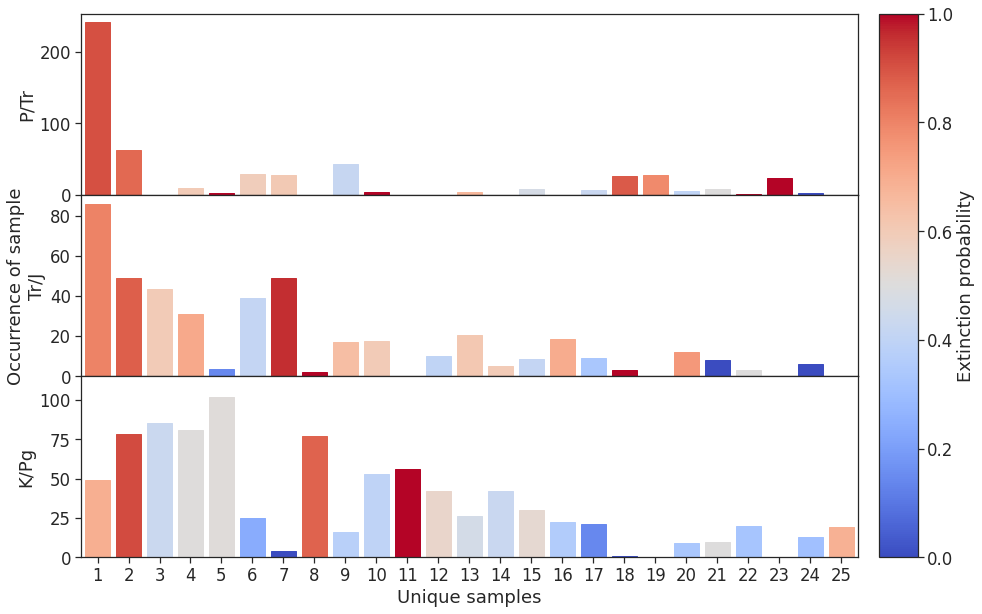

In [28]:
plot_unique_metaspecies()

# Recursive Feature Elimination Experiment

In [173]:
# Train a catboost model. Optionally take a list of the indices of categorical features.
def train_model_flexible(x_train, y_train, x_test, y_test, cat_features=None, random_seed=0, **kwargs):
    model = CatBoostClassifier(loss_function="Logloss", random_seed=random_seed)

    if cat_features is not None:
        cat_vars = cat_features
    else:
        cat_vars = np.arange(len(categorical_chars))
    
    model.fit(x_train, y_train, cat_vars, eval_set=(x_test, y_test), **kwargs)
    
    return model


def run_experiments_singleextinction(extinction, iterations=10, active_features=[True]*len(characteristics)):
    # Trains models and evaluates feature importance and performance on the different data sets for each iteration
    # The results are stored in the variables res_full (AUC scores) and feat_imp (feature importances)

    res_full = np.zeros((iterations))
    res_full_train = np.zeros((iterations))
    feat_imp = np.zeros((iterations, sum(active_features)))

    data = None
    model = None
    
    for it in tqdm(range(iterations)):

        data = prepare_data(datasets[extinction])
        x_train, y_train, x_test, y_test = data
        
        # only use variables that haven't been eliminated yet
        x_train = x_train[:, active_features]
        x_test = x_test[:, active_features]
        
        # Find the indices of categorical variables in the set of active features, to 
        # pass to catboost for model training        
        active_feature_list = []
        for idx, char in enumerate(characteristics):
            if active_features[idx] is True:
                active_feature_list.append(char)
        cat_vars = []
        for idx, char in enumerate(active_feature_list):
            if char in categorical_chars:
                cat_vars.append(idx)
                
        model = train_model_flexible(x_train, y_train, x_test, y_test, 
                                     cat_features=cat_vars, random_seed=it, plot=False, 
                                     verbose=False, use_best_model=False)

        feat_imp[it] = model.feature_importances_

        train_auc = metrics.roc_auc_score(y_train, model.predict_log_proba(x_train)[:, 1])
        test_auc = metrics.roc_auc_score(y_test, model.predict_log_proba(x_test)[:, 1])
        res_full_train[it] = train_auc
        res_full[it] = test_auc
            

    return res_full, feat_imp, res_full_train


#ext = extinctions[0]

rfe_results = {}

for ext in extinctions:
    
    rfe_results[ext] = []
    remaining_features = characteristics.copy()

    # This list of booleans encodes which features in 'characteristics' are not eliminated yet
    active_features = [True] * len(characteristics)

    
    for it in range(len(characteristics)):
        # run some iterations of a single extinction, only looking at the features specified 
        # by active_charateristics. 
        res_full, feat_imp, res_train = run_experiments_singleextinction(ext, 10, active_features)

        # average over iterations. avg_feat_imp has a length of sum(active_features).
        avg_feat_imp = np.average(feat_imp, axis = 0) 

        # Find the feature with the least importance
        least_important_idx = np.argmin(avg_feat_imp) 
        least_important = remaining_features[least_important_idx]

        #print("len(avg_feat_imp): ", len(avg_feat_imp))
        #print("remaining features: ", len(remaining_features), remaining_features)


        # determine position of eliminated feature in full characteristics list, and deactivate
        # that feature in 'active_features'.
        eliminate_char_idx = characteristics.index(least_important)
        active_features[eliminate_char_idx] = False

        remaining_features.remove(least_important)

        res_dict = {"least_important": least_important,
                    "remaining": remaining_features,
                    "avg_feat_imp": avg_feat_imp,
                    "res_full": res_full,
                    "res_avg": np.average(res_full),
                    "active_features": active_features.copy()}
        rfe_results[ext].append(res_dict)
        print("Eliminated {} with average importance of {}.".format(
            least_important, avg_feat_imp[least_important_idx]))




100%|██████████| 10/10 [00:33<00:00,  3.35s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated tiering with average importance of 9.532787510421906.



100%|██████████| 10/10 [00:33<00:00,  3.40s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated geoplates with average importance of 10.588236638474543.



100%|██████████| 10/10 [00:24<00:00,  2.45s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated protein with average importance of 11.379721876289759.



100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated feeding with average importance of 13.90719254950471.



100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated reproduction with average importance of 18.58907386444984.



100%|██████████| 10/10 [00:16<00:00,  1.60s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated species with average importance of 21.95270529310791.



100%|██████████| 10/10 [00:22<00:00,  2.20s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated mineralogy with average importance of 30.886323811445948.



100%|██████████| 10/10 [00:12<00:00,  1.23s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated motility with average importance of 49.087611719687324.



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated physiology with average importance of 100.0.



100%|██████████| 10/10 [00:30<00:00,  3.09s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated species with average importance of 4.394919143596273.



100%|██████████| 10/10 [00:29<00:00,  2.95s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated protein with average importance of 8.623121757816964.



100%|██████████| 10/10 [00:25<00:00,  2.55s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated reproduction with average importance of 11.46611977645428.



100%|██████████| 10/10 [00:21<00:00,  2.15s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated geoplates with average importance of 11.371550649410702.



100%|██████████| 10/10 [00:20<00:00,  2.02s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated feeding with average importance of 18.09463160878201.



100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated mineralogy with average importance of 23.84168952523313.



100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated motility with average importance of 32.43567134978041.



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated physiology with average importance of 48.72620961155959.



100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated tiering with average importance of 100.0.



100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated protein with average importance of 6.508119912563738.



100%|██████████| 10/10 [00:25<00:00,  2.58s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated geoplates with average importance of 7.45682798373235.



100%|██████████| 10/10 [00:24<00:00,  2.47s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated reproduction with average importance of 9.764289685809702.



100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated species with average importance of 11.338083496613775.



100%|██████████| 10/10 [00:19<00:00,  1.95s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated motility with average importance of 15.241043877115079.



100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated mineralogy with average importance of 20.792328388379893.



100%|██████████| 10/10 [00:14<00:00,  1.49s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated feeding with average importance of 26.393186916776568.



100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Eliminated physiology with average importance of 47.30062930076253.



100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

Eliminated tiering with average importance of 100.0.


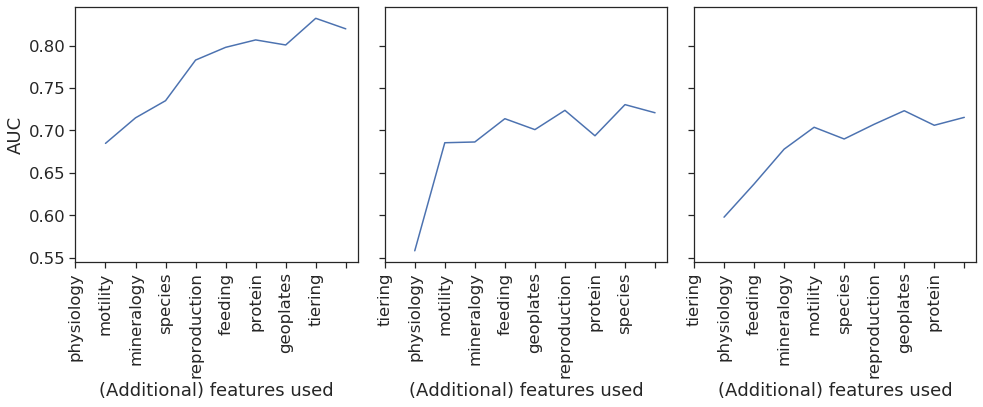

In [174]:
fig, axs = plt.subplots(1,3, figsize=(14, 6), sharey=True)
for i, ext in enumerate(extinctions):
    avg_auc = [res["res_avg"] for res in rfe_results[ext]]
    elim_feat = [res["least_important"] for res in rfe_results[ext]]
    avg_auc.reverse()
    elim_feat.reverse()
    axs[i].plot(avg_auc)
    axs[i].set_xlabel("(Additional) features used")
    axs[0].set_ylabel("AUC")
    axs[i].set_xticks(np.arange(-1,9))
    axs[i].set_xticklabels(elim_feat, rotation=90)
    plt.tight_layout()
fig.savefig("images/recursive_feature_elimination.png", dpi=300, bbox_inches="tight")

